In [1]:
#install all neccasary libraries
!pip install bert-score jiwer python-Levenshtein tqdm transformers
!pip install --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Cell 1: Import necessary libraries
import os
import json
import glob
import re
from tqdm.notebook import tqdm
import numpy as np
from google.colab import drive
import torch
from bert_score import BERTScorer
import jiwer
import Levenshtein
import pandas as pd

In [4]:
# Cell 2: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 20 duplicate files with '(1)' in their names
Removed: evaluation-adab-easyocr-allam (1).json
Removed: evaluation-synthesizear-easyocr-gpt (1).json
Removed: evaluation-adab-easyocr-gpt (1).json
Removed: evaluation-muharaf-easyocr-gpt (1).json
Removed: evaluation-patsocr-easyocr-gpt (1).json
Removed: evaluation-historyar-easyocr-allam (1).json
Removed: evaluation-evarest-easyocr-gpt (1).json
Removed: evaluation-onlinekhatt-easyocr-allam (1).json
Removed: evaluation-historyar-easyocr-gpt (1).json
Removed: evaluation-khatt-easyocr-allam (1).json
Removed: evaluation-muharaf-easyocr-allam (1).json
Removed: evaluation-historicalbooks-easyocr-gpt (1).json
Removed: evaluation-patsocr-easyocr-allam (1).json
Removed: evaluation-historicalbooks-easyocr-allam (1).json
Removed: evaluation-isippt-easyocr-gpt (1).json
Removed: evaluation-khatt-easyocr-gpt (1).json
Removed: evaluation-onlinekhatt-easyocr-gpt (1).json
Removed: evaluation-arabicocr-easyocr-gpt (1).json
Removed: evaluation-hindawi-e

In [ ]:
# Evaluation metrics helper functions
def calculate_cer(reference, hypothesis):
    """
    Calculate Character Error Rate between reference and hypothesis
    """
    if len(reference) == 0:
        return 0 if len(hypothesis) == 0 else 1

    edit_distance = Levenshtein.distance(reference, hypothesis)
    cer = edit_distance / len(reference)
    return cer

def calculate_wer(reference, hypothesis):
    """
    Calculate Word Error Rate using jiwer
    """
    try:
        return jiwer.wer(reference, hypothesis)
    except:
        # If jiwer fails, use a basic implementation
        ref_words = reference.split()
        hyp_words = hypothesis.split()

        if len(ref_words) == 0:
            return 0 if len(hyp_words) == 0 else 1

        edit_distance = Levenshtein.distance(reference, hypothesis)
        wer = edit_distance / len(ref_words)
        return wer

def calculate_edit_distance(reference, hypothesis):
    """
    Calculate raw Levenshtein edit distance
    """
    return Levenshtein.distance(reference, hypothesis)

def calculate_wer_edit_distance(reference, hypothesis):
    """
    Calculate edit distance on word level
    """
    ref_words = reference.split()
    hyp_words = hypothesis.split()

    # Create a simple representation for word-level edit distance
    return Levenshtein.distance(' '.join(ref_words), ' '.join(hyp_words))


def calculate_bertscore(references, hypotheses, lang="en"):
    """
    Calculate BERTScore F1, falling back to a simpler metric if BERTScore fails
    """
    try:
        # For Arabic language, use a specific Arabic BERT model instead of the default
        if lang == "ar":
            # Use Arabic BERT model directly (no baseline rescaling)
            scorer = BERTScorer(lang='ar', rescale_with_baseline=False)
        else:
            # For other languages, use the default with rescale_with_baseline=False
            scorer = BERTScorer(lang=lang, rescale_with_baseline=False)

        # Calculate the scores
        P, R, F1 = scorer.score(hypotheses, references)

        # Return the F1 scores as a list
        return F1.tolist()
    except Exception as e:
        print(f"Warning: Error calculating BERTScore: {e}")
        print("Using a similarity fallback metric instead.")

        # Fallback to a simpler similarity metric (normalized edit distance)
        similarity_scores = []
        for ref, hyp in zip(references, hypotheses):
            # Calculate normalized edit distance and convert to similarity
            max_len = max(len(ref), len(hyp))
            if max_len == 0:
                similarity_scores.append(1.0)  # Both strings empty
            else:
                edit_dist = Levenshtein.distance(ref, hyp)
                # Convert distance to similarity (1 - normalized_distance)
                similarity = 1.0 - (edit_dist / max_len)
                similarity_scores.append(similarity)

        return similarity_scores


In [ ]:
# Cell 5: main evaluation function

def extract_clean_text(text):
    # Case 1: النص الأصلي: ... النص المصحح:
    match = re.search(r"النص الأصلي\s*:\s*(.*?)\s*(?:النص المصحح\s*:|$)", text, re.DOTALL)
    if match:
        return match.group(1).strip()

    # Case 2: Only النص المصحح: exists → get everything before it
    match = re.search(r"^(.*?)\s*النص المصحح\s*:", text, re.DOTALL)
    if match:
        return match.group(1).strip()

    # Case 3: Neither exists → return full stripped text
    return text.strip()


def evaluate_ocr_results(directory_path, output_dir="evaluation_results"):
    """
    Evaluate OCR and corrected text against ground truth for all JSON files in a directory

    Args:
        directory_path: Path to directory containing OCR result JSON files
        output_dir: Directory to save evaluation results

    Returns:
        Dictionary containing evaluation results
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get all JSON files in the directory
    json_files = glob.glob(os.path.join(directory_path, "*.json"))

    all_results = {}

    # Process each JSON file
    for json_file in tqdm(json_files, desc="Processing files"):
        try:
            # Extract file name components for the output file
            file_name = os.path.basename(json_file)
            parts = file_name.split('-')

            if len(parts) >= 4:
                # Extract dataset, OCR model, and LLM from filename
                dataset_name = parts[1]
                ocr_model = parts[2]
                llm_name = parts[3].split('.')[0]

                # Load JSON data
                with open(json_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                # Store results for this file
                per_document_results = {}

                # Collections for calculating averages later
                all_ocr_cer = []
                all_ocr_wer = []
                all_ocr_edit_distance = []
                all_ocr_bertscore_f1 = []
                all_ocr_wer_edit_distance = []

                all_corrected_cer = []
                all_corrected_wer = []
                all_corrected_edit_distance = []
                all_corrected_bertscore_f1 = []
                all_corrected_wer_edit_distance = []

                # Collections for BERTScore batch processing
                all_ground_truths = []
                all_ocr_texts = []
                all_corrected_texts = []
                doc_ids = []

                # Detect language - simple heuristic based on first few items
                sample_text = ""
                for i, item in enumerate(data[:5]):  # Check first 5 items
                    ground_truth = item.get("الحقيقة", "") or item.get("ground_truth_cleaned", "")
                    sample_text += ground_truth
                    if i >= 5:
                        break

                lang = "ar" if any('\u0600' <= c <= '\u06FF' for c in sample_text) else "en"
                print(f"Detected language: {lang}")

                # Process each item in the JSON file
                for item_idx, item in enumerate(data):
                    # Extract ground truth and OCR text
                    ground_truth = item.get("الحقيقة", "") or item.get("ground_truth_cleaned", "")
                    ocr_text = item.get("نتيجة", "") or item.get("ocr_text", "")
                    corrected_text = item.get("النص المُصحح", "") or item.get("corrected_text", "")

                    # Clean up the corrected text by removing "النص الأصلي:" prefix
                    corrected_text = extract_clean_text(corrected_text)

                            # Skip if any of the required fields are missing
                    if not ground_truth or not ocr_text or not corrected_text:
                        continue

                    # Split texts into words for word-based length check
                    ocr_words = ocr_text.split()
                    corrected_words = corrected_text.split()

                    # Check if corrected text exceeds OCR text by more than 2 words
                    original_word_count = len(corrected_words)
                    max_allowed_words = len(ocr_words) + 2

                    # If corrected text is too long, trim it
                    if len(corrected_words) > max_allowed_words:

                        # Save the original text before trimming
                        original_corrected_text = corrected_text
                        # Trim to max allowed words
                        corrected_words = corrected_words[:max_allowed_words]
                        corrected_text = " ".join(corrected_words)






                    # Skip if any of the required fields are missing
                    if not ground_truth or not ocr_text or not corrected_text:
                        continue

                    # Store for batch BERTScore calculation
                    doc_id = f"doc_{item_idx}"
                    doc_ids.append(doc_id)
                    all_ground_truths.append(ground_truth)
                    all_ocr_texts.append(ocr_text)
                    all_corrected_texts.append(corrected_text)

                    # Calculate CER, WER, and edit distance
                    ocr_cer = calculate_cer(ground_truth, ocr_text)
                    ocr_wer = calculate_wer(ground_truth, ocr_text)
                    ocr_edit_distance = calculate_edit_distance(ground_truth, ocr_text)
                    ocr_wer_edit_distance = calculate_wer_edit_distance(ground_truth, ocr_text)

                    corrected_cer = calculate_cer(ground_truth, corrected_text)
                    corrected_wer = calculate_wer(ground_truth, corrected_text)
                    corrected_edit_distance = calculate_edit_distance(ground_truth, corrected_text)
                    corrected_wer_edit_distance = calculate_wer_edit_distance(ground_truth, corrected_text)

                    # Store individual metrics
                    all_ocr_cer.append(ocr_cer)
                    all_ocr_wer.append(ocr_wer)
                    all_ocr_edit_distance.append(ocr_edit_distance)
                    all_ocr_wer_edit_distance.append(ocr_wer_edit_distance)

                    all_corrected_cer.append(corrected_cer)
                    all_corrected_wer.append(corrected_wer)
                    all_corrected_edit_distance.append(corrected_edit_distance)
                    all_corrected_wer_edit_distance.append(corrected_wer_edit_distance)

                # Process in smaller batches to avoid memory issues
                batch_size = 32

                print(f"Using language '{lang}' for BERTScore calculation")

                # Calculate BERTScore in batches
                ocr_bertscore_f1_list = []
                corrected_bertscore_f1_list = []

                for i in range(0, len(all_ground_truths), batch_size):
                    batch_refs = all_ground_truths[i:i+batch_size]
                    batch_ocr = all_ocr_texts[i:i+batch_size]
                    batch_corrected = all_corrected_texts[i:i+batch_size]

                    try:
                        # Try to calculate BERTScore
                        ocr_scores = calculate_bertscore(batch_refs, batch_ocr, lang)
                        corrected_scores = calculate_bertscore(batch_refs, batch_corrected, lang)

                        ocr_bertscore_f1_list.extend(ocr_scores)
                        corrected_bertscore_f1_list.extend(corrected_scores)
                    except Exception as e:
                        print(f"Error calculating BERTScore for batch {i//batch_size+1}: {e}")
                        # Use fallback metric
                        for j in range(len(batch_refs)):
                            ref = batch_refs[j]
                            ocr = batch_ocr[j]
                            corr = batch_corrected[j]

                            max_len_ocr = max(len(ref), len(ocr))
                            max_len_corr = max(len(ref), len(corr))

                            if max_len_ocr == 0:
                                ocr_sim = 1.0
                            else:
                                edit_dist = Levenshtein.distance(ref, ocr)
                                ocr_sim = 1.0 - (edit_dist / max_len_ocr)

                            if max_len_corr == 0:
                                corr_sim = 1.0
                            else:
                                edit_dist = Levenshtein.distance(ref, corr)
                                corr_sim = 1.0 - (edit_dist / max_len_corr)

                            ocr_bertscore_f1_list.append(ocr_sim)
                            corrected_bertscore_f1_list.append(corr_sim)

                # Store per-document results
                for i, doc_id in enumerate(doc_ids):
                    per_document_results[doc_id] = {
                        "ocr_cer": all_ocr_cer[i],
                        "ocr_wer": all_ocr_wer[i],
                        "ocr_edit_distance": all_ocr_edit_distance[i],
                        "ocr_bertscore_f1": ocr_bertscore_f1_list[i] if i < len(ocr_bertscore_f1_list) else 0.0,
                        "ocr_wer_edit_distance": all_ocr_wer_edit_distance[i],
                        "corrected_cer": all_corrected_cer[i],
                        "corrected_wer": all_corrected_wer[i],
                        "corrected_edit_distance": all_corrected_edit_distance[i],
                        "corrected_bertscore_f1": corrected_bertscore_f1_list[i] if i < len(corrected_bertscore_f1_list) else 0.0,
                        "corrected_wer_edit_distance": all_corrected_wer_edit_distance[i]
                    }

                # Calculate averages
                avg_results = {
                    "ocr_cer": np.mean(all_ocr_cer) if all_ocr_cer else 0.0,
                    "ocr_wer": np.mean(all_ocr_wer) if all_ocr_wer else 0.0,
                    "ocr_edit_distance": np.mean(all_ocr_edit_distance) if all_ocr_edit_distance else 0.0,
                    "ocr_bertscore_f1": np.mean(ocr_bertscore_f1_list) if ocr_bertscore_f1_list else 0.0,
                    "ocr_wer_edit_distance": np.mean(all_ocr_wer_edit_distance) if all_ocr_wer_edit_distance else 0.0,
                    "corrected_cer": np.mean(all_corrected_cer) if all_corrected_cer else 0.0,
                    "corrected_wer": np.mean(all_corrected_wer) if all_corrected_wer else 0.0,
                    "corrected_edit_distance": np.mean(all_corrected_edit_distance) if all_corrected_edit_distance else 0.0,
                    "corrected_bertscore_f1": np.mean(corrected_bertscore_f1_list) if corrected_bertscore_f1_list else 0.0,
                    "corrected_wer_edit_distance": np.mean(all_corrected_wer_edit_distance) if all_corrected_wer_edit_distance else 0.0
                }

                # Create final result structure
                file_results = {
                    "per_document_results": per_document_results,
                    "avg_results": avg_results
                }

                # Save results to file
                output_file = f"evaluation-{dataset_name}-{ocr_model}-{llm_name}.json"
                output_path = os.path.join(output_dir, output_file)

                with open(output_path, 'w', encoding='utf-8') as f:
                    json.dump(file_results, f, ensure_ascii=False, indent=2)

                # Store in all results dictionary
                all_results[file_name] = file_results

                print(f"Processed {file_name}, saved results to {output_path}")
        except Exception as e:
            print(f"Error processing file {json_file}: {e}")
            continue

    return all_results


In [ ]:
# Cell 5: Run the evaluation on your directory
# Replace with your actual directory path from Google Drive
directory_path = "/content/drive/My Drive/righting-writing_results/post_correction"
output_dir = "/content/drive/My Drive/righting-writing_results/evaluation_results"
results = evaluate_ocr_results(directory_path,output_dir)


Processing files:   0%|          | 0/24 [00:00<?, ?it/s]

Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-synthesizear-paddle-gpt-4o.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-synthesizear-paddle-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-patsocr-paddle-gpt-4o.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-patsocr-paddle-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historyar-paddle-gpt-4o.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-historyar-paddle-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historicalbooks-paddle-gpt-4o.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-historicalbooks-paddle-gpt.json
De

Processed post_correction-historyar-paddle-allam-7b.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-historyar-paddle-allam.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historicalbooks-paddle-allam-7b.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-historicalbooks-paddle-allam.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-adab-paddle-allam-7b.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-adab-paddle-allam.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-muharaf-paddle-allam-7b.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-muharaf-paddle-allam.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Pr

Processed post_correction-evarest-paddle-allam-7b.json, saved results to /content/drive/My Drive/righting-writing_results/evaluation_results/evaluation-evarest-paddle-allam.json


In [ ]:
# Cell 6: Optional - Create a summary DataFrame for comparison
def create_summary_dataframe(results):
    """
    Create a summary DataFrame for easy comparison of results
    """
    summary_data = []

    for file_name, file_results in results.items():
        # Extract components from file name
        parts = file_name.split('-')
        if len(parts) >= 4:
            dataset = parts[1]
            ocr_model = parts[2]
            llm = parts[3].split('.')[0]

            # Get average results
            avg_results = file_results["avg_results"]

            # Calculate improvement percentages
            wer_improvement = ((avg_results["ocr_wer"] - avg_results["corrected_wer"]) / avg_results["ocr_wer"]) * 100 if avg_results["ocr_wer"] > 0 else 0
            cer_improvement = ((avg_results["ocr_cer"] - avg_results["corrected_cer"]) / avg_results["ocr_cer"]) * 100 if avg_results["ocr_cer"] > 0 else 0
            bertscore_improvement = ((avg_results["corrected_bertscore_f1"] - avg_results["ocr_bertscore_f1"]) / avg_results["ocr_bertscore_f1"]) * 100 if avg_results["ocr_bertscore_f1"] > 0 else 0

            # Add to summary data
            summary_data.append({
                "Dataset": dataset,
                "OCR": ocr_model,
                "LLM": llm,
                "OCR WER": avg_results["ocr_wer"],
                "Corrected WER": avg_results["corrected_wer"],
                "WER Improvement %": wer_improvement,
                "OCR CER": avg_results["ocr_cer"],
                "Corrected CER": avg_results["corrected_cer"],
                "CER Improvement %": cer_improvement,
                "OCR BERTScore": avg_results["ocr_bertscore_f1"],
                "Corrected BERTScore": avg_results["corrected_bertscore_f1"],
                "BERTScore Improvement %": bertscore_improvement
            })

    # Create DataFrame
    df = pd.DataFrame(summary_data)

    # Sort by improvement
    df = df.sort_values("WER Improvement %", ascending=False)

    return df

# Create and display summary DataFrame
summary_df = create_summary_dataframe(results)
display(summary_df)

Dataset      OCR    LLM   OCR WER  Corrected WER  \
10          hindawi  easyocr    gpt  0.750417       0.577214   
0      synthesizear  easyocr    gpt  0.789004       0.672143   
6       onlinekhatt  easyocr    gpt  1.120040       1.011097   
4              adab  easyocr    gpt  1.329690       1.213115   
1           patsocr  easyocr    gpt  0.736966       0.676867   
7             khatt  easyocr    gpt  1.080529       1.003683   
8            isippt  easyocr    gpt  0.788654       0.732601   
2         historyar  easyocr    gpt  0.982575       0.941423   
3   historicalbooks  easyocr    gpt  1.003194       0.968700   
5           muharaf  easyocr    gpt  1.096390       1.089483   
15  historicalbooks  easyocr  allam  1.003194       1.003194   
22          hindawi  easyocr  allam  0.750417       0.754751   
21        arabicocr  easyocr  allam  0.755945       0.767196   
11          evarest  easyocr    gpt  0.668770       0.687697   
13          patsocr  easyocr  allam  0.736966       0.778064   
19            khatt  easyocr  allam  1.080529       1.143348   
14        historyar  easyocr  allam  0.982575       1.050731   
17          muharaf  easyocr  allam  1.095863       1.196492   
9         arabicocr  easyocr    gpt  0.755945       0.831507   
18      onlinekhatt  easyocr  allam  1.120040       1.285522   
20           isippt  easyocr  allam  0.789587       0.962284   
12     synthesizear  easyocr  allam  0.789004       0.967367   
16             adab  easyocr  allam  1.329690       1.939891   
23          evarest  easyocr  allam  0.672387       1.745710   

    WER Improvement %   OCR CER  Corrected CER  CER Improvement %  \
10          23.080861  0.440948       0.406658           7.776456   
0           14.811182  0.459066       0.450287           1.912378   
6            9.726661  0.577202       0.596338          -3.315414   
4            8.767123  0.673489       0.700999          -4.084652   
1            8.154848  0.553657       0.544929           1.576429   
7            7.111876  0.686760       0.685866           0.130149   
8            7.107463  0.521444       0.520139           0.250213   
2            4.188099  0.499838       0.572668         -14.570781   
3            3.438398  0.622860       0.629003          -0.986287   
5            0.630026  0.719214       0.734540          -2.130967   
15           0.000000  0.622860       0.650821          -4.489120   
22          -0.577598  0.440948       0.448567          -1.727748   
21          -1.488314  0.562075       0.582890          -3.703386   
11          -2.830189  0.423005       0.443596          -4.867814   
13          -5.576642  0.553657       0.591202          -6.781283   
19          -5.813668  0.686760       0.867862         -26.370596   
14          -6.936510  0.499838       0.879494         -75.955737   
17          -9.182589  0.720748       1.177328         -63.348160   
9           -9.995705  0.562075       0.586660          -4.373982   
18         -14.774668  0.577202       1.033865         -79.116661   
20         -21.871815  0.523336       0.717105         -37.025692   
12         -22.606026  0.459066       0.727757         -58.529784   
16         -45.890411  0.673489       1.533502        -127.695125   
23        -159.628770  0.430866       4.958010       -1050.708710   

    OCR BERTScore  Corrected BERTScore  BERTScore Improvement %  
10       0.786161             0.845264                 7.517997  
0        0.826847             0.852769                 3.134966  
6        0.677051             0.724481                 7.005383  
4        0.767515             0.765571                -0.253210  
1        0.862442             0.879395                 1.965773  
7        0.666477             0.699567                 4.964902  
8        0.795842             0.823148                 3.431052  
2        0.702235             0.719378                 2.441215  
3        0.651015             0.665457                 2.218392  
5        0.659853        

<ipython-input-57-09d5ff43e151>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-57-09d5ff43e151>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
<ipython-input-57-09d5ff43e151>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")


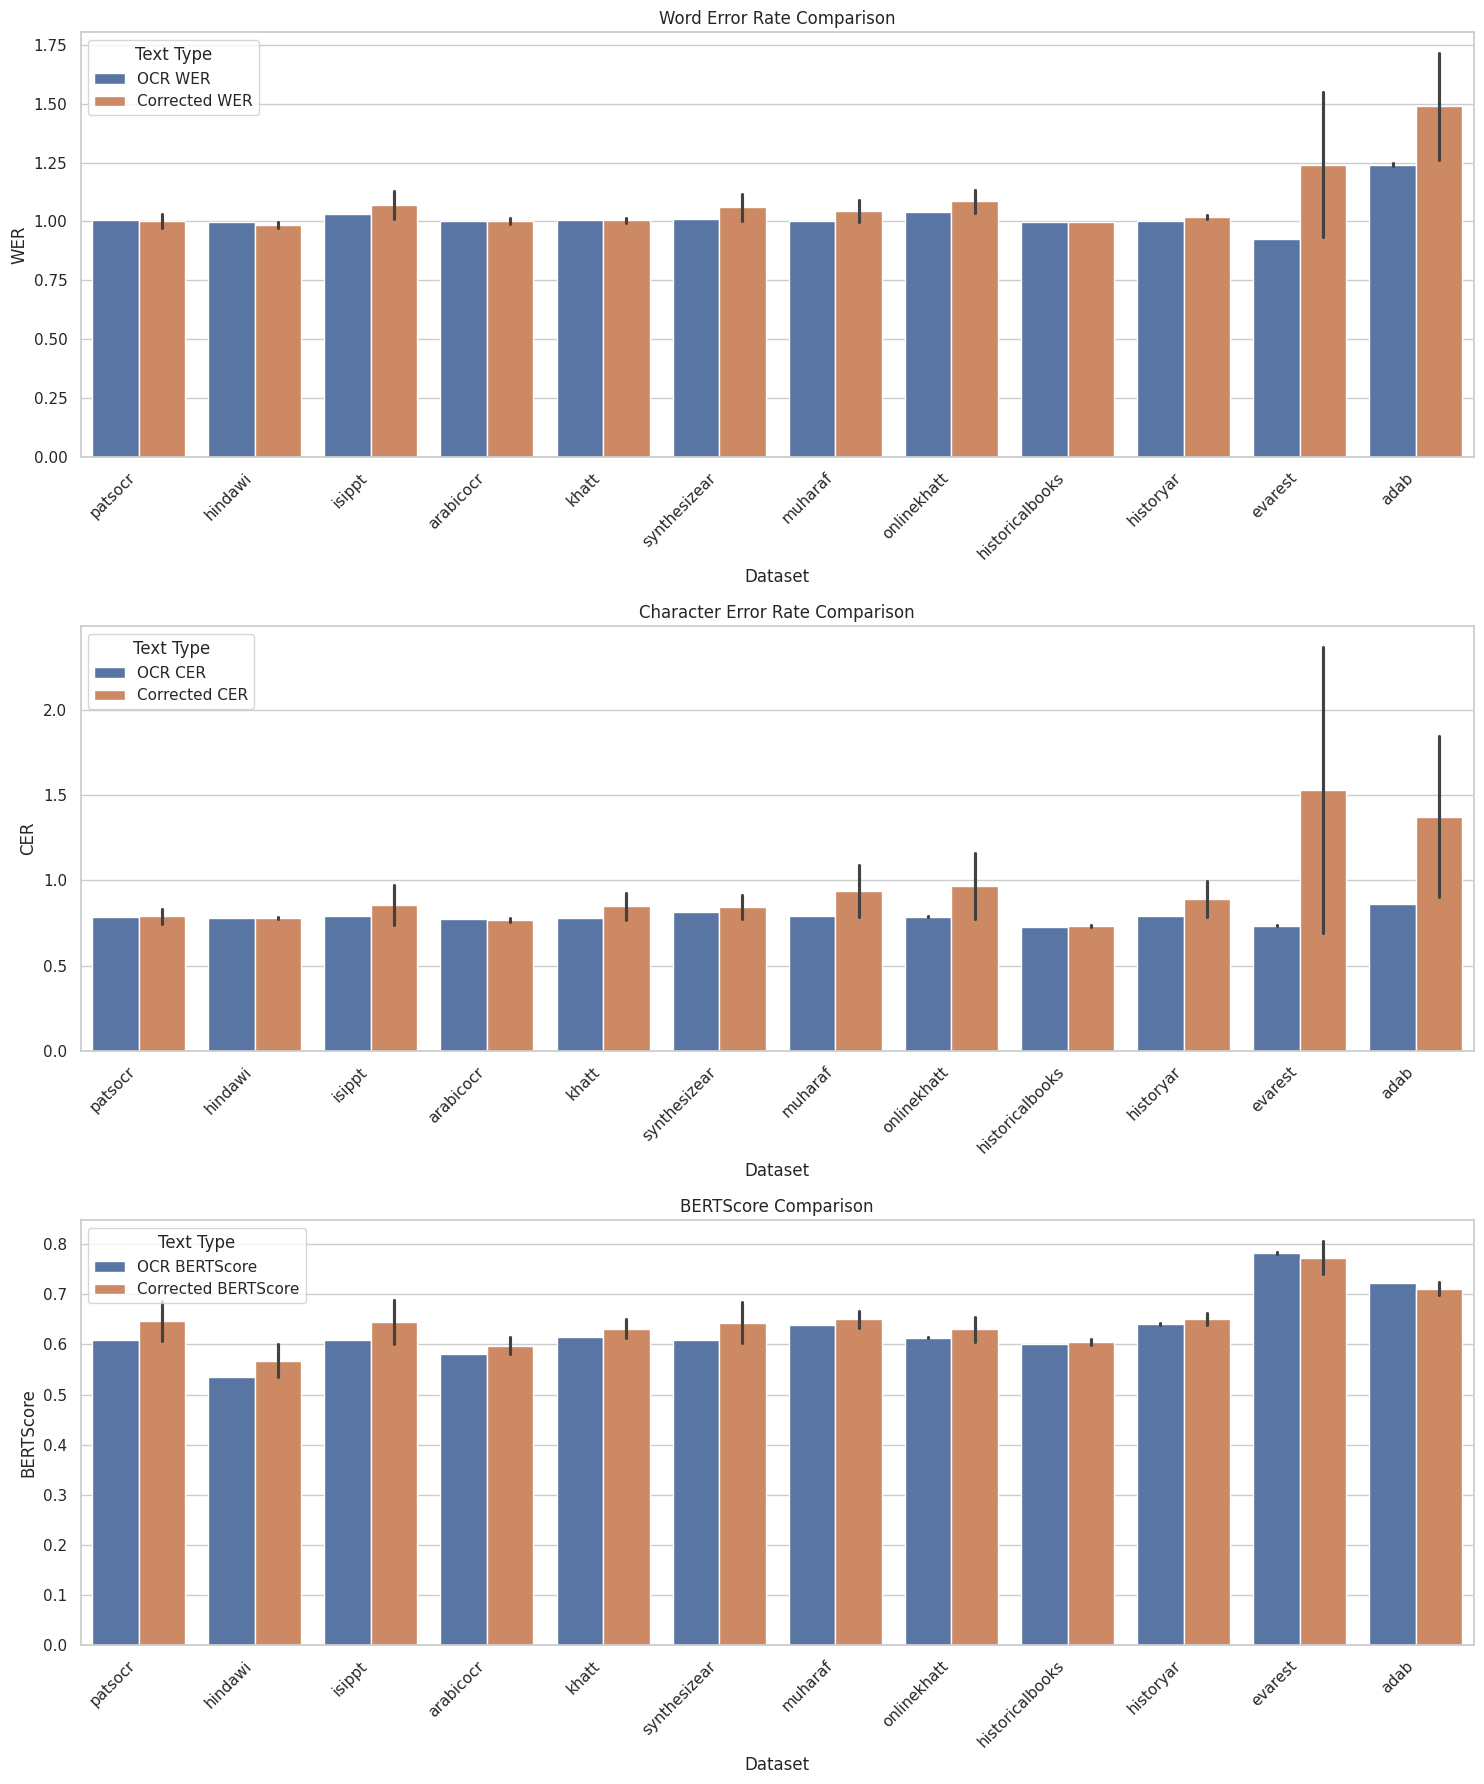

In [ ]:
# Cell 7: Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(summary_df):
    """
    Create visualizations of the results
    """
    # Set style
    sns.set(style="whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))

    # Plot WER comparison
    wer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR WER", "Corrected WER"],
        var_name="Text Type", value_name="WER"
    )
    sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0])
    axes[0].set_title("Word Error Rate Comparison")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

    # Plot CER comparison
    cer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR CER", "Corrected CER"],
        var_name="Text Type", value_name="CER"
    )
    sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1])
    axes[1].set_title("Character Error Rate Comparison")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Plot BERTScore comparison
    bertscore_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR BERTScore", "Corrected BERTScore"],
        var_name="Text Type", value_name="BERTScore"
    )
    sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2])
    axes[2].set_title("BERTScore Comparison")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(summary_df)

**Optional - This code filters the results where the corrected text is longer than the ocr text. This results in higher accuracy since the llm's can sometimes produce repeated text and other errors**

In [ ]:

# Cell 5: Define the main evaluation function with length filtering
def evaluate_ocr_results_with_filtering(directory_path, output_dir="evaluation_results"):
    """
    Evaluate OCR and corrected text against ground truth for all JSON files in a directory,
    filtering out cases where corrected text length exceeds OCR text length by more than 1

    Args:
        directory_path: Path to directory containing OCR result JSON files
        output_dir: Directory to save evaluation results

    Returns:
        Dictionary containing evaluation results
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get all JSON files in the directory
    json_files = glob.glob(os.path.join(directory_path, "*.json"))

    all_results = {}
    filtering_stats = {}

    # Process each JSON file
    for json_file in tqdm(json_files, desc="Processing files"):
        try:
            # Extract file name components for the output file
            file_name = os.path.basename(json_file)
            parts = file_name.split('-')

            if len(parts) >= 4:
                # Extract dataset, OCR model, and LLM from filename
                dataset_name = parts[1]
                ocr_model = parts[2]
                llm_name = parts[3].split('.')[0]

                # Load JSON data
                with open(json_file, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                # Store results for this file
                per_document_results = {}

                # Collections for calculating averages later
                all_ocr_cer = []
                all_ocr_wer = []
                all_ocr_edit_distance = []
                all_ocr_bertscore_f1 = []
                all_ocr_wer_edit_distance = []

                all_corrected_cer = []
                all_corrected_wer = []
                all_corrected_edit_distance = []
                all_corrected_bertscore_f1 = []
                all_corrected_wer_edit_distance = []

                # Collections for BERTScore batch processing
                all_ground_truths = []
                all_ocr_texts = []
                all_corrected_texts = []
                doc_ids = []

                # Stats for length filtering
                original_count = len(data)
                filtered_count = 0
                removed_count = 0
                filtered_items_metadata = []

                # Detect language - simple heuristic based on first few items
                sample_text = ""
                for i, item in enumerate(data[:5]):  # Check first 5 items
                    ground_truth = item.get("الحقيقة", "") or item.get("ground_truth_cleaned", "")
                    sample_text += ground_truth
                    if i >= 5:
                        break

                lang = "ar" if any('\u0600' <= c <= '\u06FF' for c in sample_text) else "en"
                print(f"Detected language: {lang}")

                # Process each item in the JSON file
                for item_idx, item in enumerate(data):
                    # Extract ground truth and OCR text
                    ground_truth = item.get("الحقيقة", "") or item.get("ground_truth_cleaned", "")
                    ocr_text = item.get("نتيجة", "") or item.get("ocr_text", "")
                    corrected_text = item.get("النص المُصحح", "") or item.get("corrected_text", "")

                    # Clean up the corrected text by removing "النص الأصلي:" prefix
                    corrected_text = corrected_text.replace("النص الأصلي:", "").strip()

                    # Skip if any of the required fields are missing
                    if not ground_truth or not ocr_text or not corrected_text:
                        continue

                    # Apply length filtering
                    if len(corrected_text) > len(ocr_text) + 1:
                        # Track metadata about filtered item
                        filtered_items_metadata.append({
                            "item_idx": item_idx,
                            "ocr_length": len(ocr_text),
                            "corrected_length": len(corrected_text),
                            "difference": len(corrected_text) - len(ocr_text)
                        })
                        removed_count += 1
                        continue  # Skip this item

                    # If we got here, the item passed the filter
                    filtered_count += 1

                    # Store for batch BERTScore calculation
                    doc_id = f"doc_{item_idx}"
                    doc_ids.append(doc_id)
                    all_ground_truths.append(ground_truth)
                    all_ocr_texts.append(ocr_text)
                    all_corrected_texts.append(corrected_text)

                    # Calculate CER, WER, and edit distance
                    ocr_cer = calculate_cer(ground_truth, ocr_text)
                    ocr_wer = calculate_wer(ground_truth, ocr_text)
                    ocr_edit_distance = calculate_edit_distance(ground_truth, ocr_text)
                    ocr_wer_edit_distance = calculate_wer_edit_distance(ground_truth, ocr_text)

                    corrected_cer = calculate_cer(ground_truth, corrected_text)
                    corrected_wer = calculate_wer(ground_truth, corrected_text)
                    corrected_edit_distance = calculate_edit_distance(ground_truth, corrected_text)
                    corrected_wer_edit_distance = calculate_wer_edit_distance(ground_truth, corrected_text)

                    # Store individual metrics
                    all_ocr_cer.append(ocr_cer)
                    all_ocr_wer.append(ocr_wer)
                    all_ocr_edit_distance.append(ocr_edit_distance)
                    all_ocr_wer_edit_distance.append(ocr_wer_edit_distance)

                    all_corrected_cer.append(corrected_cer)
                    all_corrected_wer.append(corrected_wer)
                    all_corrected_edit_distance.append(corrected_edit_distance)
                    all_corrected_wer_edit_distance.append(corrected_wer_edit_distance)

                # Track filtering stats
                filtering_stats[file_name] = {
                    "original_count": original_count,
                    "filtered_count": filtered_count,
                    "removed_count": removed_count,
                    "removal_rate": removed_count / original_count if original_count > 0 else 0
                }

                # If no documents passed filtering, create an empty result
                if len(doc_ids) == 0:
                    print(f"Warning: All documents in {file_name} were filtered out!")
                    file_results = {
                        "per_document_results": {},
                        "avg_results": {},
                        "filtering_metadata": {
                            "original_count": original_count,
                            "filtered_count": filtered_count,
                            "removed_count": removed_count,
                            "filtered_items": filtered_items_metadata
                        }
                    }

                    # Save results to file
                    output_file = f"evaluation-{dataset_name}-{ocr_model}-{llm_name}.json"
                    output_path = os.path.join(output_dir, output_file)

                    with open(output_path, 'w', encoding='utf-8') as f:
                        json.dump(file_results, f, ensure_ascii=False, indent=2)

                    # Store in all results dictionary
                    all_results[file_name] = file_results

                    print(f"Processed {file_name}, saved empty results to {output_path}")
                    continue

                # Process in smaller batches to avoid memory issues
                batch_size = 32

                print(f"Using language '{lang}' for BERTScore calculation")

                # Calculate BERTScore in batches
                ocr_bertscore_f1_list = []
                corrected_bertscore_f1_list = []

                for i in range(0, len(all_ground_truths), batch_size):
                    batch_refs = all_ground_truths[i:i+batch_size]
                    batch_ocr = all_ocr_texts[i:i+batch_size]
                    batch_corrected = all_corrected_texts[i:i+batch_size]

                    try:
                        # Try to calculate BERTScore
                        ocr_scores = calculate_bertscore(batch_refs, batch_ocr, lang)
                        corrected_scores = calculate_bertscore(batch_refs, batch_corrected, lang)

                        ocr_bertscore_f1_list.extend(ocr_scores)
                        corrected_bertscore_f1_list.extend(corrected_scores)
                    except Exception as e:
                        print(f"Error calculating BERTScore for batch {i//batch_size+1}: {e}")
                        # Use fallback metric
                        for j in range(len(batch_refs)):
                            ref = batch_refs[j]
                            ocr = batch_ocr[j]
                            corr = batch_corrected[j]

                            max_len_ocr = max(len(ref), len(ocr))
                            max_len_corr = max(len(ref), len(corr))

                            if max_len_ocr == 0:
                                ocr_sim = 1.0
                            else:
                                edit_dist = Levenshtein.distance(ref, ocr)
                                ocr_sim = 1.0 - (edit_dist / max_len_ocr)

                            if max_len_corr == 0:
                                corr_sim = 1.0
                            else:
                                edit_dist = Levenshtein.distance(ref, corr)
                                corr_sim = 1.0 - (edit_dist / max_len_corr)

                            ocr_bertscore_f1_list.append(ocr_sim)
                            corrected_bertscore_f1_list.append(corr_sim)

                # Store per-document results
                for i, doc_id in enumerate(doc_ids):
                    per_document_results[doc_id] = {
                        "ocr_cer": all_ocr_cer[i],
                        "ocr_wer": all_ocr_wer[i],
                        "ocr_edit_distance": all_ocr_edit_distance[i],
                        "ocr_bertscore_f1": ocr_bertscore_f1_list[i] if i < len(ocr_bertscore_f1_list) else 0.0,
                        "ocr_wer_edit_distance": all_ocr_wer_edit_distance[i],
                        "corrected_cer": all_corrected_cer[i],
                        "corrected_wer": all_corrected_wer[i],
                        "corrected_edit_distance": all_corrected_edit_distance[i],
                        "corrected_bertscore_f1": corrected_bertscore_f1_list[i] if i < len(corrected_bertscore_f1_list) else 0.0,
                        "corrected_wer_edit_distance": all_corrected_wer_edit_distance[i]
                    }

                # Calculate averages
                avg_results = {
                    "ocr_cer": np.mean(all_ocr_cer) if all_ocr_cer else 0.0,
                    "ocr_wer": np.mean(all_ocr_wer) if all_ocr_wer else 0.0,
                    "ocr_edit_distance": np.mean(all_ocr_edit_distance) if all_ocr_edit_distance else 0.0,
                    "ocr_bertscore_f1": np.mean(ocr_bertscore_f1_list) if ocr_bertscore_f1_list else 0.0,
                    "ocr_wer_edit_distance": np.mean(all_ocr_wer_edit_distance) if all_ocr_wer_edit_distance else 0.0,
                    "corrected_cer": np.mean(all_corrected_cer) if all_corrected_cer else 0.0,
                    "corrected_wer": np.mean(all_corrected_wer) if all_corrected_wer else 0.0,
                    "corrected_edit_distance": np.mean(all_corrected_edit_distance) if all_corrected_edit_distance else 0.0,
                    "corrected_bertscore_f1": np.mean(corrected_bertscore_f1_list) if corrected_bertscore_f1_list else 0.0,
                    "corrected_wer_edit_distance": np.mean(all_corrected_wer_edit_distance) if all_corrected_wer_edit_distance else 0.0
                }

                # Create final result structure
                file_results = {
                    "per_document_results": per_document_results,
                    "avg_results": avg_results,
                    "filtering_metadata": {
                        "original_count": original_count,
                        "filtered_count": filtered_count,
                        "removed_count": removed_count,
                        "filtered_items": filtered_items_metadata
                    }
                }

                # Save results to file
                output_file = f"evaluation-{dataset_name}-{ocr_model}-{llm_name}.json"
                output_path = os.path.join(output_dir, output_file)

                with open(output_path, 'w', encoding='utf-8') as f:
                    json.dump(file_results, f, ensure_ascii=False, indent=2)

                # Store in all results dictionary
                all_results[file_name] = file_results

                print(f"Processed {file_name}, saved results to {output_path}")
                print(f"  Kept {filtered_count}/{original_count} documents (removed {removed_count})")

        except Exception as e:
            print(f"Error processing file {json_file}: {e}")
            continue

    # Save filtering stats
    stats_path = os.path.join(output_dir, "filtering_stats.json")
    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(filtering_stats, f, ensure_ascii=False, indent=2)

    return all_results, filtering_stats


In [ ]:
# Cell 6: Run the evaluation on your directory with length filtering
# Replace with your actual directory path from Google Drive
directory_path = "/content/drive/My Drive/righting-writing_results/post_correction"
results, filtering_stats = evaluate_ocr_results_with_filtering(directory_path, "filtered_evaluation_results")


Processing files:   0%|          | 0/24 [00:00<?, ?it/s]

Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-synthesizear-paddle-gpt-4o.json, saved results to filtered_evaluation_results/evaluation-synthesizear-paddle-gpt.json
  Kept 382/500 documents (removed 112)
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-patsocr-paddle-gpt-4o.json, saved results to filtered_evaluation_results/evaluation-patsocr-paddle-gpt.json
  Kept 385/500 documents (removed 112)
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historyar-paddle-gpt-4o.json, saved results to filtered_evaluation_results/evaluation-historyar-paddle-gpt.json
  Kept 138/200 documents (removed 32)
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historicalbooks-paddle-gpt-4o.json, saved results to filtered_evaluation_results/evaluation-historicalbooks-paddle-gpt.json
  Kept 9/10 documents (removed 1)
Detected lan

In [ ]:
# Cell 7: Optional - Generate filtering report
def generate_filtering_report(stats):
    """
    Generate a summary report of filtering results
    """
    print("\n===== FILTERING REPORT =====")
    print(f"Total files processed: {len(stats)}")

    total_original = sum(file_stats["original_count"] for file_stats in stats.values())
    total_kept = sum(file_stats["filtered_count"] for file_stats in stats.values())
    total_removed = sum(file_stats["removed_count"] for file_stats in stats.values())

    print(f"Total documents processed: {total_original}")
    print(f"Documents kept: {total_kept} ({total_kept/total_original*100:.2f}%)")
    print(f"Documents removed: {total_removed} ({total_removed/total_original*100:.2f}%)")

    print("\nTop 5 files with highest removal rates:")
    sorted_stats = sorted(stats.items(), key=lambda x: x[1]["removal_rate"], reverse=True)
    for file_name, file_stats in sorted_stats[:5]:
        removal_rate = file_stats["removal_rate"] * 100
        print(f"  {file_name}: {file_stats['removed_count']}/{file_stats['original_count']} removed ({removal_rate:.2f}%)")

    print("\n=============================")

# Generate report
generate_filtering_report(filtering_stats)



===== FILTERING REPORT =====
Total files processed: 24
Total documents processed: 7120
Documents kept: 3463 (48.64%)
Documents removed: 2554 (35.87%)

Top 5 files with highest removal rates:
  post_correction-hindawi-paddle-allam-7b.json: 145/200 removed (72.50%)
  post_correction-synthesizear-paddle-allam-7b.json: 341/500 removed (68.20%)
  post_correction-arabicocr-paddle-allam-7b.json: 33/50 removed (66.00%)
  post_correction-onlinekhatt-paddle-allam-7b.json: 126/200 removed (63.00%)
  post_correction-patsocr-paddle-allam-7b.json: 313/500 removed (62.60%)



In [ ]:
# Cell 8: Optional - Create a summary DataFrame for comparison
def create_summary_dataframe(results):
    """
    Create a summary DataFrame for easy comparison of results
    """
    summary_data = []

    for file_name, file_results in results.items():
        # Extract components from file name
        parts = file_name.split('-')
        if len(parts) >= 4:
            dataset = parts[1]
            ocr_model = parts[2]
            llm = parts[3].split('.')[0]

            # Get average results
            avg_results = file_results["avg_results"]

            # Calculate improvement percentages
            wer_improvement = ((avg_results["ocr_wer"] - avg_results["corrected_wer"]) / avg_results["ocr_wer"]) * 100 if avg_results["ocr_wer"] > 0 else 0
            cer_improvement = ((avg_results["ocr_cer"] - avg_results["corrected_cer"]) / avg_results["ocr_cer"]) * 100 if avg_results["ocr_cer"] > 0 else 0
            bertscore_improvement = ((avg_results["corrected_bertscore_f1"] - avg_results["ocr_bertscore_f1"]) / avg_results["ocr_bertscore_f1"]) * 100 if avg_results["ocr_bertscore_f1"] > 0 else 0

            # Add to summary data
            summary_data.append({
                "Dataset": dataset,
                "OCR": ocr_model,
                "LLM": llm,
                "OCR WER": avg_results["ocr_wer"],
                "Corrected WER": avg_results["corrected_wer"],
                "WER Improvement %": wer_improvement,
                "OCR CER": avg_results["ocr_cer"],
                "Corrected CER": avg_results["corrected_cer"],
                "CER Improvement %": cer_improvement,
                "OCR BERTScore": avg_results["ocr_bertscore_f1"],
                "Corrected BERTScore": avg_results["corrected_bertscore_f1"],
                "BERTScore Improvement %": bertscore_improvement
            })

    # Create DataFrame
    df = pd.DataFrame(summary_data)

    # Sort by improvement
    df = df.sort_values("WER Improvement %", ascending=False)

    return df

# Create and display summary DataFrame
summary_df = create_summary_dataframe(results)
display(summary_df)

Dataset     OCR    LLM   OCR WER  Corrected WER  \
1           patsocr  paddle    gpt  1.006069       0.969944   
11          evarest  paddle    gpt  0.921114       0.893271   
8            isippt  paddle    gpt  1.031570       1.001701   
4              adab  paddle    gpt  1.264012       1.228614   
10          hindawi  paddle    gpt  0.996717       0.972309   
0      synthesizear  paddle    gpt  1.010783       0.991830   
9         arabicocr  paddle    gpt  1.004986       0.989017   
6       onlinekhatt  paddle    gpt  1.041620       1.027010   
7             khatt  paddle    gpt  1.005720       0.991763   
5           muharaf  paddle    gpt  1.003651       0.996356   
3   historicalbooks  paddle    gpt  0.998413       0.998084   
16             adab  paddle  allam  1.382353       1.382353   
12     synthesizear  paddle  allam  1.015963       1.015963   
13          patsocr  paddle  allam  1.007154       1.007154   
14        historyar  paddle  allam  1.006339       1.006339   
15  historicalbooks  paddle  allam  0.996429       0.996429   
21        arabicocr  paddle  allam  1.002580       1.002580   
17          muharaf  paddle  allam  1.006667       1.006667   
18      onlinekhatt  paddle  allam  1.027934       1.027934   
19            khatt  paddle  allam  0.996632       0.996632   
22          hindawi  paddle  allam  0.995852       0.995852   
2         historyar  paddle    gpt  1.001886       1.002398   
20           isippt  paddle  allam  1.038516       1.039219   
23          evarest  paddle  allam  0.964286       0.976190   

    WER Improvement %   OCR CER  Corrected CER  CER Improvement %  \
1            3.590748  0.781759       0.739925           5.351298   
11           3.022670  0.730070       0.656408          10.089636   
8            2.895529  0.788203       0.730825           7.279658   
4            2.800467  0.863038       0.863867          -0.096096   
10           2.448917  0.779622       0.771028           1.102312   
0            1.875109  0.811620       0.762578           6.042439   
9            1.589046  0.772187       0.752452           2.555686   
6            1.402660  0.791112       0.767256           3.015508   
7            1.387757  0.778201       0.769522           1.115230   
5            0.726814  0.791325       0.782674           1.093272   
3            0.032893  0.726954       0.741825          -2.045630   
16           0.000000  0.832868       0.857377          -2.942821   
12           0.000000  0.813714       0.815929          -0.272207   
13           0.000000  0.779342       0.780596          -0.160885   
14           0.000000  0.797814       0.795671           0.268576   
15           0.000000  0.724144       0.724144           0.000000   
21           0.000000  0.770657       0.770657           0.000000   
17           0.000000  0.796128       0.796931          -0.100902   
18           0.000000  0.786030       0.787920          -0.240416   
19           0.000000  0.775790       0.775333           0.058856   
22           0.000000  0.796126       0.796054           0.009057   
2           -0.051151  0.794610       0.789418           0.653431   
20          -0.067715  0.793938       0.794007          -0.008804   
23          -1.234568  0.828524       0.816421           1.460811   

    OCR BERTScore  Corrected BERTScore  BERTScore Improvement %  
1        0.608526             0.683546                12.328220  
11       0.785024             0.811392                 3.358878  
8        0.610691             0.684623                12.106159  
4        0.722001             0.726340                 0.601011  
10       0.534806             0.601499                12.470586  
0        0.608434             0.679449                11.671769  
9        0.580170             0.606054                 4.461361  
6        0.614736             0.651605                 5.997478  
7        0.613802             0.647650                 5.514496  
5        0.641197             0.667855            

<ipython-input-41-db9afca82354>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-41-db9afca82354>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
<ipython-input-41-db9afca82354>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")


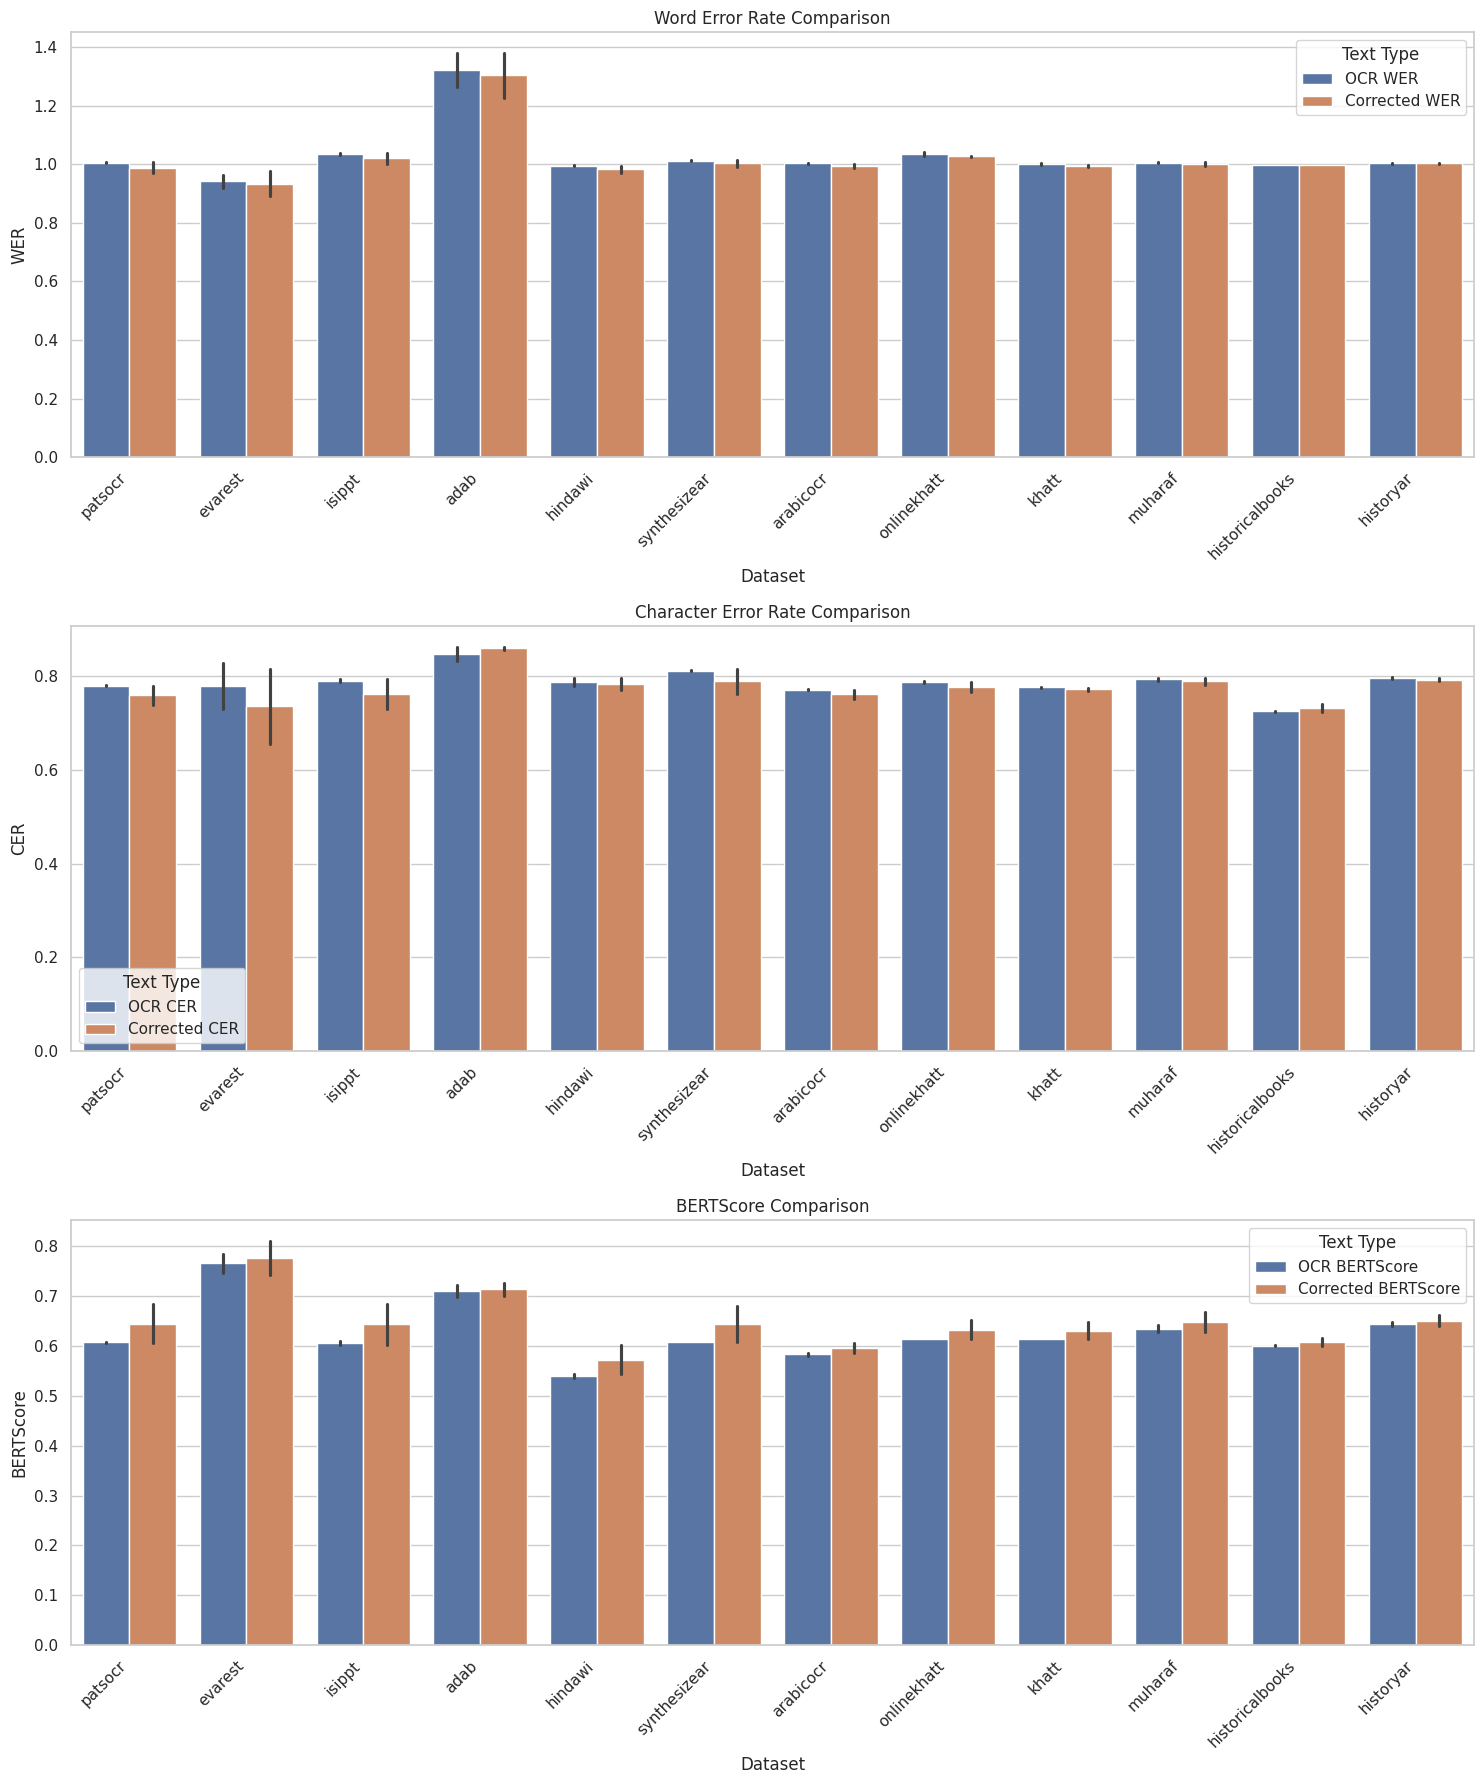

In [ ]:
# Cell 8: Optional - Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(summary_df):
    """
    Create visualizations of the results
    """
    # Set style
    sns.set(style="whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))

    # Plot WER comparison
    wer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR WER", "Corrected WER"],
        var_name="Text Type", value_name="WER"
    )
    sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0])
    axes[0].set_title("Word Error Rate Comparison")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

    # Plot CER comparison
    cer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR CER", "Corrected CER"],
        var_name="Text Type", value_name="CER"
    )
    sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1])
    axes[1].set_title("Character Error Rate Comparison")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Plot BERTScore comparison
    bertscore_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR BERTScore", "Corrected BERTScore"],
        var_name="Text Type", value_name="BERTScore"
    )
    sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2])
    axes[2].set_title("BERTScore Comparison")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(summary_df)

**MJ dataset **

In [ ]:
# Cell 5: Run the evaluation on your directory
# Replace with your actual directory path from Google Drive
directory_path = "/content/drive/MyDrive/post_correction"
output_dir = "/content/drive/MyDrive/post_correction/results"
results = evaluate_ocr_results(directory_path,output_dir)


Processing files:   0%|          | 0/24 [00:00<?, ?it/s]

Detected language: ar
Using language 'ar' for BERTScore calculation


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Processed post_correction-synthesizear-tesseract-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction/results/evaluation-synthesizear-tesseract-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-patsocr-tesseract-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction/results/evaluation-patsocr-tesseract-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historyar-tesseract-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction/results/evaluation-historyar-tesseract-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historicalbooks-tesseract-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction/results/evaluation-historicalbooks-tesseract-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-adab-tesseract-gpt-4o.json, saved re

<ipython-input-10-09d5ff43e151>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-10-09d5ff43e151>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
<ipython-input-10-09d5ff43e151>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")


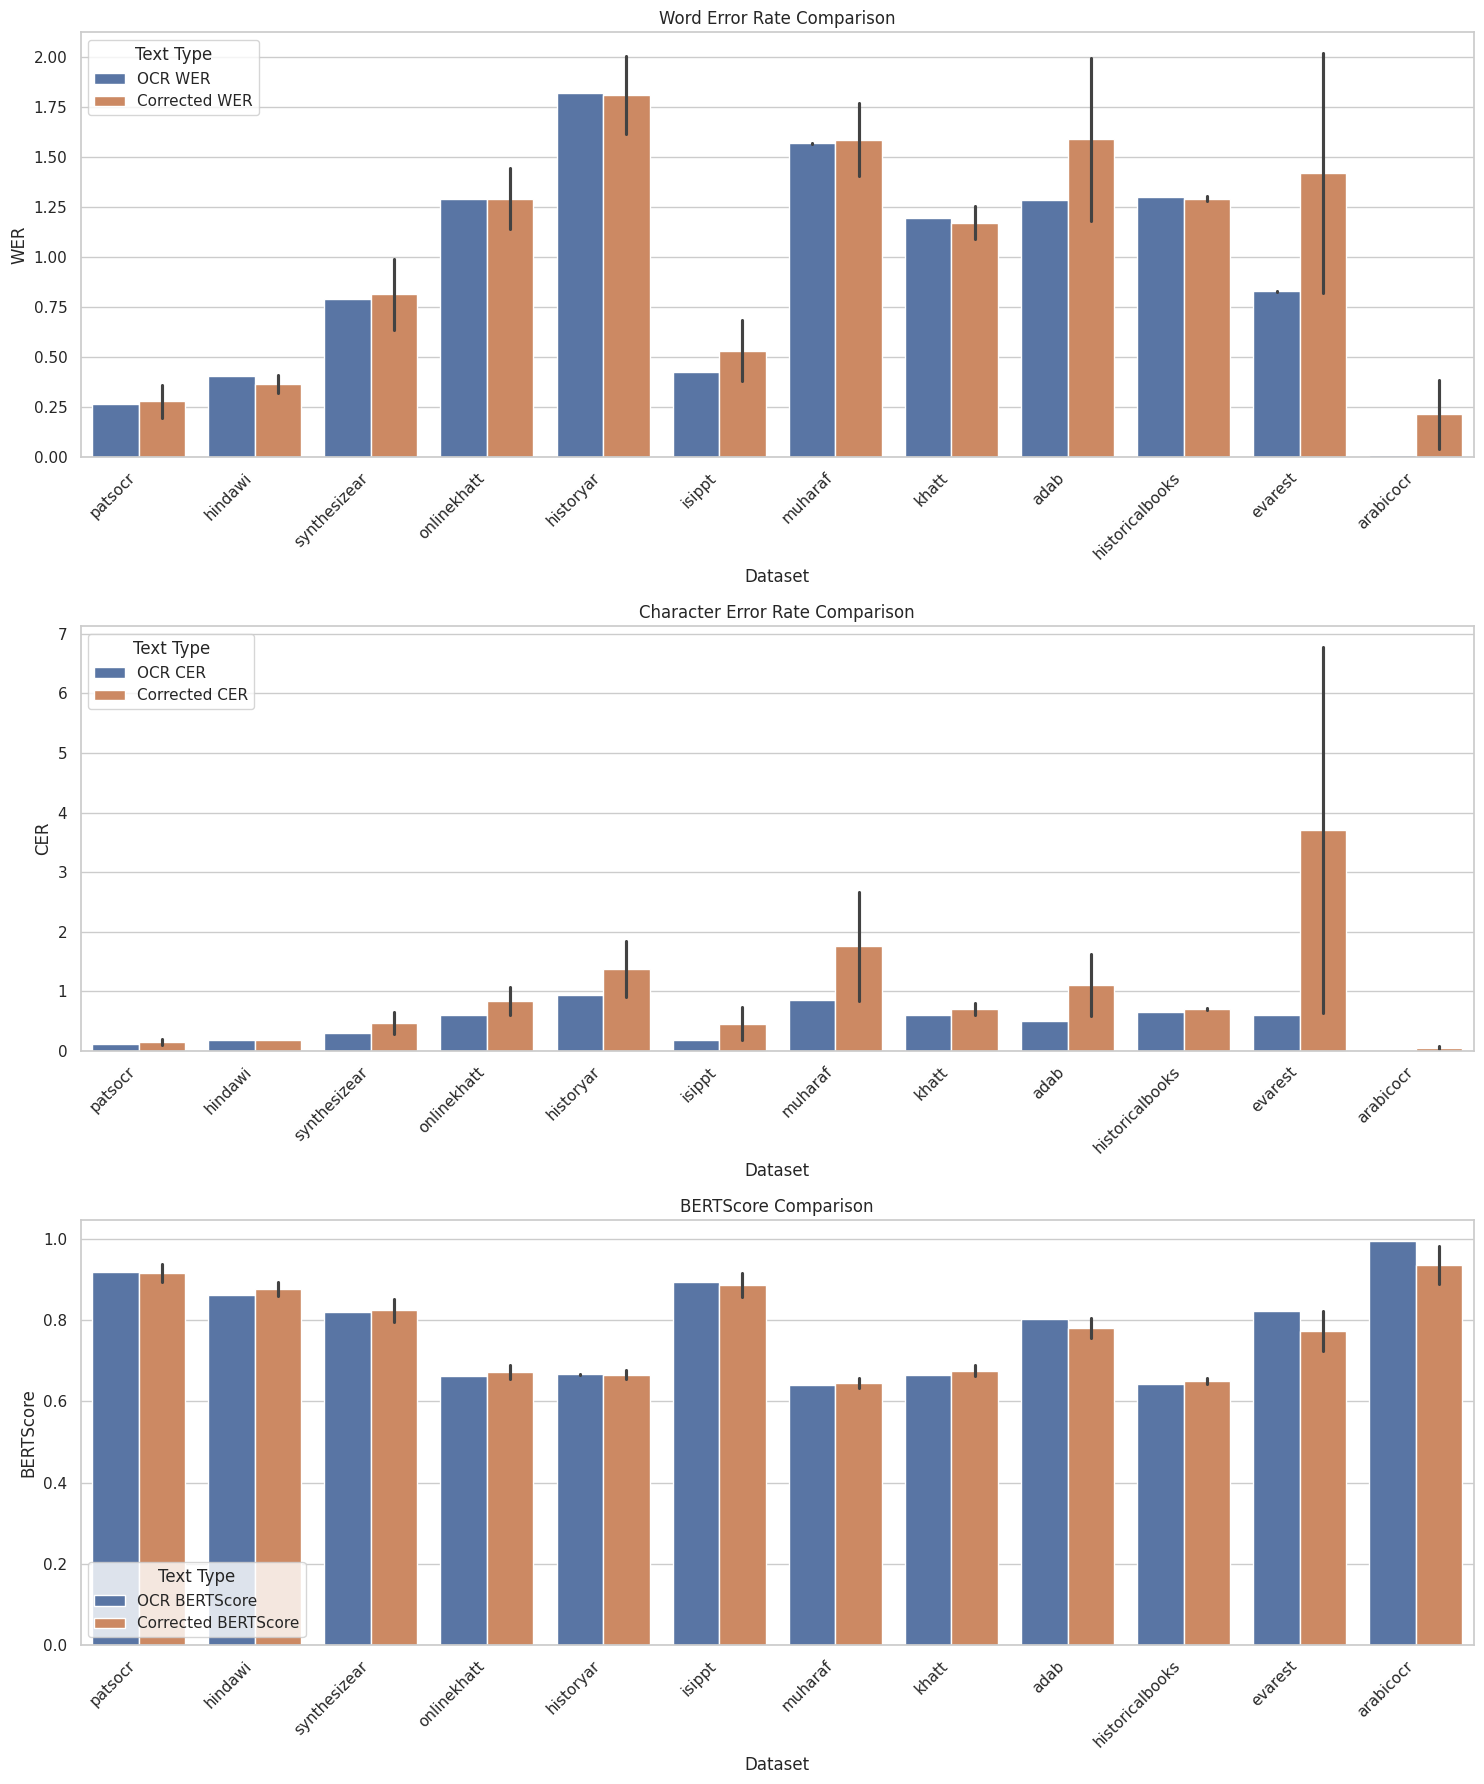

In [ ]:
# Cell 7: Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(summary_df):
    """
    Create visualizations of the results
    """
    # Set style
    sns.set(style="whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))

    # Plot WER comparison
    wer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR WER", "Corrected WER"],
        var_name="Text Type", value_name="WER"
    )
    sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0])
    axes[0].set_title("Word Error Rate Comparison")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

    # Plot CER comparison
    cer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR CER", "Corrected CER"],
        var_name="Text Type", value_name="CER"
    )
    sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1])
    axes[1].set_title("Character Error Rate Comparison")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Plot BERTScore comparison
    bertscore_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR BERTScore", "Corrected BERTScore"],
        var_name="Text Type", value_name="BERTScore"
    )
    sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2])
    axes[2].set_title("BERTScore Comparison")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(summary_df)

**Jordan dataset**

In [ ]:
# Cell 5: Run the evaluation with ain-7b to ain conversion
import os
import shutil
import glob

def process_directory_for_evaluation(source_dir, output_dir):
    """
    Process directory by copying files and replacing 'ain-7b' with 'ain' in filenames,
    then run evaluation on the processed files

    Args:
        source_dir: Source directory with original files
        output_dir: Directory to save results

    Returns:
        Dictionary containing evaluation results
    """
    # Create a temporary directory for processed files
    temp_dir = "/content/temp_processed_files"
    os.makedirs(temp_dir, exist_ok=True)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get all JSON files in the directory
    json_files = glob.glob(os.path.join(source_dir, "*.json"))
    print(f"Found {len(json_files)} JSON files in {source_dir}")

    # Process each file by copying and renaming if necessary
    for json_file in json_files:
        file_name = os.path.basename(json_file)

        # Replace 'ain-7b' with 'ain' in filename
        new_file_name = file_name.replace("ain-7b", "ain")

        # Define destination path
        dest_path = os.path.join(temp_dir, new_file_name)

        # Copy file to temporary directory
        shutil.copy2(json_file, dest_path)
        print(f"Processed {file_name} -> {new_file_name}")

    # Run evaluation on the temporary directory
    print(f"Running evaluation on processed files in {temp_dir}")
    results = evaluate_ocr_results(temp_dir, output_dir)

    # Clean up temporary directory (optional)
    # shutil.rmtree(temp_dir)

    return results

# Run the processing and evaluation
directory_path = "/content/drive/MyDrive/post_correction (1)"
output_dir = "/content/drive/MyDrive/post_correction (1)/results"

results = process_directory_for_evaluation(directory_path, output_dir)

Found 24 JSON files in /content/drive/MyDrive/post_correction (1)
Processed post_correction-synthesizear-ain-7b-gpt-4o.json -> post_correction-synthesizear-ain-gpt-4o.json
Processed post_correction-patsocr-ain-7b-gpt-4o.json -> post_correction-patsocr-ain-gpt-4o.json
Processed post_correction-historyar-ain-7b-gpt-4o.json -> post_correction-historyar-ain-gpt-4o.json
Processed post_correction-historicalbooks-ain-7b-gpt-4o.json -> post_correction-historicalbooks-ain-gpt-4o.json
Processed post_correction-adab-ain-7b-gpt-4o.json -> post_correction-adab-ain-gpt-4o.json
Processed post_correction-muharaf-ain-7b-gpt-4o.json -> post_correction-muharaf-ain-gpt-4o.json
Processed post_correction-onlinekhatt-ain-7b-gpt-4o.json -> post_correction-onlinekhatt-ain-gpt-4o.json
Processed post_correction-khatt-ain-7b-gpt-4o.json -> post_correction-khatt-ain-gpt-4o.json
Processed post_correction-isippt-ain-7b-gpt-4o.json -> post_correction-isippt-ain-gpt-4o.json
Processed post_correction-arabicocr-ain-7b-g

Processing files:   0%|          | 0/24 [00:00<?, ?it/s]

Detected language: ar
Using language 'ar' for BERTScore calculation


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Processed post_correction-khatt-ain-allam-7b.json, saved results to /content/drive/MyDrive/post_correction (1)/results/evaluation-khatt-ain-allam.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-hindawi-ain-allam-7b.json, saved results to /content/drive/MyDrive/post_correction (1)/results/evaluation-hindawi-ain-allam.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-patsocr-ain-allam-7b.json, saved results to /content/drive/MyDrive/post_correction (1)/results/evaluation-patsocr-ain-allam.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-evarest-ain-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction (1)/results/evaluation-evarest-ain-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historyar-ain-allam-7b.json, saved results to /content/drive/MyDrive/post_correction (1)/r

<ipython-input-61-09d5ff43e151>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-61-09d5ff43e151>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
<ipython-input-61-09d5ff43e151>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")


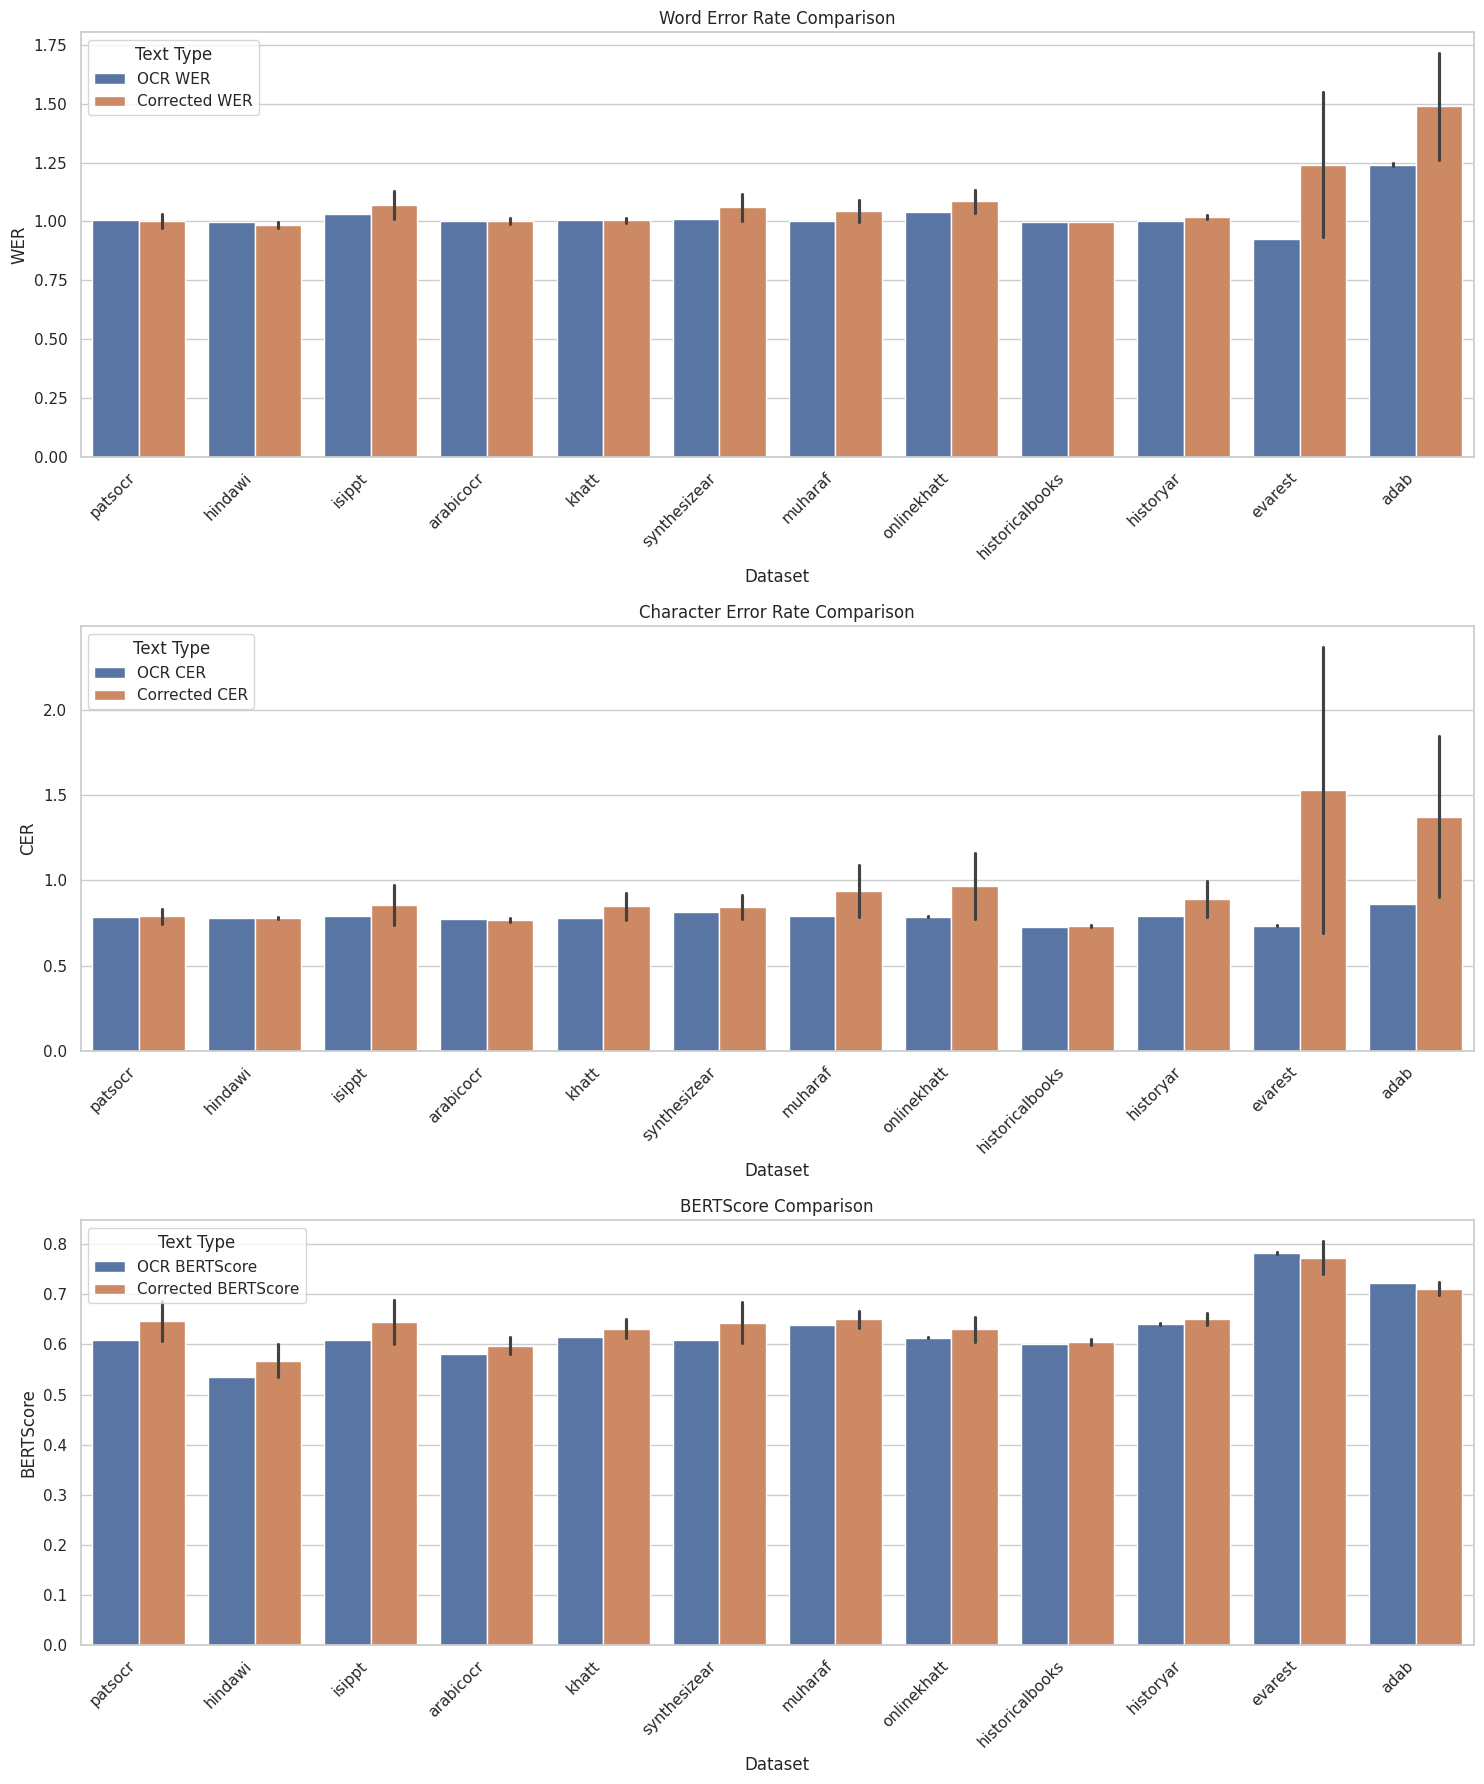

In [ ]:
# Cell 7: Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(summary_df):
    """
    Create visualizations of the results
    """
    # Set style
    sns.set(style="whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))

    # Plot WER comparison
    wer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR WER", "Corrected WER"],
        var_name="Text Type", value_name="WER"
    )
    sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0])
    axes[0].set_title("Word Error Rate Comparison")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

    # Plot CER comparison
    cer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR CER", "Corrected CER"],
        var_name="Text Type", value_name="CER"
    )
    sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1])
    axes[1].set_title("Character Error Rate Comparison")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Plot BERTScore comparison
    bertscore_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR BERTScore", "Corrected BERTScore"],
        var_name="Text Type", value_name="BERTScore"
    )
    sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2])
    axes[2].set_title("BERTScore Comparison")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(summary_df)

**Yassin Dataste**

In [ ]:
# Cell 5: Run the evaluation on your directory
# Replace with your actual directory path from Google Drive
directory_path = "/content/drive/MyDrive/post_correction (2)"
output_dir = "/content/drive/MyDrive/post_correction (2)/results"
results = evaluate_ocr_results(directory_path,output_dir)


Processing files:   0%|          | 0/24 [00:00<?, ?it/s]

Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-synthesizear-easyocr-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction (2)/results/evaluation-synthesizear-easyocr-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-patsocr-easyocr-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction (2)/results/evaluation-patsocr-easyocr-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historyar-easyocr-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction (2)/results/evaluation-historyar-easyocr-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calculation
Processed post_correction-historicalbooks-easyocr-gpt-4o.json, saved results to /content/drive/MyDrive/post_correction (2)/results/evaluation-historicalbooks-easyocr-gpt.json
Detected language: ar
Using language 'ar' for BERTScore calcul

Processed post_correction-evarest-easyocr-allam-7b.json, saved results to /content/drive/MyDrive/post_correction (2)/results/evaluation-evarest-easyocr-allam.json


<ipython-input-63-09d5ff43e151>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-63-09d5ff43e151>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
<ipython-input-63-09d5ff43e151>:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")


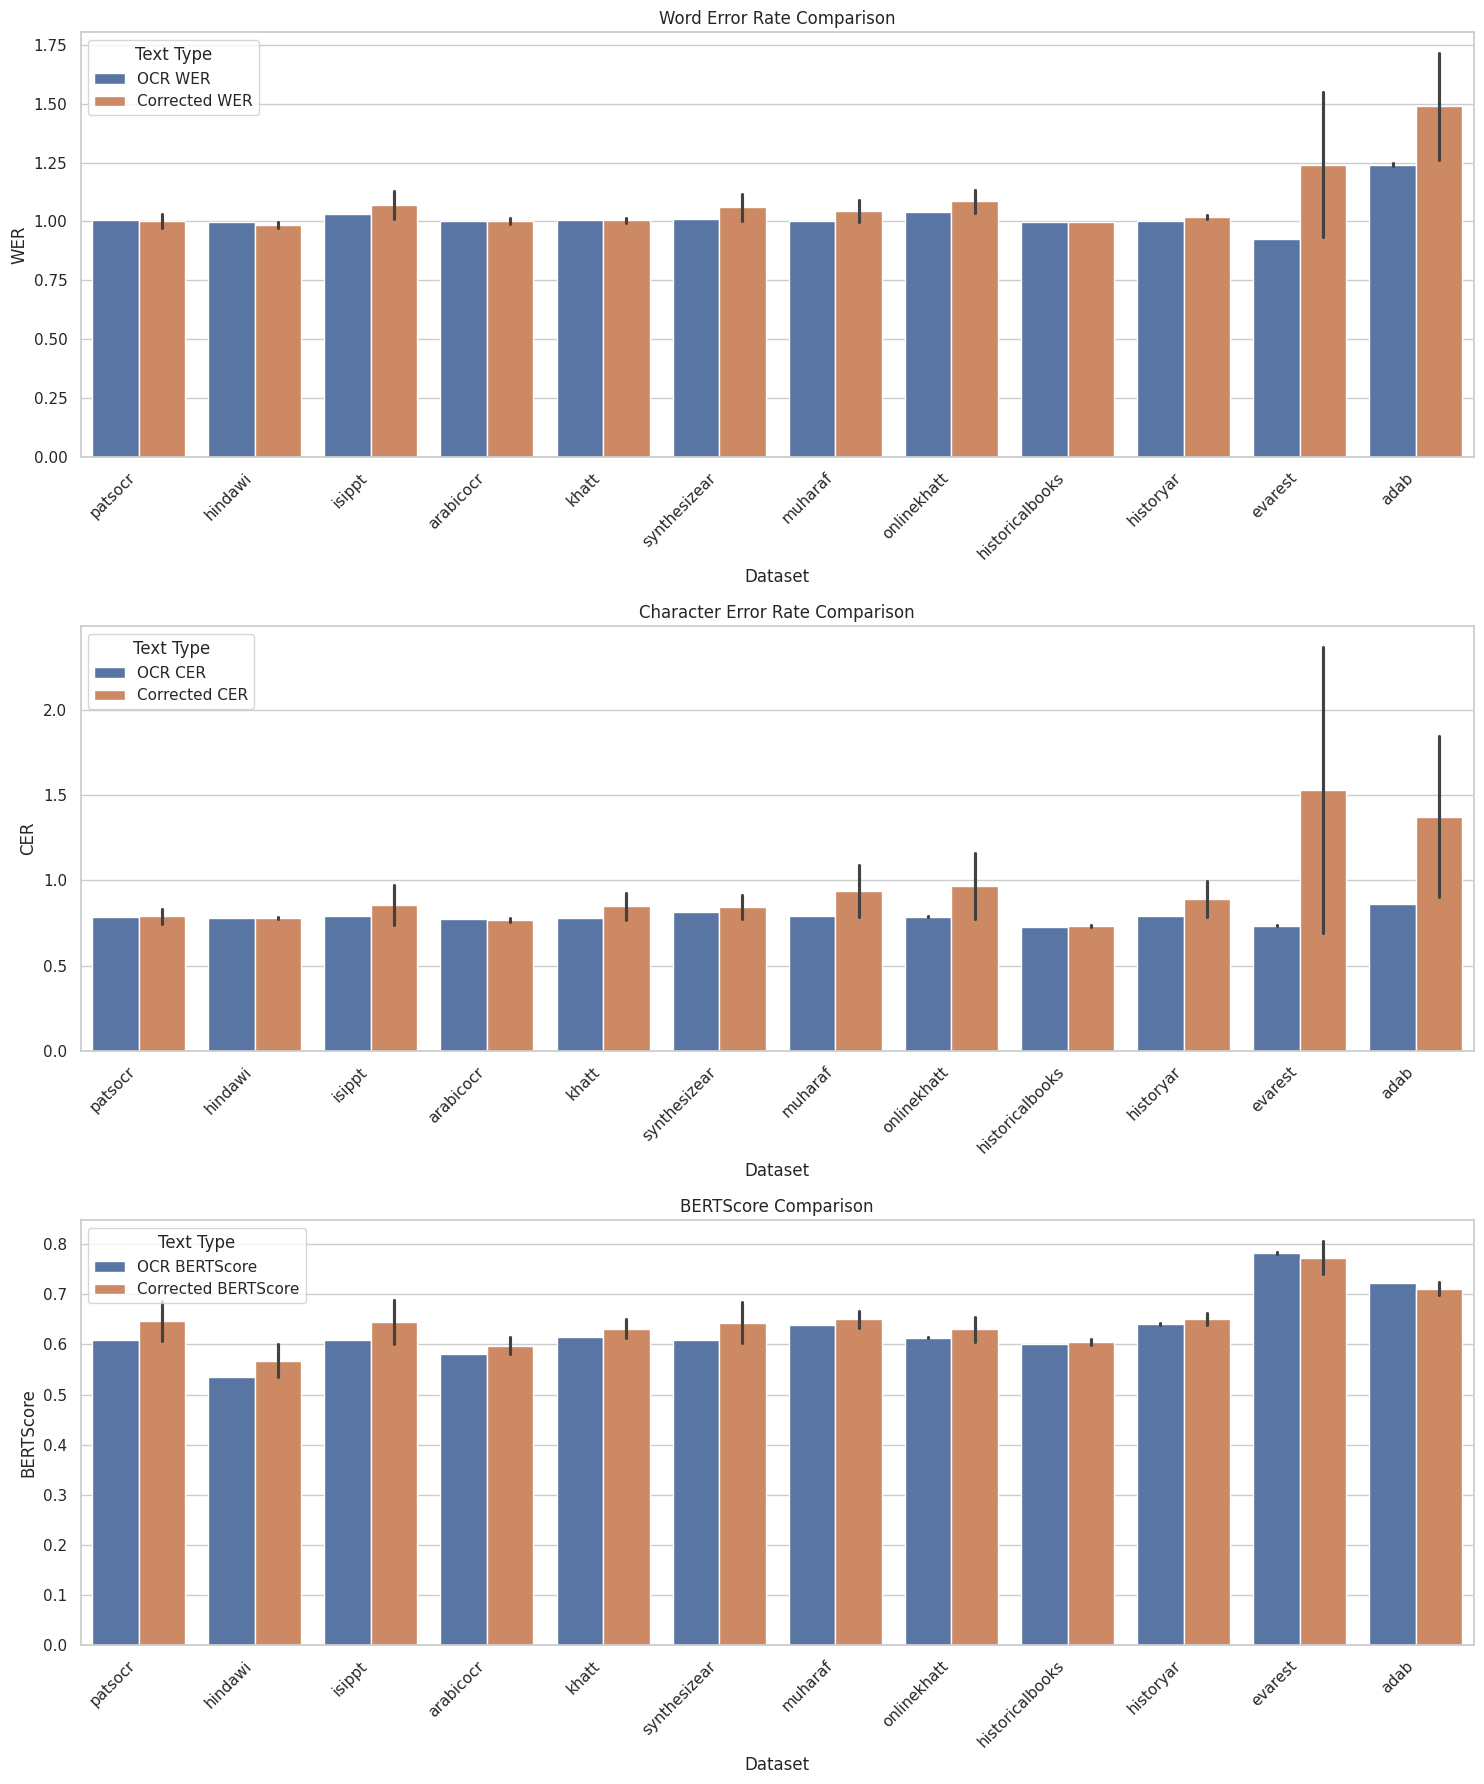

In [ ]:
# Cell 7: Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(summary_df):
    """
    Create visualizations of the results
    """
    # Set style
    sns.set(style="whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))

    # Plot WER comparison
    wer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR WER", "Corrected WER"],
        var_name="Text Type", value_name="WER"
    )
    sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0])
    axes[0].set_title("Word Error Rate Comparison")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

    # Plot CER comparison
    cer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR CER", "Corrected CER"],
        var_name="Text Type", value_name="CER"
    )
    sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1])
    axes[1].set_title("Character Error Rate Comparison")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Plot BERTScore comparison
    bertscore_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR BERTScore", "Corrected BERTScore"],
        var_name="Text Type", value_name="BERTScore"
    )
    sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2])
    axes[2].set_title("BERTScore Comparison")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(summary_df)

In [ ]:

# Cell 8: Optional - Visualize results
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(summary_df):
    """
    Create visualizations of the results
    """
    # Set style
    sns.set(style="whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))

    # Plot WER comparison
    wer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR WER", "Corrected WER"],
        var_name="Text Type", value_name="WER"
    )
    sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0])
    axes[0].set_title("Word Error Rate Comparison")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

    # Plot CER comparison
    cer_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR CER", "Corrected CER"],
        var_name="Text Type", value_name="CER"
    )
    sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1])
    axes[1].set_title("Character Error Rate Comparison")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Plot BERTScore comparison
    bertscore_data = summary_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR BERTScore", "Corrected BERTScore"],
        var_name="Text Type", value_name="BERTScore"
    )
    sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2])
    axes[2].set_title("BERTScore Comparison")
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(summary_df)

NameError: name 'summary_df' is not defined

<ipython-input-14-f0b7a60ff293>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-14-f0b7a60ff293>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
<ipython-input-14-f0b7a60ff293>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")


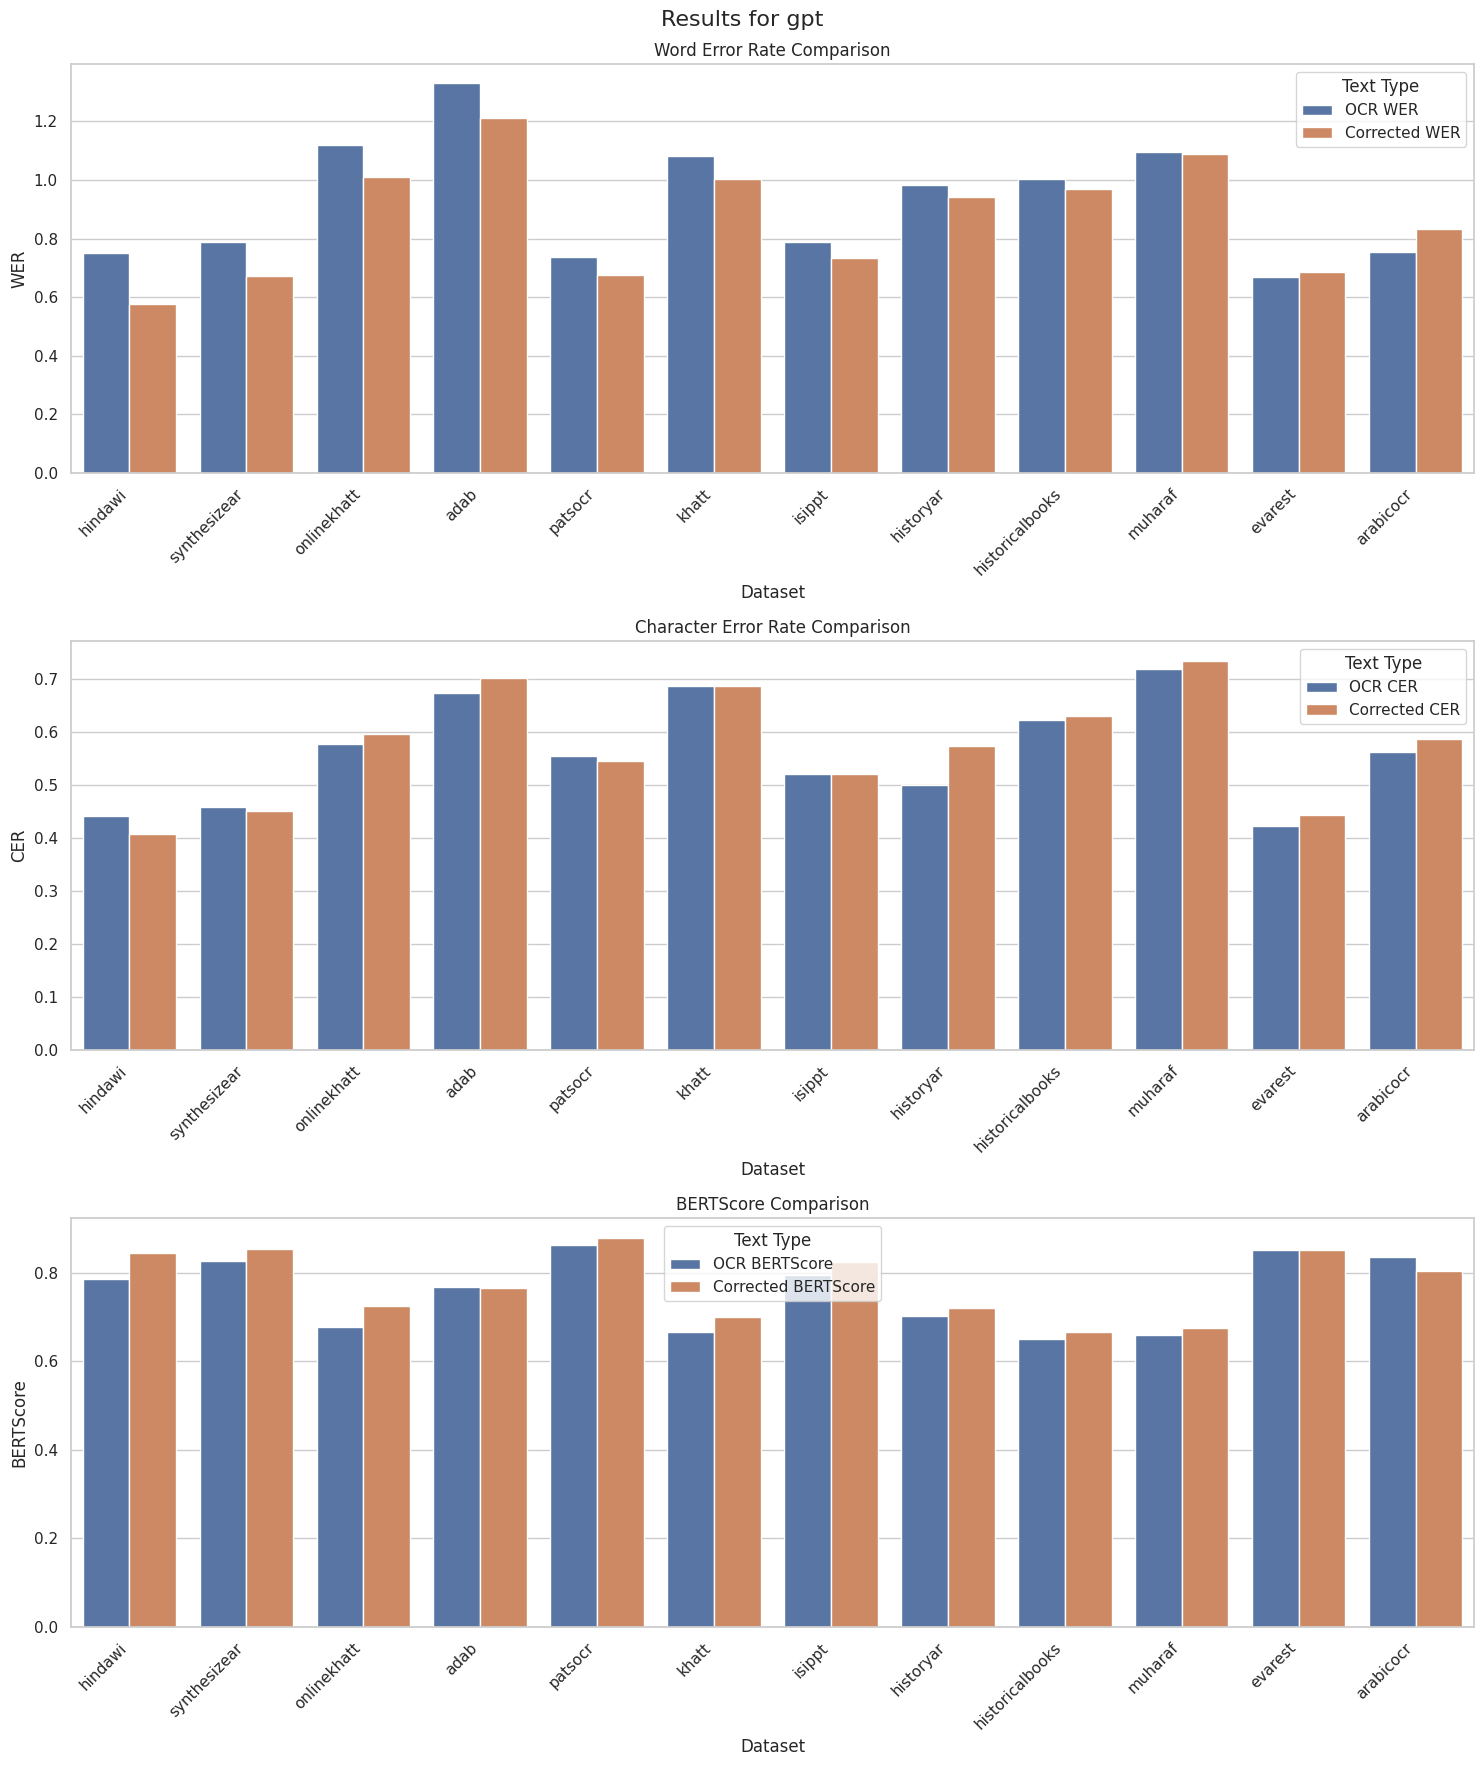

<ipython-input-14-f0b7a60ff293>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-14-f0b7a60ff293>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
<ipython-input-14-f0b7a60ff293>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")


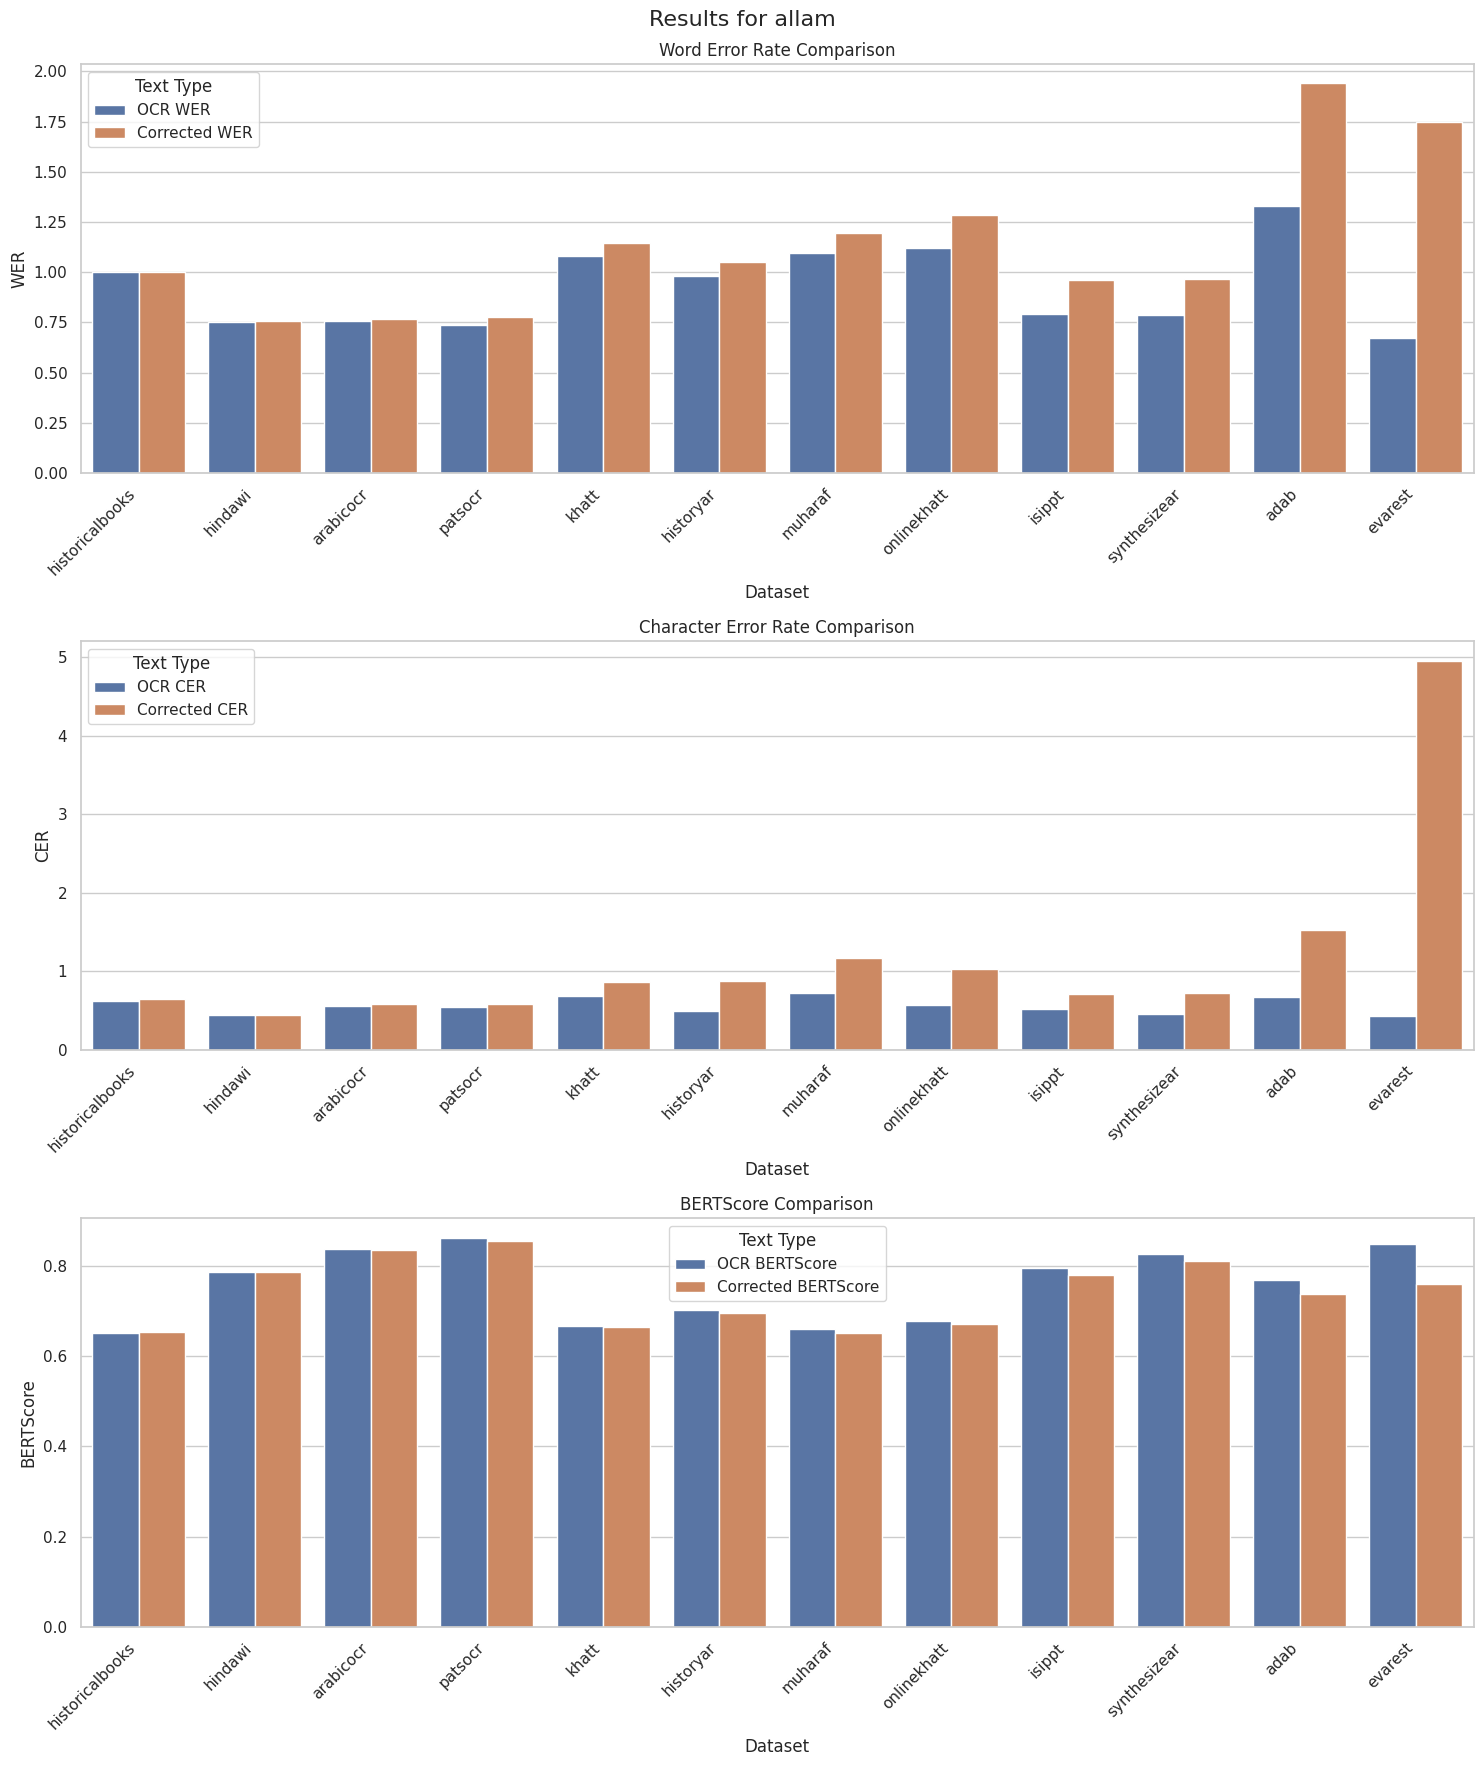

In [ ]:
# Cell 8: Optional - Visualize results for different LLMs separately with bar charts
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results_by_llm_with_barcharts(summary_df):
    """
    Create separate bar chart visualizations for each LLM type
    """
    # Set style
    sns.set(style="whitegrid")

    # Get unique LLM types
    llm_types = summary_df['LLM'].unique()

    # Create separate visualizations for each LLM type
    for llm in llm_types:
        # Filter data for this LLM
        llm_df = summary_df[summary_df['LLM'] == llm]

        # Create a figure with multiple subplots
        fig, axes = plt.subplots(3, 1, figsize=(15, 18))
        fig.suptitle(f"Results for {llm}", fontsize=16)

        # Plot WER comparison
        wer_data = llm_df.melt(
            id_vars=["Dataset", "OCR"],
            value_vars=["OCR WER", "Corrected WER"],
            var_name="Text Type", value_name="WER"
        )
        sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0], errorbar='ci', capsize=0.1)
        axes[0].set_title("Word Error Rate Comparison")
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

        # Plot CER comparison
        cer_data = llm_df.melt(
            id_vars=["Dataset", "OCR"],
            value_vars=["OCR CER", "Corrected CER"],
            var_name="Text Type", value_name="CER"
        )
        sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1], errorbar='ci', capsize=0.1)
        axes[1].set_title("Character Error Rate Comparison")
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

        # Plot BERTScore comparison
        bertscore_data = llm_df.melt(
            id_vars=["Dataset", "OCR"],
            value_vars=["OCR BERTScore", "Corrected BERTScore"],
            var_name="Text Type", value_name="BERTScore"
        )
        sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2], errorbar='ci', capsize=0.1)
        axes[2].set_title("BERTScore Comparison")
        axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)  # Adjust for the suptitle
        plt.savefig(f"Results_for_{llm}.png")
        plt.show()

# Visualize results for each LLM separately
visualize_results_by_llm_with_barcharts(summary_df)

**Visualization**

Mounted at /content/drive
Found 96 JSON files in /content/drive/MyDrive/Righting-Writing-eval-results
Created DataFrame with 96 rows
Unique LLM models: ['gpt' 'allam']
Unique datasets: ['synthesizear' 'patsocr' 'historyar' 'historicalbooks' 'adab' 'muharaf'
 'onlinekhatt' 'khatt' 'arabicocr' 'isippt' 'hindawi' 'evarest']
Unique OCR models: ['paddle' 'tesseract' 'easyocr' 'ain']
Saved visualization to visualizations/results_for_gpt.png


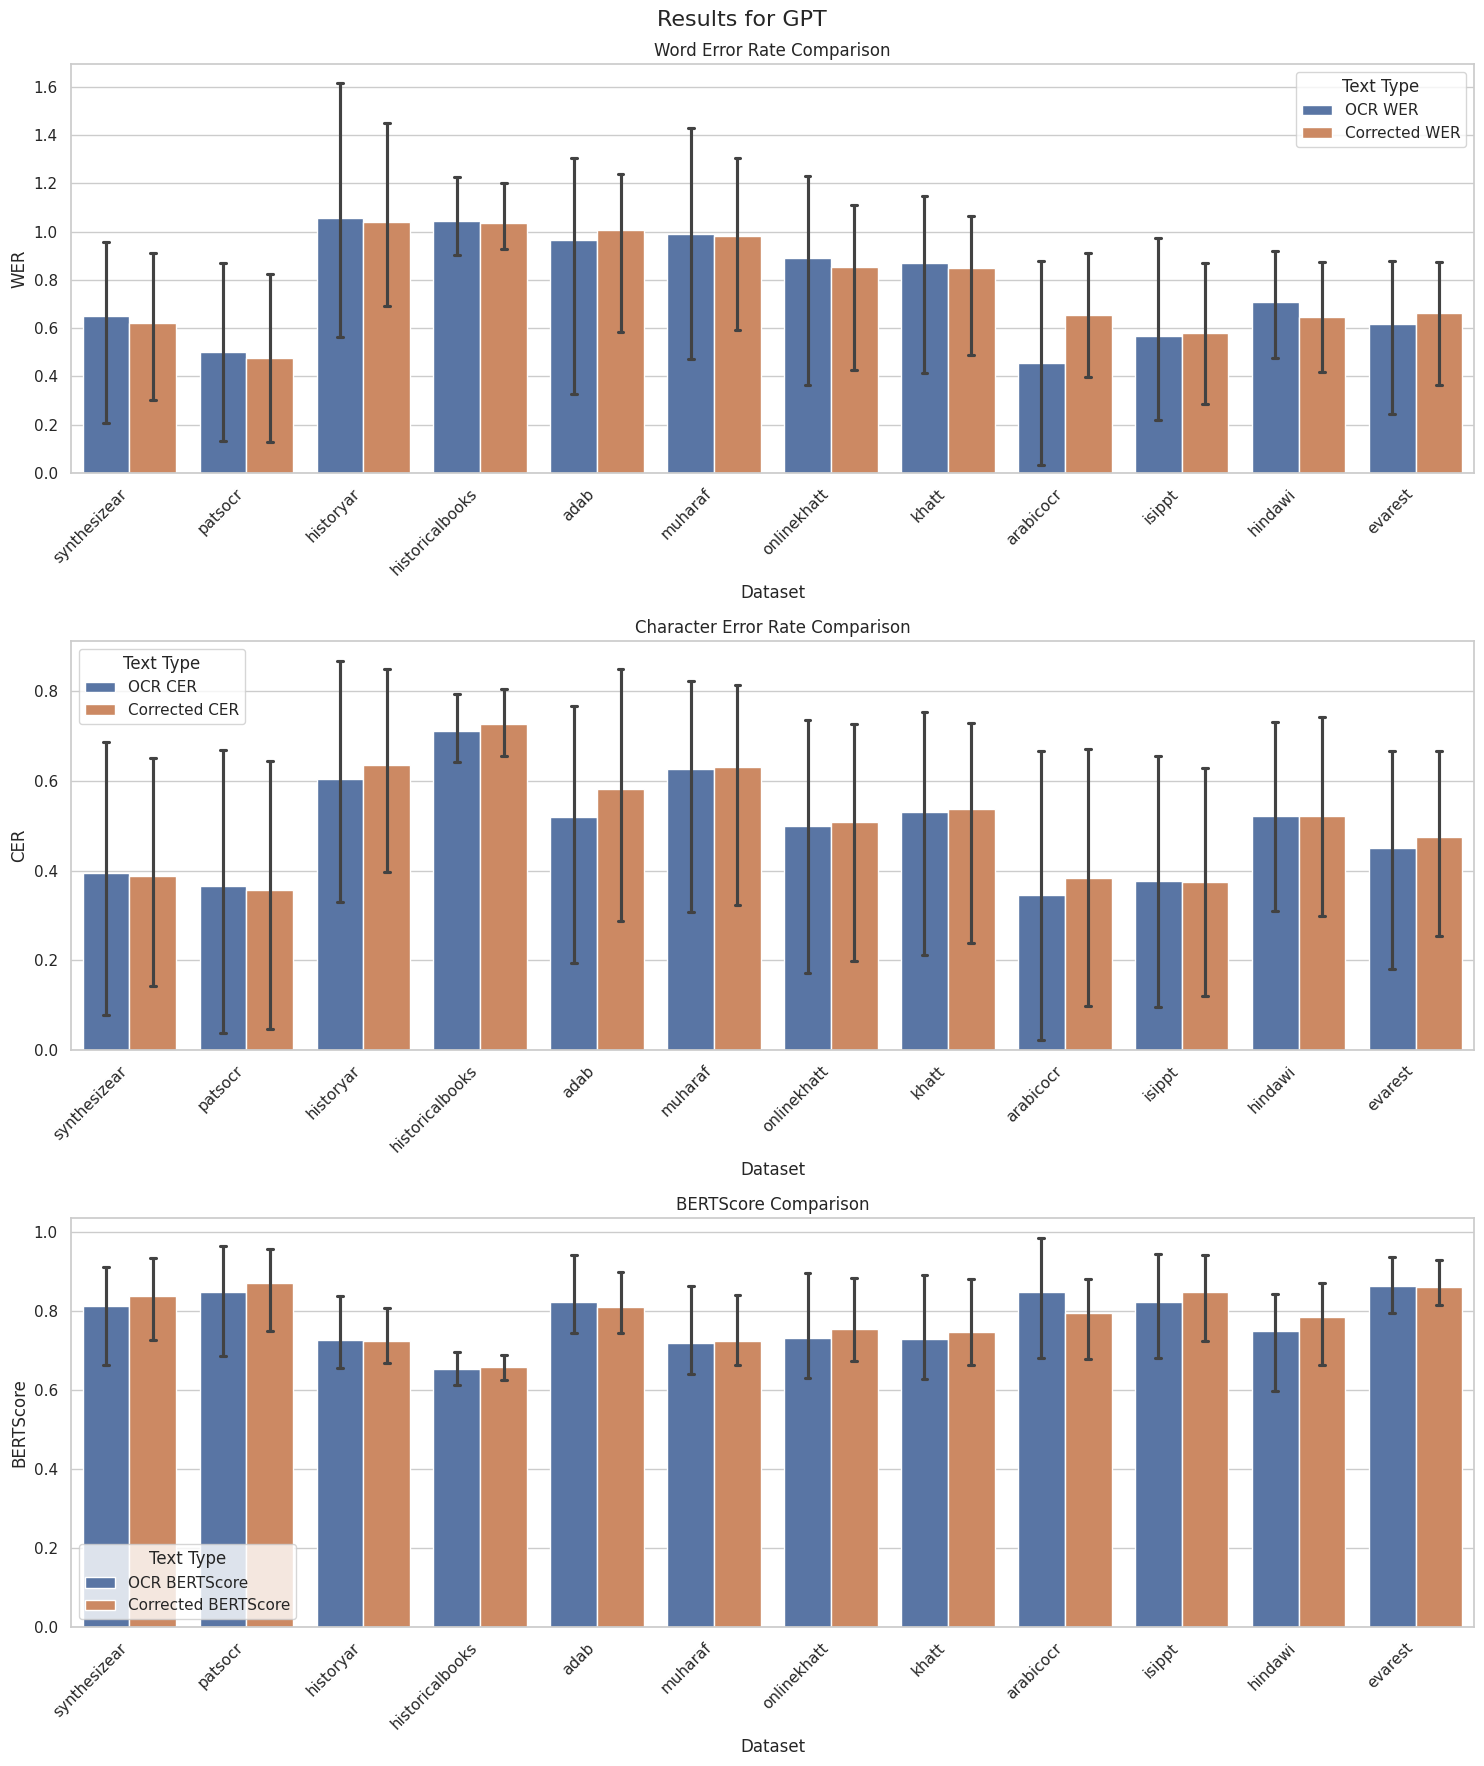

Saved visualization to visualizations/results_for_allam.png


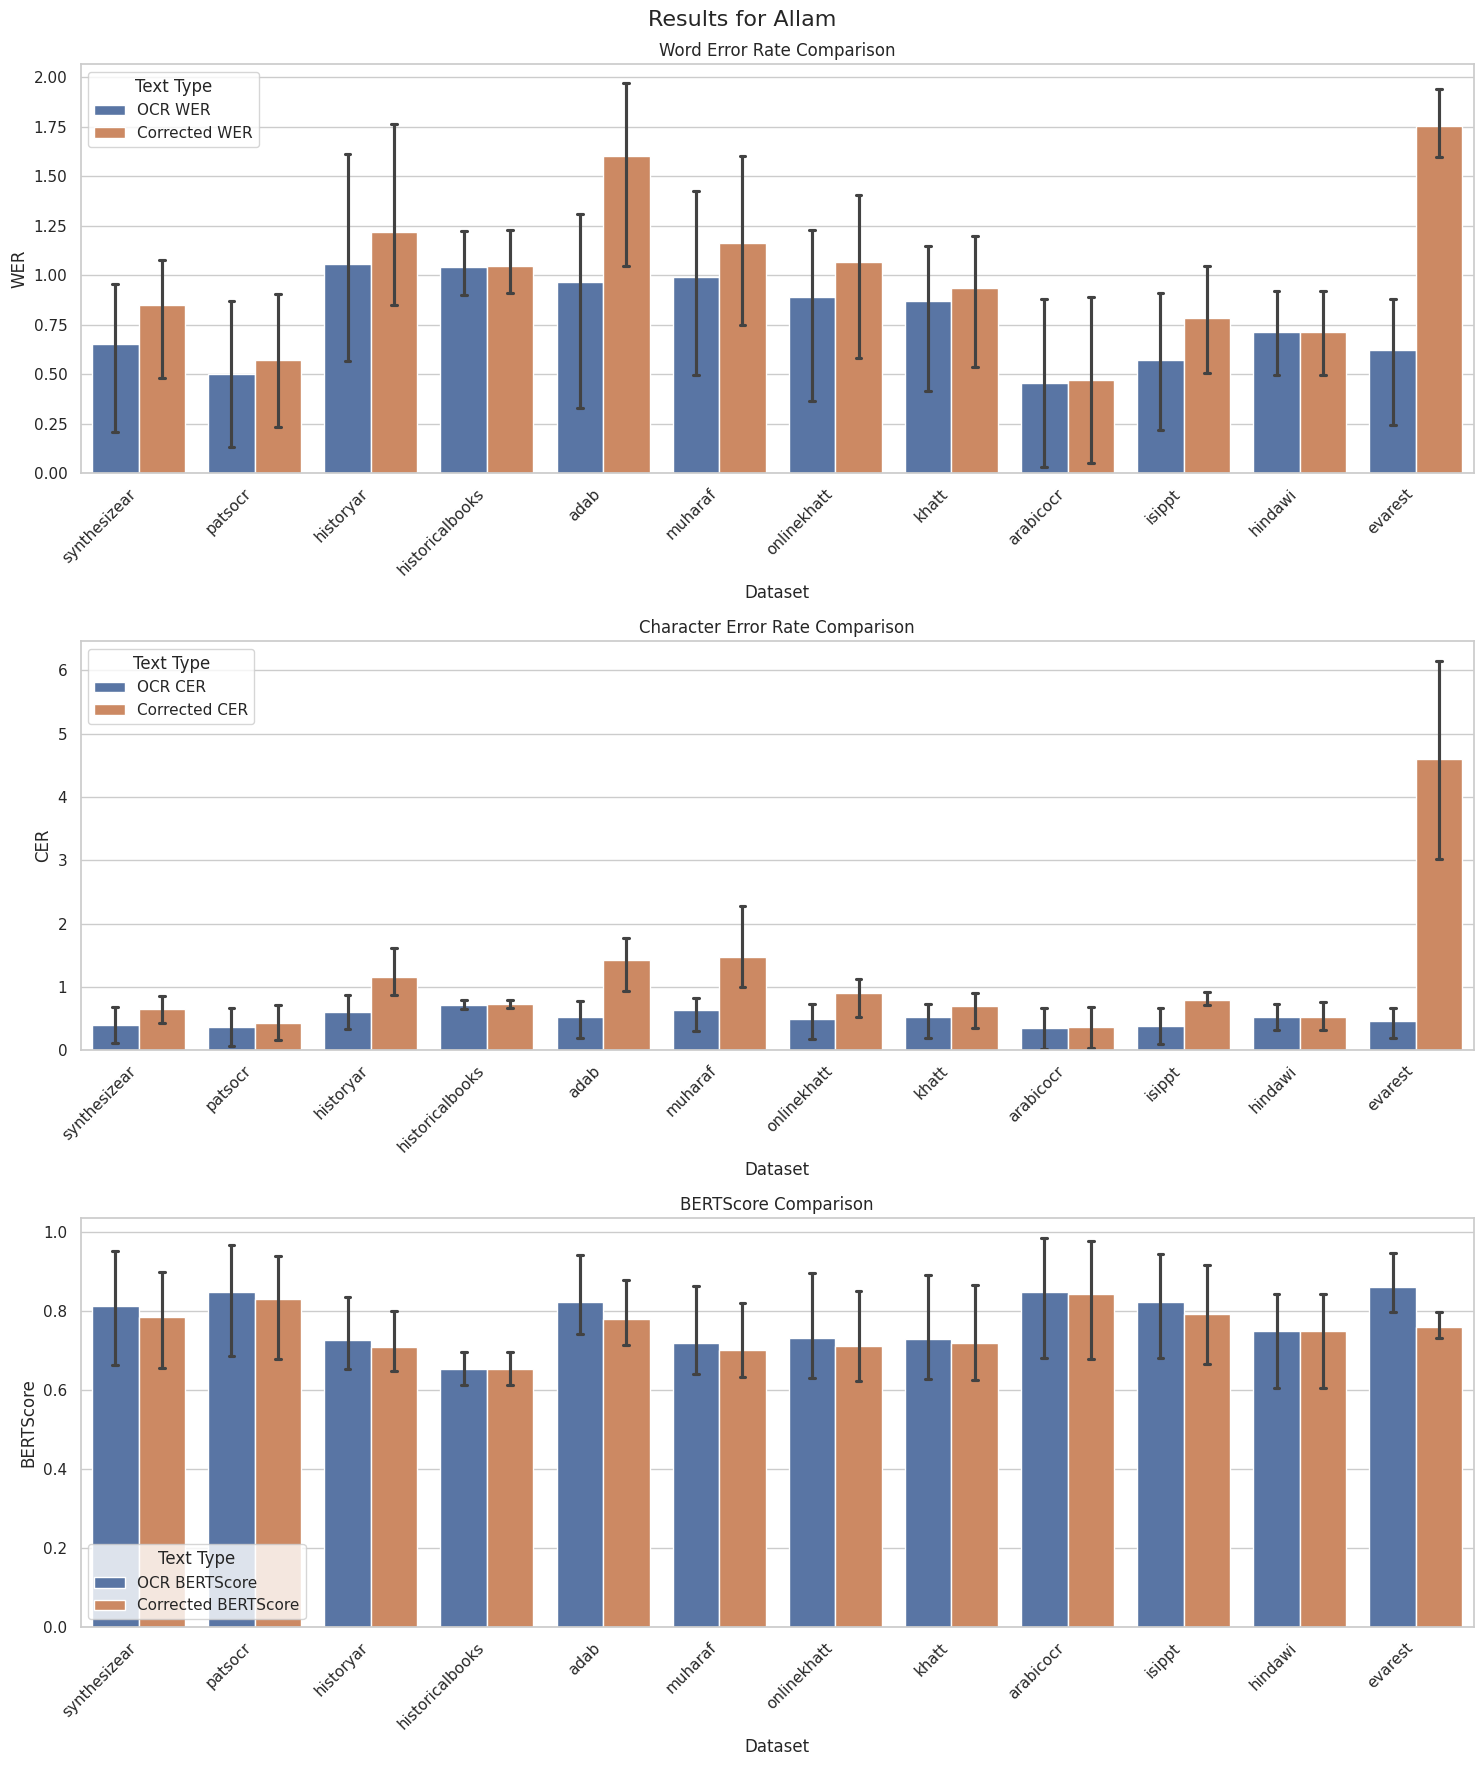


Improvement Summary Table:
         Dataset        OCR LLM_Type  WER Improvement %  CER Improvement %  \
0           adab        ain    Allam           -7350.00           -1911.72   
1           adab        ain      GPT           -3658.33            -331.12   
2           adab    easyocr    Allam             -45.89            -127.70   
3           adab    easyocr      GPT               8.77              -4.08   
4           adab     paddle    Allam             -37.69            -114.05   
..           ...        ...      ...                ...                ...   
91  synthesizear    easyocr      GPT              14.81               1.91   
92  synthesizear     paddle    Allam             -10.32             -12.59   
93  synthesizear     paddle      GPT               0.79               5.22   
94  synthesizear  tesseract    Allam             -25.93            -114.82   
95  synthesizear  tesseract      GPT              19.19               5.14   

    BERTScore Improvement %  
0    

In [ ]:
# Cell 1: Import necessary libraries
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import numpy as np

# Cell 2: Mount Google Drive
drive.mount('/content/drive')

# Cell 3: Load evaluation results from JSON files
def load_evaluation_results(results_dir):
    """
    Load evaluation results from JSON files in the specified directory

    Args:
        results_dir: Path to directory containing evaluation result JSON files

    Returns:
        DataFrame containing summary data
    """
    # Get all JSON files in the directory
    json_files = glob.glob(os.path.join(results_dir, "*.json"))
    print(f"Found {len(json_files)} JSON files in {results_dir}")

    # Collect data for summary dataframe
    summary_data = []

    for json_file in json_files:
        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                results = json.load(f)

            # Extract components from file name
            file_name = os.path.basename(json_file)
            parts = file_name.split('-')

            if len(parts) >= 4:
                # Extract dataset, OCR model, and LLM from filename
                dataset = parts[1]
                ocr_model = parts[2]

                # Special handling for LLM names with hyphens
                if len(parts) == 4:
                    # Normal case: evaluation-dataset-ocr-llm.json
                    llm = parts[3].split('.')[0]
                elif len(parts) > 4:
                    # Case with hyphen in LLM name: evaluation-dataset-ocr-ain-7b.json
                    llm = '-'.join(parts[3:]).split('.')[0]

                # Clean up model names to remove duplicates
                llm = llm.replace(' (1)', '')

                # Get average results
                avg_results = results.get("avg_results", {})

                # Skip empty results
                if not avg_results:
                    print(f"Skipping {file_name}: No average results found")
                    continue

                # Calculate improvement percentages
                wer_improvement = ((avg_results.get("ocr_wer", 0) - avg_results.get("corrected_wer", 0)) / avg_results.get("ocr_wer", 1)) * 100 if avg_results.get("ocr_wer", 0) > 0 else 0
                cer_improvement = ((avg_results.get("ocr_cer", 0) - avg_results.get("corrected_cer", 0)) / avg_results.get("ocr_cer", 1)) * 100 if avg_results.get("ocr_cer", 0) > 0 else 0
                bertscore_improvement = ((avg_results.get("corrected_bertscore_f1", 0) - avg_results.get("ocr_bertscore_f1", 0)) / avg_results.get("ocr_bertscore_f1", 1)) * 100 if avg_results.get("ocr_bertscore_f1", 0) > 0 else 0

                # Add to summary data
                summary_data.append({
                    "Dataset": dataset,
                    "OCR": ocr_model,
                    "LLM": llm,
                    "OCR WER": avg_results.get("ocr_wer", 0),
                    "Corrected WER": avg_results.get("corrected_wer", 0),
                    "WER Improvement %": wer_improvement,
                    "OCR CER": avg_results.get("ocr_cer", 0),
                    "Corrected CER": avg_results.get("corrected_cer", 0),
                    "CER Improvement %": cer_improvement,
                    "OCR BERTScore": avg_results.get("ocr_bertscore_f1", 0),
                    "Corrected BERTScore": avg_results.get("corrected_bertscore_f1", 0),
                    "BERTScore Improvement %": bertscore_improvement
                })
        except Exception as e:
            print(f"Error processing {json_file}: {e}")

    # Create DataFrame
    if summary_data:
        df = pd.DataFrame(summary_data)
        print(f"Created DataFrame with {len(df)} rows")
        # Print unique LLM models to verify ain-7b is included
        print(f"Unique LLM models: {df['LLM'].unique()}")
        # Print unique datasets
        print(f"Unique datasets: {df['Dataset'].unique()}")
        # Print unique OCR models
        print(f"Unique OCR models: {df['OCR'].unique()}")
        return df
    else:
        print("No data could be loaded from JSON files")
        return pd.DataFrame()

# Cell 4: Create visualizations for each LLM category
def create_visualizations(df):
    """
    Create visualizations by LLM category

    Args:
        df: DataFrame containing evaluation results
    """
    # Set style
    sns.set(style="whitegrid")

    # Create output directory for visualizations
    output_dir = "visualizations"
    os.makedirs(output_dir, exist_ok=True)

    # Create visualizations for GPT models
    create_llm_type_visualization(df, "gpt", output_dir)

    # Create visualizations for Allam models (including ain-7b)
    create_llm_type_visualization(df, "allam", output_dir)

def create_llm_type_visualization(df, llm_type_str, output_dir):
    """
    Create visualization for a specific LLM type, grouped by dataset

    Args:
        df: DataFrame with all evaluation results
        llm_type_str: String to match LLM type (e.g., "gpt" or "allam")
        output_dir: Directory to save visualizations
    """
    # Filter for the LLM type
    if llm_type_str.lower() == "gpt":
        llm_df = df[df['LLM'].str.contains('gpt', case=False)]
        llm_title = "GPT"
    elif llm_type_str.lower() == "allam":
        # Use boolean OR to match both "allam" and "ain-7b"
        llm_df = df[(df['LLM'].str.contains('allam', case=False)) |
                    (df['LLM'].str.contains('ain', case=False))]
        llm_title = "Allam"
    else:
        llm_df = df  # Use all data if no specific type
        llm_title = "All Models"

    # Skip if no data for this LLM type
    if llm_df.empty:
        print(f"No {llm_title} model data found")
        return

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))
    fig.suptitle(f"Results for {llm_title}", fontsize=16)

    # Plot WER comparison
    wer_data = llm_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR WER", "Corrected WER"],
        var_name="Text Type", value_name="WER"
    )
    sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0], errorbar='ci', capsize=0.1)
    axes[0].set_title("Word Error Rate Comparison")
    # Fix ticklabels warning by setting ticks first
    axes[0].set_xticks(range(len(wer_data['Dataset'].unique())))
    axes[0].set_xticklabels(wer_data['Dataset'].unique(), rotation=45, ha="right")

    # Plot CER comparison
    cer_data = llm_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR CER", "Corrected CER"],
        var_name="Text Type", value_name="CER"
    )
    sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1], errorbar='ci', capsize=0.1)
    axes[1].set_title("Character Error Rate Comparison")
    # Fix ticklabels warning
    axes[1].set_xticks(range(len(cer_data['Dataset'].unique())))
    axes[1].set_xticklabels(cer_data['Dataset'].unique(), rotation=45, ha="right")

    # Plot BERTScore comparison
    bertscore_data = llm_df.melt(
        id_vars=["Dataset", "OCR", "LLM"],
        value_vars=["OCR BERTScore", "Corrected BERTScore"],
        var_name="Text Type", value_name="BERTScore"
    )
    sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2], errorbar='ci', capsize=0.1)
    axes[2].set_title("BERTScore Comparison")
    # Fix ticklabels warning
    axes[2].set_xticks(range(len(bertscore_data['Dataset'].unique())))
    axes[2].set_xticklabels(bertscore_data['Dataset'].unique(), rotation=45, ha="right")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for the suptitle

    # Save visualization
    filename = f"results_for_{llm_type_str.lower()}.png"
    file_path = os.path.join(output_dir, filename)
    plt.savefig(file_path, dpi=300)
    print(f"Saved visualization to {file_path}")
    plt.show()

# Cell 5: Execute the code to load and visualize results
# Load evaluation results
results_dir = "/content/drive/MyDrive/Righting-Writing-eval-results"
df = load_evaluation_results(results_dir)

# Create visualizations
if not df.empty:
    create_visualizations(df)
else:
    print("Cannot create visualizations: No data available")

# Cell 6: Create summary table of improvement percentages
def create_improvement_summary(df):
    """
    Create a summary table of improvement percentages for each dataset, OCR, and LLM
    """
    if df.empty:
        print("No data available for summary table")
        return

    # Group by LLM type for summary
    df['LLM_Type'] = df['LLM'].apply(lambda x: 'GPT' if 'gpt' in x.lower() else ('Allam' if 'allam' in x.lower() or 'ain' in x.lower() else 'Other'))

    # Group by Dataset, OCR, and LLM_Type to calculate mean improvement percentages
    improvement_summary = df.groupby(['Dataset', 'OCR', 'LLM_Type']).agg({
        'WER Improvement %': 'mean',
        'CER Improvement %': 'mean',
        'BERTScore Improvement %': 'mean'
    }).reset_index()

    # Sort by Dataset, OCR, and LLM_Type
    improvement_summary = improvement_summary.sort_values(['Dataset', 'OCR', 'LLM_Type'])

    # Round improvement percentages to 2 decimal places
    improvement_summary['WER Improvement %'] = improvement_summary['WER Improvement %'].round(2)
    improvement_summary['CER Improvement %'] = improvement_summary['CER Improvement %'].round(2)
    improvement_summary['BERTScore Improvement %'] = improvement_summary['BERTScore Improvement %'].round(2)

    print("\nImprovement Summary Table:")
    print(improvement_summary)

    # Save summary table to CSV
    improvement_summary.to_csv("improvement_summary.csv", index=False)
    print("Saved improvement summary to improvement_summary.csv")

    return improvement_summary

# Execute summary table creation
if not df.empty:
    improvement_summary = create_improvement_summary(df)


TESSERACT Statistics:
  Number of data points: 6790
  Text length range: 1 - 1616
  CER improvement range: -700.00% - 200.00%
  Average CER improvement: -0.99%

EASYOCR Statistics:
  Number of data points: 6586
  Text length range: 1 - 1573
  CER improvement range: -240.00% - 66.67%
  Average CER improvement: -0.70%

AIN Statistics:
  Number of data points: 7112
  Text length range: 1 - 386
  CER improvement range: -12800.00% - 919.44%
  Average CER improvement: -20.79%

PADDLE Statistics:
  Number of data points: 6006
  Text length range: 1 - 1477
  CER improvement range: -300.00% - 100.00%
  Average CER improvement: 2.92%

Saved visualization to visualizations/text_length_vs_cer_improvement_by_ocr.png


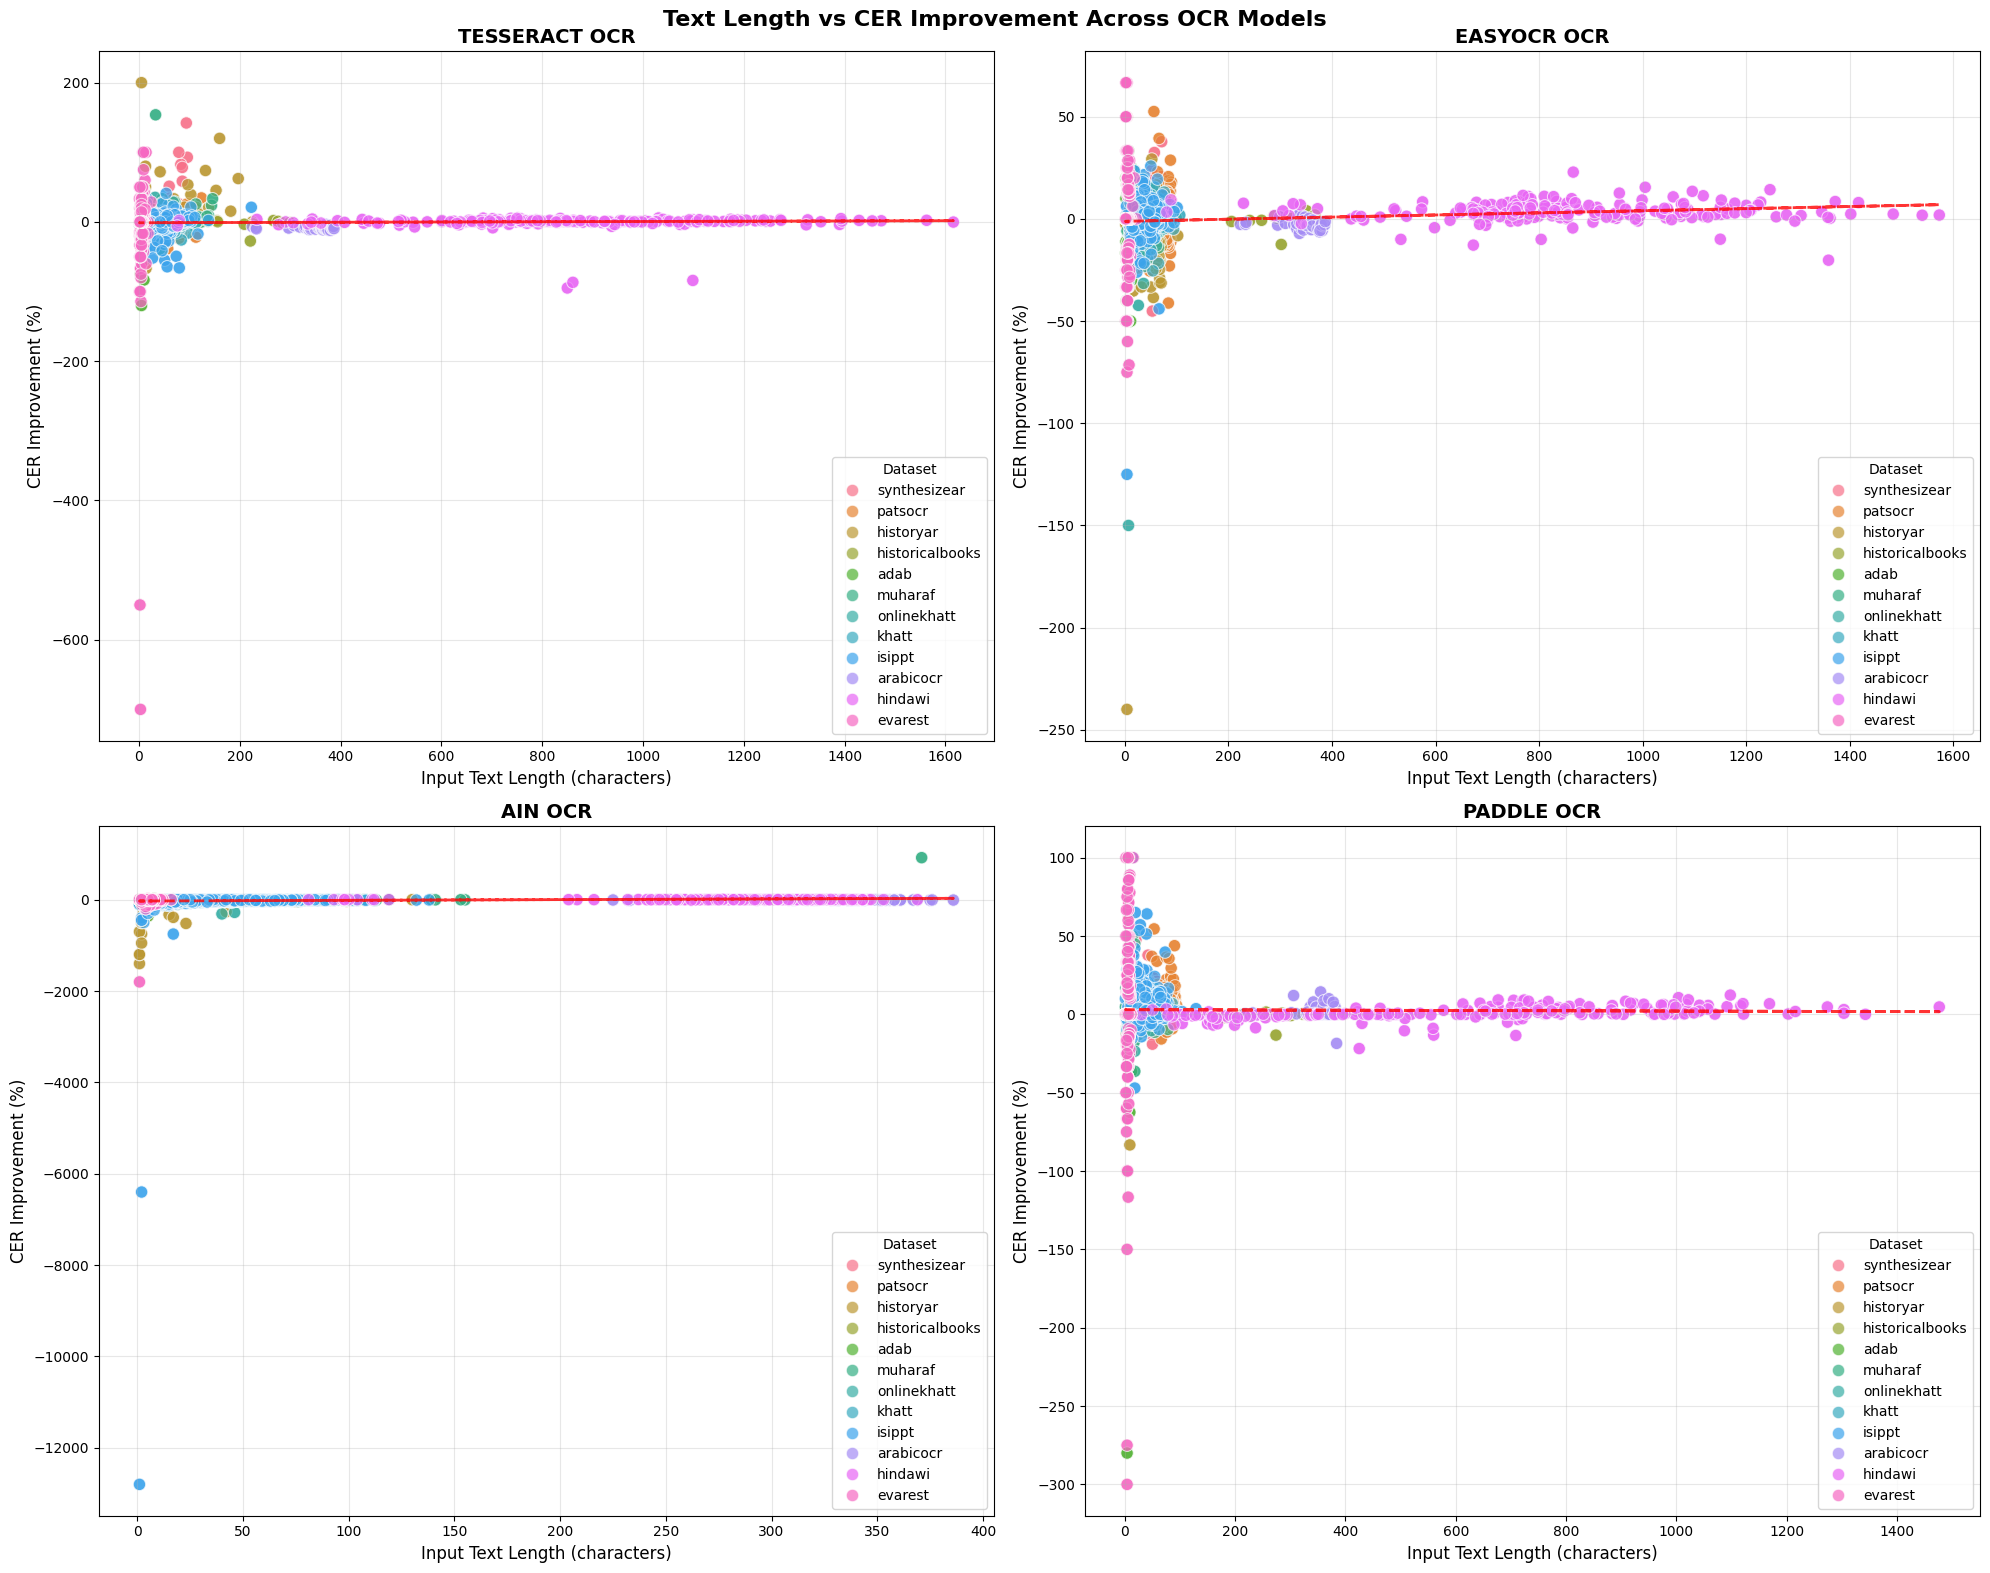

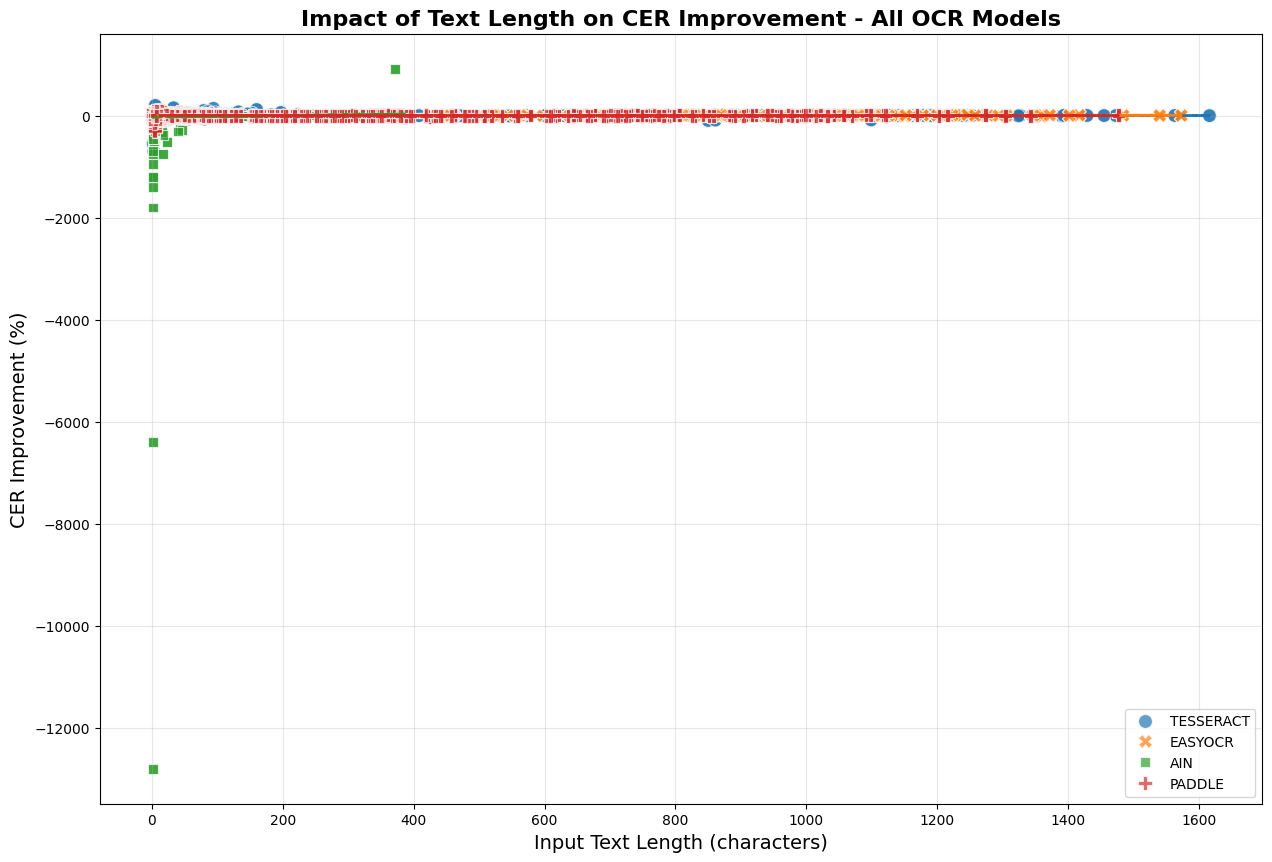

In [11]:
# Cell: Create visualization for text length vs CER improvement - Multiple directories version
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
import numpy as np

def create_length_vs_improvement_visualization_multiple_dirs(ocr_document_dirs, eval_results_dir):
    """
    Create a visualization showing the relationship between input text length
    and CER improvement across different OCR models and datasets

    Args:
        ocr_document_dirs: Dictionary mapping OCR model names to their document directories
        eval_results_dir: Directory containing evaluation results
    """
    # Ensure output directory exists
    output_dir = "visualizations"
    os.makedirs(output_dir, exist_ok=True)

    # Define the 4 OCR models
    ocr_models = ['tesseract', 'easyocr', 'ain', 'paddle']

    # Dictionary to store data for each OCR model
    ocr_data = {ocr: {
        'lengths': [],
        'cer_improvements': [],
        'datasets': [],
        'ocr_cers': [],
        'corrected_cers': []
    } for ocr in ocr_models}

    # Process each OCR model's documents and evaluation results
    for ocr_model in ocr_models:
        if ocr_model not in ocr_document_dirs:
            print(f"No document directory specified for {ocr_model}")
            continue

        doc_dir = ocr_document_dirs[ocr_model]

        # Get all document files for this OCR model
        document_files = glob.glob(os.path.join(doc_dir, "*.json"))

        for doc_file in document_files:
            try:
                file_name = os.path.basename(doc_file)
                parts = file_name.split('-')

                # Extract dataset name from filename
                if len(parts) >= 4:
                    if parts[0] == "post_correction":
                        dataset = parts[1]
                    else:
                        dataset = parts[0]
                else:
                    continue

                # Load document data
                with open(doc_file, 'r', encoding='utf-8') as f:
                    doc_data = json.load(f)

                # Find corresponding evaluation file
                eval_pattern = f"evaluation-{dataset}-{ocr_model}-*.json"
                eval_files = glob.glob(os.path.join(eval_results_dir, eval_pattern))

                if not eval_files:
                    print(f"No evaluation file found for {dataset}-{ocr_model}")
                    continue

                # Load evaluation data
                with open(eval_files[0], 'r', encoding='utf-8') as f:
                    eval_data = json.load(f)

                # Get per-document results
                per_doc_results = eval_data.get("per_document_results", {})

                # Process each document
                if isinstance(doc_data, list):
                    for i, item in enumerate(doc_data):
                        # Get OCR text and its length
                        ocr_text = item.get("نتيجة", "") or item.get("ocr_text", "")
                        length = len(ocr_text)

                        # Get CER values from evaluation results
                        doc_id = f"doc_{i}"
                        if doc_id in per_doc_results:
                            metrics = per_doc_results[doc_id]
                            ocr_cer = metrics.get("ocr_cer", 0)
                            corrected_cer = metrics.get("corrected_cer", 0)
                            cer_improvement = ocr_cer - corrected_cer

                            # Store the data
                            ocr_data[ocr_model]['lengths'].append(length)
                            ocr_data[ocr_model]['cer_improvements'].append(cer_improvement * 100)  # Convert to percentage
                            ocr_data[ocr_model]['datasets'].append(dataset)
                            ocr_data[ocr_model]['ocr_cers'].append(ocr_cer * 100)
                            ocr_data[ocr_model]['corrected_cers'].append(corrected_cer * 100)

            except Exception as e:
                print(f"Error processing file {doc_file}: {e}")

    # Create visualization for each OCR model
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()

    # Create scatter plot for each OCR model
    for idx, ocr_model in enumerate(ocr_models):
        data = ocr_data[ocr_model]

        if not data['lengths']:  # Skip if no data
            print(f"No data for {ocr_model}")
            axes[idx].set_visible(False)
            continue

        # Create DataFrame for this OCR model
        df = pd.DataFrame({
            'Text Length': data['lengths'],
            'CER Improvement (%)': data['cer_improvements'],
            'Dataset': data['datasets']
        })

        # Create scatter plot
        ax = axes[idx]

        # Plot points with different colors for different datasets
        sns.scatterplot(data=df, x='Text Length', y='CER Improvement (%)',
                       hue='Dataset', ax=ax, s=80, alpha=0.7)

        # Add trend line
        if len(df) > 1:
            x = df['Text Length'].values
            y = df['CER Improvement (%)'].values
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(x, p(x), "r--", alpha=0.8, linewidth=2)

        # Set labels and title
        ax.set_xlabel('Input Text Length (characters)', fontsize=12)
        ax.set_ylabel('CER Improvement (%)', fontsize=12)
        ax.set_title(f'{ocr_model.upper()} OCR', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)

        # Print some statistics for this OCR model
        print(f"\n{ocr_model.upper()} Statistics:")
        print(f"  Number of data points: {len(data['lengths'])}")
        if data['lengths']:
            print(f"  Text length range: {min(data['lengths'])} - {max(data['lengths'])}")
            print(f"  CER improvement range: {min(data['cer_improvements']):.2f}% - {max(data['cer_improvements']):.2f}%")
            print(f"  Average CER improvement: {sum(data['cer_improvements'])/len(data['cer_improvements']):.2f}%")

    # Add overall title
    fig.suptitle('Text Length vs CER Improvement Across OCR Models', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save visualization
    output_path = os.path.join(output_dir, 'text_length_vs_cer_improvement_by_ocr.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved visualization to {output_path}")
    plt.show()

    # Create a combined plot showing all OCR models
    plt.figure(figsize=(15, 10))

    # Combine all data
    all_data = []
    for ocr_model, data in ocr_data.items():
        if data['lengths']:
            for i in range(len(data['lengths'])):
                all_data.append({
                    'Text Length': data['lengths'][i],
                    'CER Improvement (%)': data['cer_improvements'][i],
                    'OCR Model': ocr_model.upper(),
                    'Dataset': data['datasets'][i]
                })

    if all_data:
        all_df = pd.DataFrame(all_data)

        # Create scatter plot
        sns.scatterplot(data=all_df, x='Text Length', y='CER Improvement (%)',
                       hue='OCR Model', style='OCR Model', s=100, alpha=0.7)

        # Add trend lines for each OCR model
        for ocr_model in all_df['OCR Model'].unique():
            model_data = all_df[all_df['OCR Model'] == ocr_model]
            if len(model_data) > 1:
                x = model_data['Text Length'].values
                y = model_data['CER Improvement (%)'].values
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                plt.plot(x, p(x), linestyle='--', linewidth=2)

    plt.xlabel('Input Text Length (characters)', fontsize=14)
    plt.ylabel('CER Improvement (%)', fontsize=14)
    plt.title('Impact of Text Length on CER Improvement - All OCR Models', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save combined visualization
    output_path = os.path.join(output_dir, 'text_length_vs_cer_improvement_combined_ocr.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

# Define the directories for each OCR model's documents
ocr_paths = {
    'tesseract': "/content/drive/MyDrive/post_correction",
    'easyocr': "/content/drive/MyDrive/post_correction (2)",
    'ain': "/content/drive/MyDrive/post_correction (1)",
    'paddle': "/content/drive/MyDrive/righting-writing_results/post_correction"
}
eval_results_dir = "/content/drive/MyDrive/Righting-Writing-eval-results"

# Replace the paths above with your actual directory paths

# Execute the visualization
create_length_vs_improvement_visualization_multiple_dirs(ocr_paths, eval_results_dir)

In [18]:
# Cell: Calculate and print average text length per dataset
import pandas as pd
import json
import os
import glob
import numpy as np

def calculate_average_length_per_dataset(ocr_document_dirs):
    """
    Calculate and print average text length per dataset from OCR document files

    Args:
        ocr_document_dirs: Dictionary mapping OCR model names to their document directories
    """
    # Dictionary to store dataset length statistics
    dataset_lengths = {}

    # Process each OCR model's documents
    for ocr_model, doc_dir in ocr_document_dirs.items():
        # Get all document files for this OCR model
        document_files = glob.glob(os.path.join(doc_dir, "*.json"))

        for doc_file in document_files:
            try:
                file_name = os.path.basename(doc_file)
                parts = file_name.split('-')

                # Extract dataset name from filename
                if len(parts) >= 4:
                    if parts[0] == "post_correction":
                        dataset = parts[1]
                    else:
                        dataset = parts[0]
                else:
                    dataset = parts[1] if len(parts) > 1 else "unknown"

                # Load document data
                with open(doc_file, 'r', encoding='utf-8') as f:
                    doc_data = json.load(f)

                # Process each document
                if isinstance(doc_data, list):
                    for item in doc_data:
                        # Get OCR text and its length
                        ocr_text = item.get("نتيجة", "") or item.get("ocr_text", "")
                        length = len(ocr_text)

                        # Store length for dataset statistics
                        if dataset not in dataset_lengths:
                            dataset_lengths[dataset] = []
                        dataset_lengths[dataset].append(length)

            except Exception as e:
                print(f"Error processing file {doc_file}: {e}")

    # Calculate and print statistics
    print("\n=== Average Text Length per Dataset ===")
    print("--------------------------------------")
    print(f"{'Dataset':<20} {'Average Length':<15} {'Count'}")
    print("--------------------------------------")

    for dataset, lengths in sorted(dataset_lengths.items()):
        avg_length = sum(lengths) / len(lengths) if lengths else 0
        print(f"{dataset:<20} {avg_length:<15.2f} {len(lengths)}")

    print("--------------------------------------")
    print(f"Total datasets: {len(dataset_lengths)}")
    print("=====================================\n")

# Define the directories for each OCR model's documents
ocr_paths = {
    'tesseract': "/content/drive/MyDrive/post_correction",
    'easyocr': "/content/drive/MyDrive/post_correction (2)",
    'ain': "/content/drive/MyDrive/post_correction (1)",
    'paddle': "/content/drive/MyDrive/righting-writing_results/post_correction"
}

# Calculate and print the average lengths
calculate_average_length_per_dataset(ocr_paths)


=== Average Text Length per Dataset ===
--------------------------------------
Dataset              Average Length  Count
--------------------------------------
adab                 6.50            1600
arabicocr            344.69          400
evarest              3.81            6400
hindawi              652.14          1600
historicalbooks      230.93          80
historyar            41.42           1600
isippt               36.24           4000
khatt                53.99           1600
muharaf              36.85           1600
onlinekhatt          37.56           1600
patsocr              77.60           4000
synthesizear         40.28           4000
--------------------------------------
Total datasets: 12



In [ ]:
# Cell: Export results to CSV in the requested format
import pandas as pd
import os
import numpy as np

def export_results_to_csv(df, output_file="evaluation_results.csv"):
    """
    Export results to CSV in the requested format with all metrics
    for each OCR-LLM combination across all datasets

    Args:
        df: DataFrame containing evaluation results
        output_file: Path to save CSV file
    """
    # Get unique OCR models, LLM models, and datasets
    ocr_models = sorted(df['OCR'].unique())
    llm_models = sorted(df['LLM'].unique())
    datasets = sorted(df['Dataset'].unique())

    # Add "Total" to datasets
    datasets = list(datasets) + ["Total"]

    # Create a new dataframe for the results
    results_df = pd.DataFrame(index=datasets)

    # Metrics to include
    metrics = ['WER', 'CER', 'edit_distance', 'bertscore_f1']

    # Generate columns for each OCR-LLM-metric combination
    for ocr in ocr_models:
        # Add OCR-only metrics
        for metric in metrics:
            if metric.lower() == 'wer':
                column_name = f"{ocr} (OCR) (wer)"
                results_df[column_name] = np.nan
            elif metric.lower() == 'cer':
                column_name = f"{ocr} (OCR) (cer)"
                results_df[column_name] = np.nan
            elif metric.lower() == 'edit_distance':
                column_name = f"{ocr} (OCR) (edit_distance)"
                results_df[column_name] = np.nan
            elif metric.lower() == 'bertscore_f1':
                column_name = f"{ocr} (OCR) (bertscore_f1)"
                results_df[column_name] = np.nan

        # Add OCR+LLM metrics
        for llm in llm_models:
            for metric in metrics:
                if metric.lower() == 'wer':
                    column_name = f"{ocr} + {llm} (wer)"
                    results_df[column_name] = np.nan
                elif metric.lower() == 'cer':
                    column_name = f"{ocr} + {llm} (cer)"
                    results_df[column_name] = np.nan
                elif metric.lower() == 'edit_distance':
                    column_name = f"{ocr} + {llm} (edit_distance)"
                    results_df[column_name] = np.nan
                elif metric.lower() == 'bertscore_f1':
                    column_name = f"{ocr} + {llm} (bertscore_f1)"
                    results_df[column_name] = np.nan

    # Fill in the data for each dataset
    for dataset in datasets:
        if dataset == "Total":
            # Skip for now, we'll calculate the average later
            continue

        # Filter dataframe for this dataset
        dataset_df = df[df['Dataset'] == dataset]

        # Fill in data for each OCR-LLM combination
        for ocr in ocr_models:
            ocr_df = dataset_df[dataset_df['OCR'] == ocr]

            # Fill OCR-only metrics
            if not ocr_df.empty:
                ocr_metrics = ocr_df.iloc[0]  # Take first entry for OCR metrics

                results_df.at[dataset, f"{ocr} (OCR) (wer)"] = ocr_metrics['OCR WER']
                results_df.at[dataset, f"{ocr} (OCR) (cer)"] = ocr_metrics['OCR CER']
                results_df.at[dataset, f"{ocr} (OCR) (edit_distance)"] = ocr_metrics['ocr_edit_distance'] if 'ocr_edit_distance' in ocr_metrics else np.nan
                results_df.at[dataset, f"{ocr} (OCR) (bertscore_f1)"] = ocr_metrics['OCR BERTScore']

            # Fill OCR+LLM metrics
            for llm in llm_models:
                llm_df = ocr_df[ocr_df['LLM'] == llm]

                if not llm_df.empty:
                    llm_metrics = llm_df.iloc[0]  # Take first entry for LLM metrics

                    results_df.at[dataset, f"{ocr} + {llm} (wer)"] = llm_metrics['Corrected WER']
                    results_df.at[dataset, f"{ocr} + {llm} (cer)"] = llm_metrics['Corrected CER']
                    results_df.at[dataset, f"{ocr} + {llm} (edit_distance)"] = llm_metrics['corrected_edit_distance'] if 'corrected_edit_distance' in llm_metrics else np.nan
                    results_df.at[dataset, f"{ocr} + {llm} (bertscore_f1)"] = llm_metrics['Corrected BERTScore']

    # Calculate averages for "Total" row
    numeric_columns = results_df.columns
    results_df.loc["Total"] = results_df.loc[datasets[:-1]].mean()

    # Save to CSV
    results_df.to_csv(output_file)
    print(f"Results exported to {output_file}")

    return results_df

# Execute the export function
exported_df = export_results_to_csv(df)

# Display the first few rows and columns to verify
pd.set_option('display.max_columns', 20)
print(exported_df.iloc[:, :10].head())

Results exported to evaluation_results.csv
                 ain (OCR) (wer)  ain (OCR) (cer)  ain (OCR) (edit_distance)  \
adab                    0.010000         0.034634                        NaN   
arabicocr               0.052933         0.044123                        NaN   
evarest                 0.047679         0.042130                        NaN   
hindawi                 0.685775         0.681922                        NaN   
historicalbooks         0.867295         0.836360                        NaN   

                 ain (OCR) (bertscore_f1)  ain + allam (wer)  \
adab                             0.998311           0.745000   
arabicocr                        0.974839           0.063047   
evarest                          0.987861           1.687109   
hindawi                          0.817221           0.682270   
historicalbooks                  0.713154           0.881716   

                 ain + allam (cer)  ain + allam (edit_distance)  \
adab                    

Saved visualization to visualizations_separate/Results_for_GPT_paddle.png


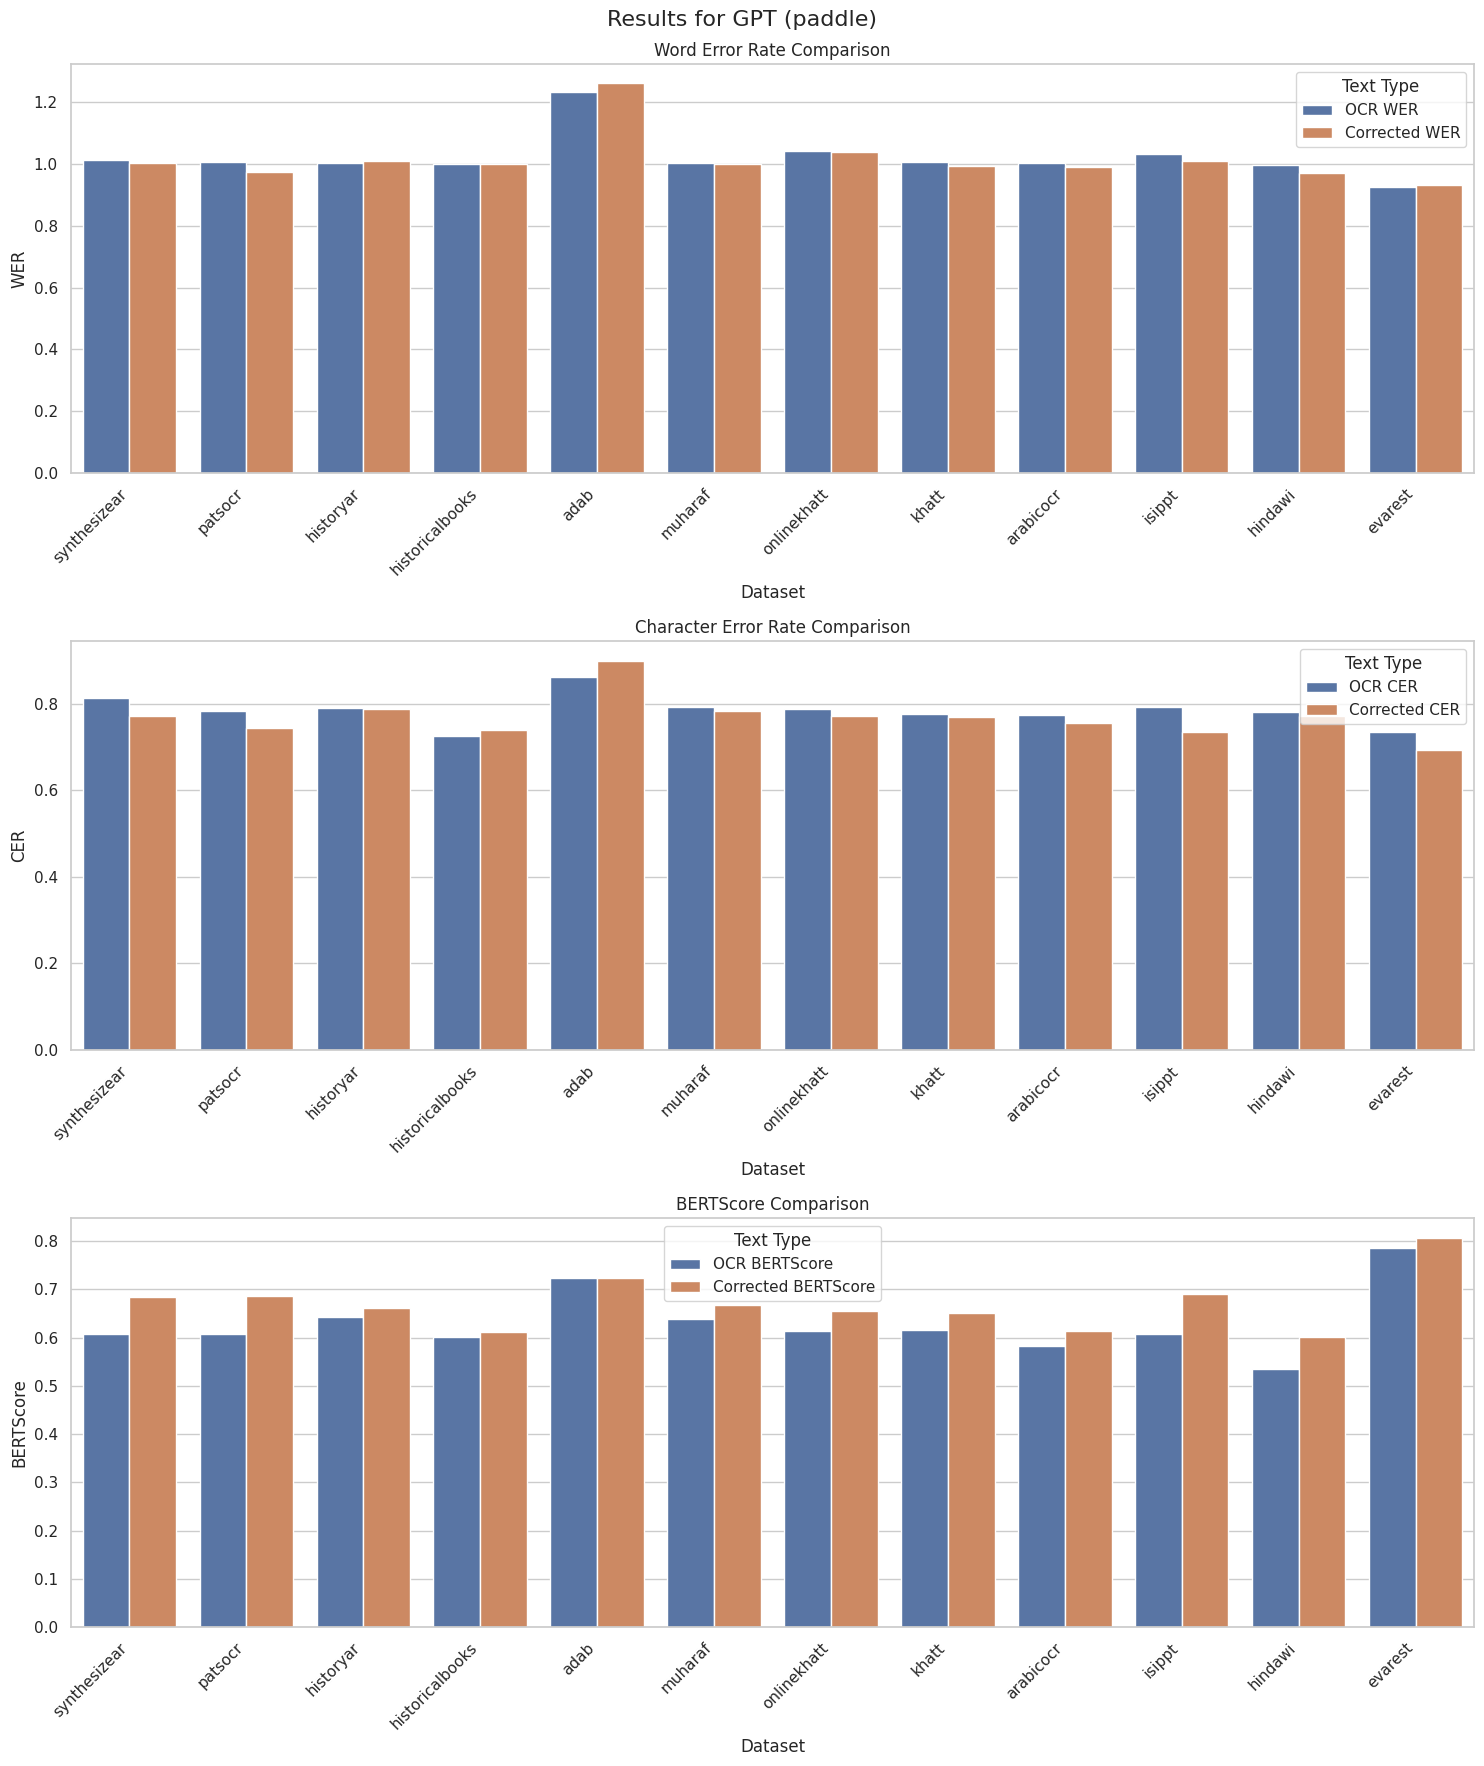

Saved visualization to visualizations_separate/Results_for_Allam_paddle.png


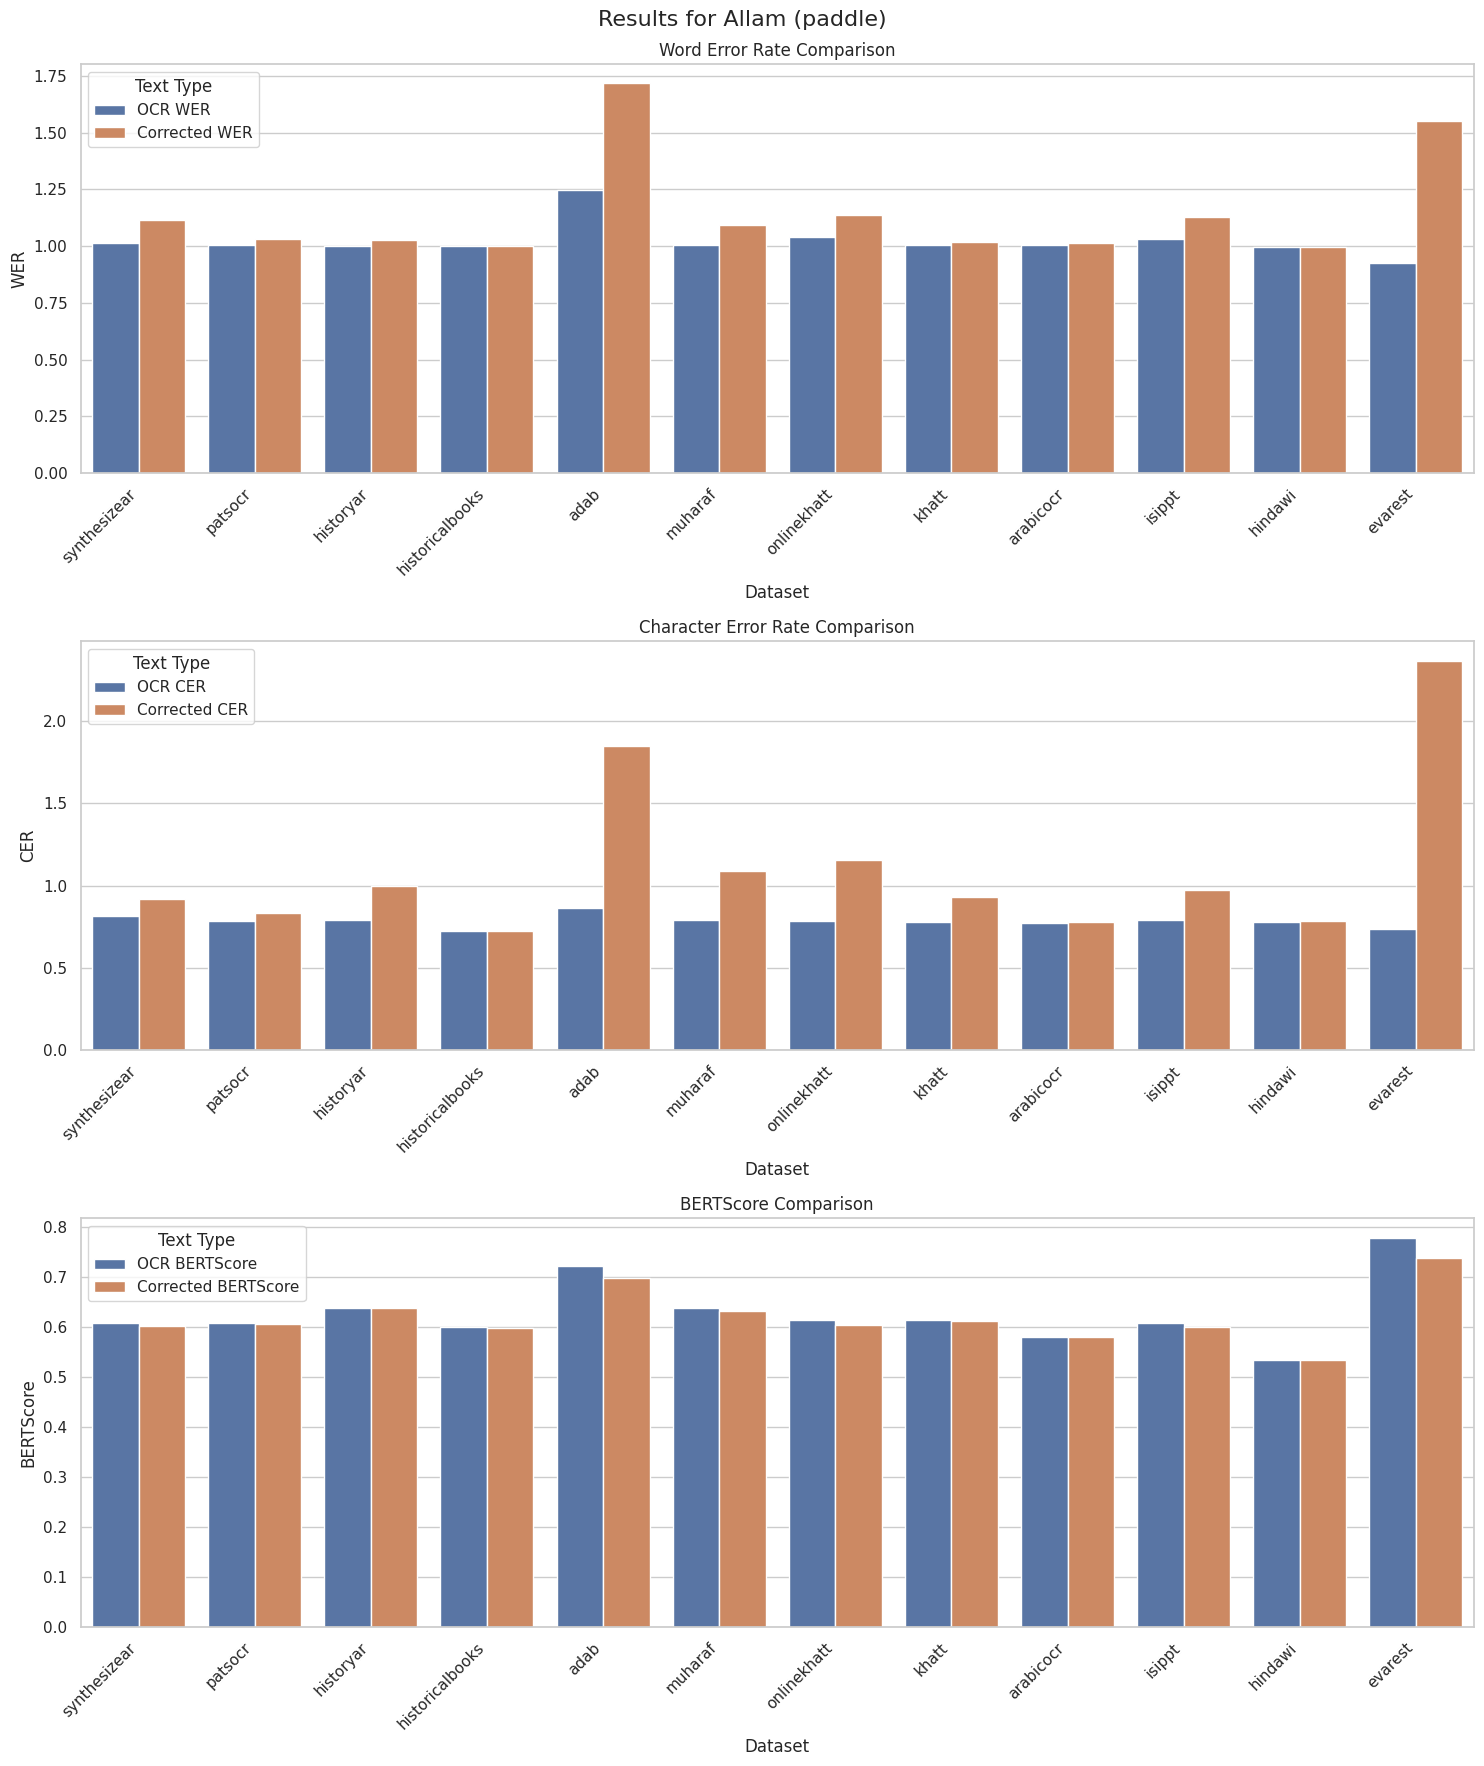

Saved visualization to visualizations_separate/Results_for_GPT_tesseract.png


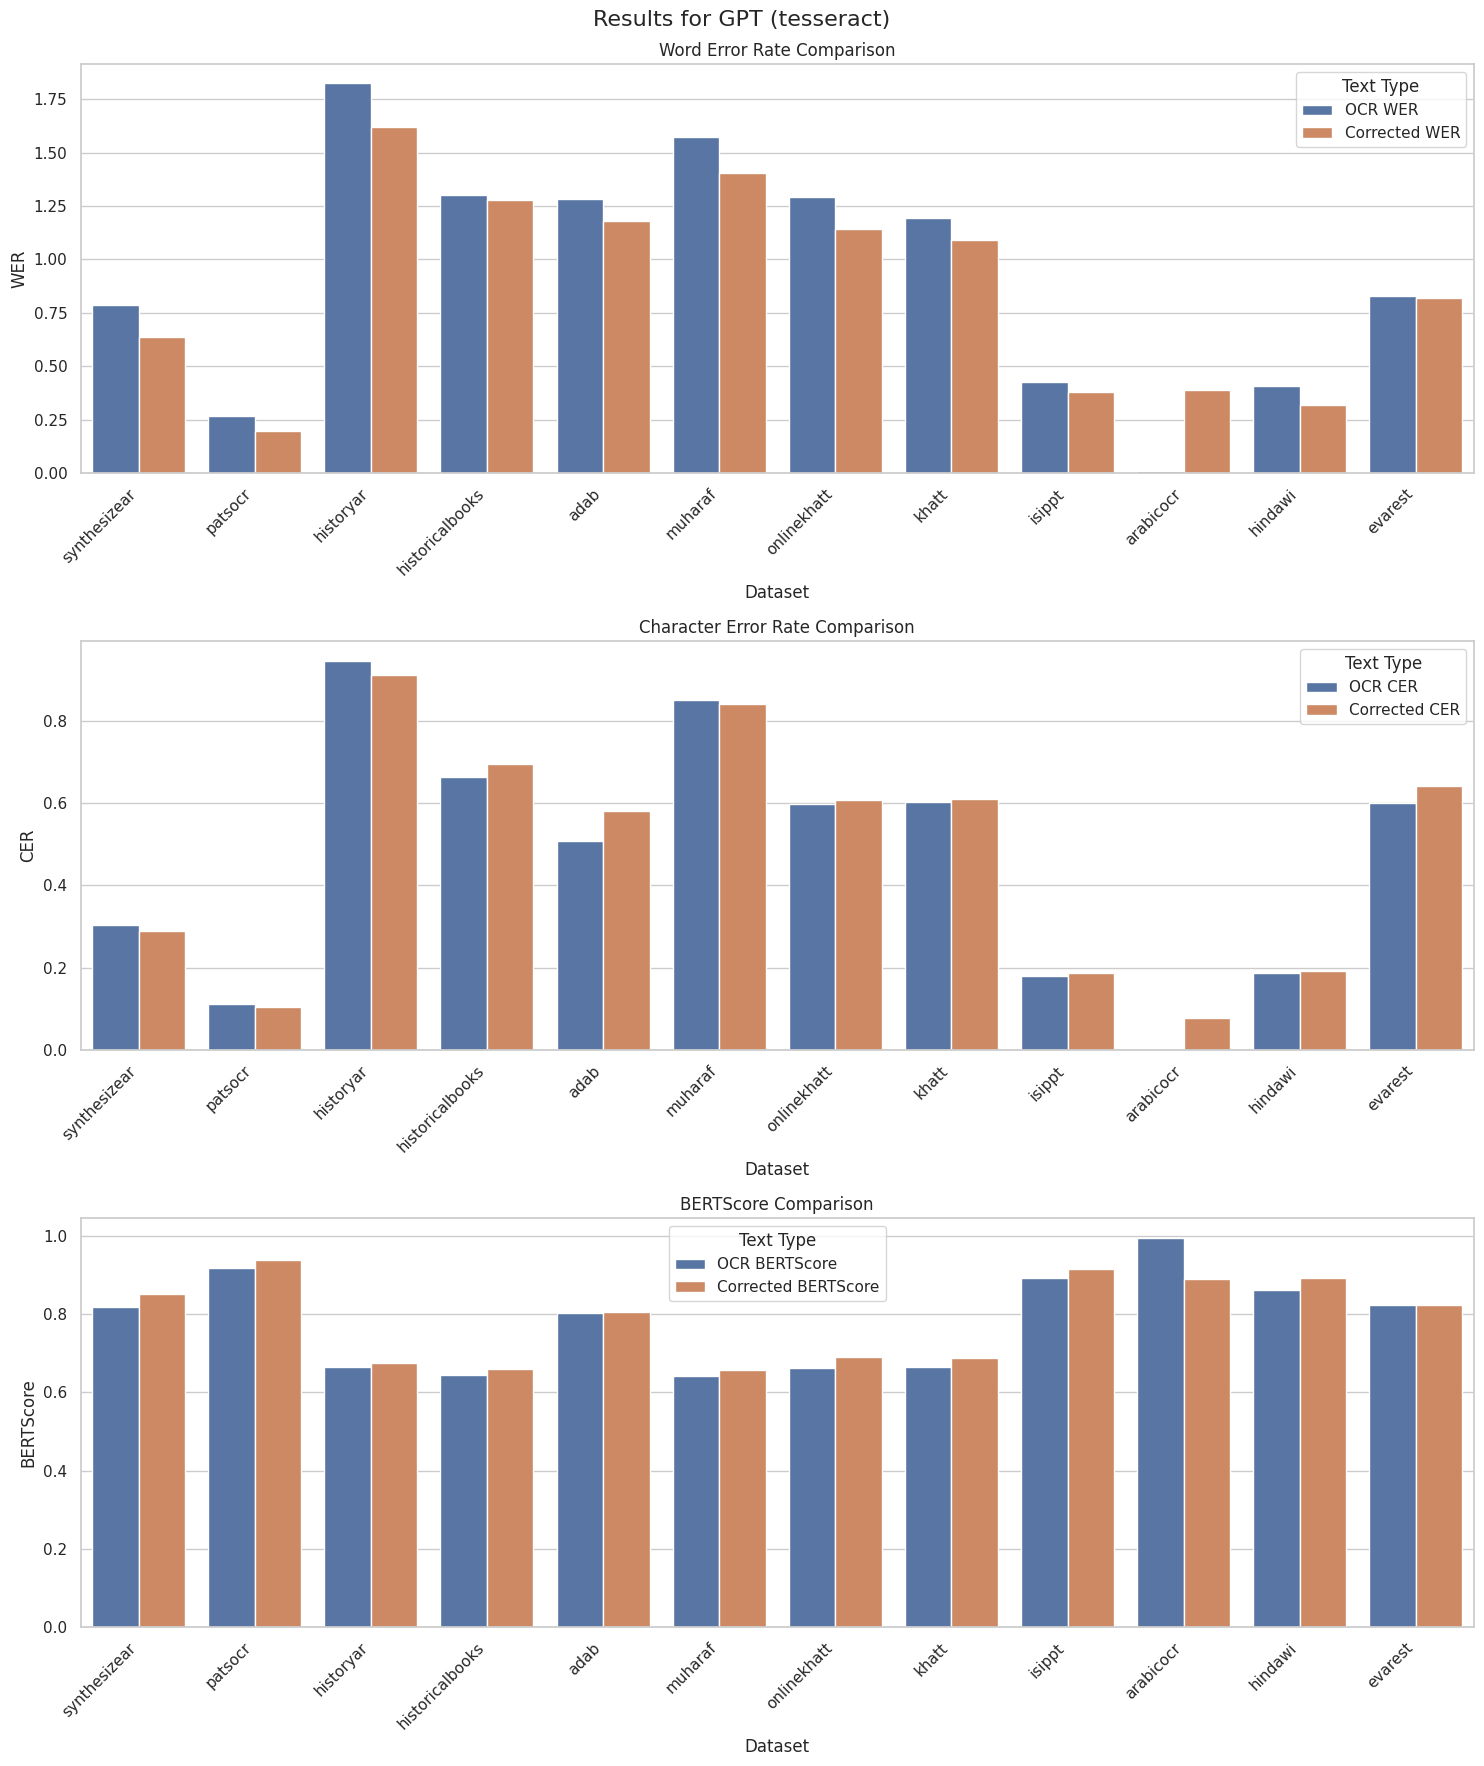

Saved visualization to visualizations_separate/Results_for_Allam_tesseract.png


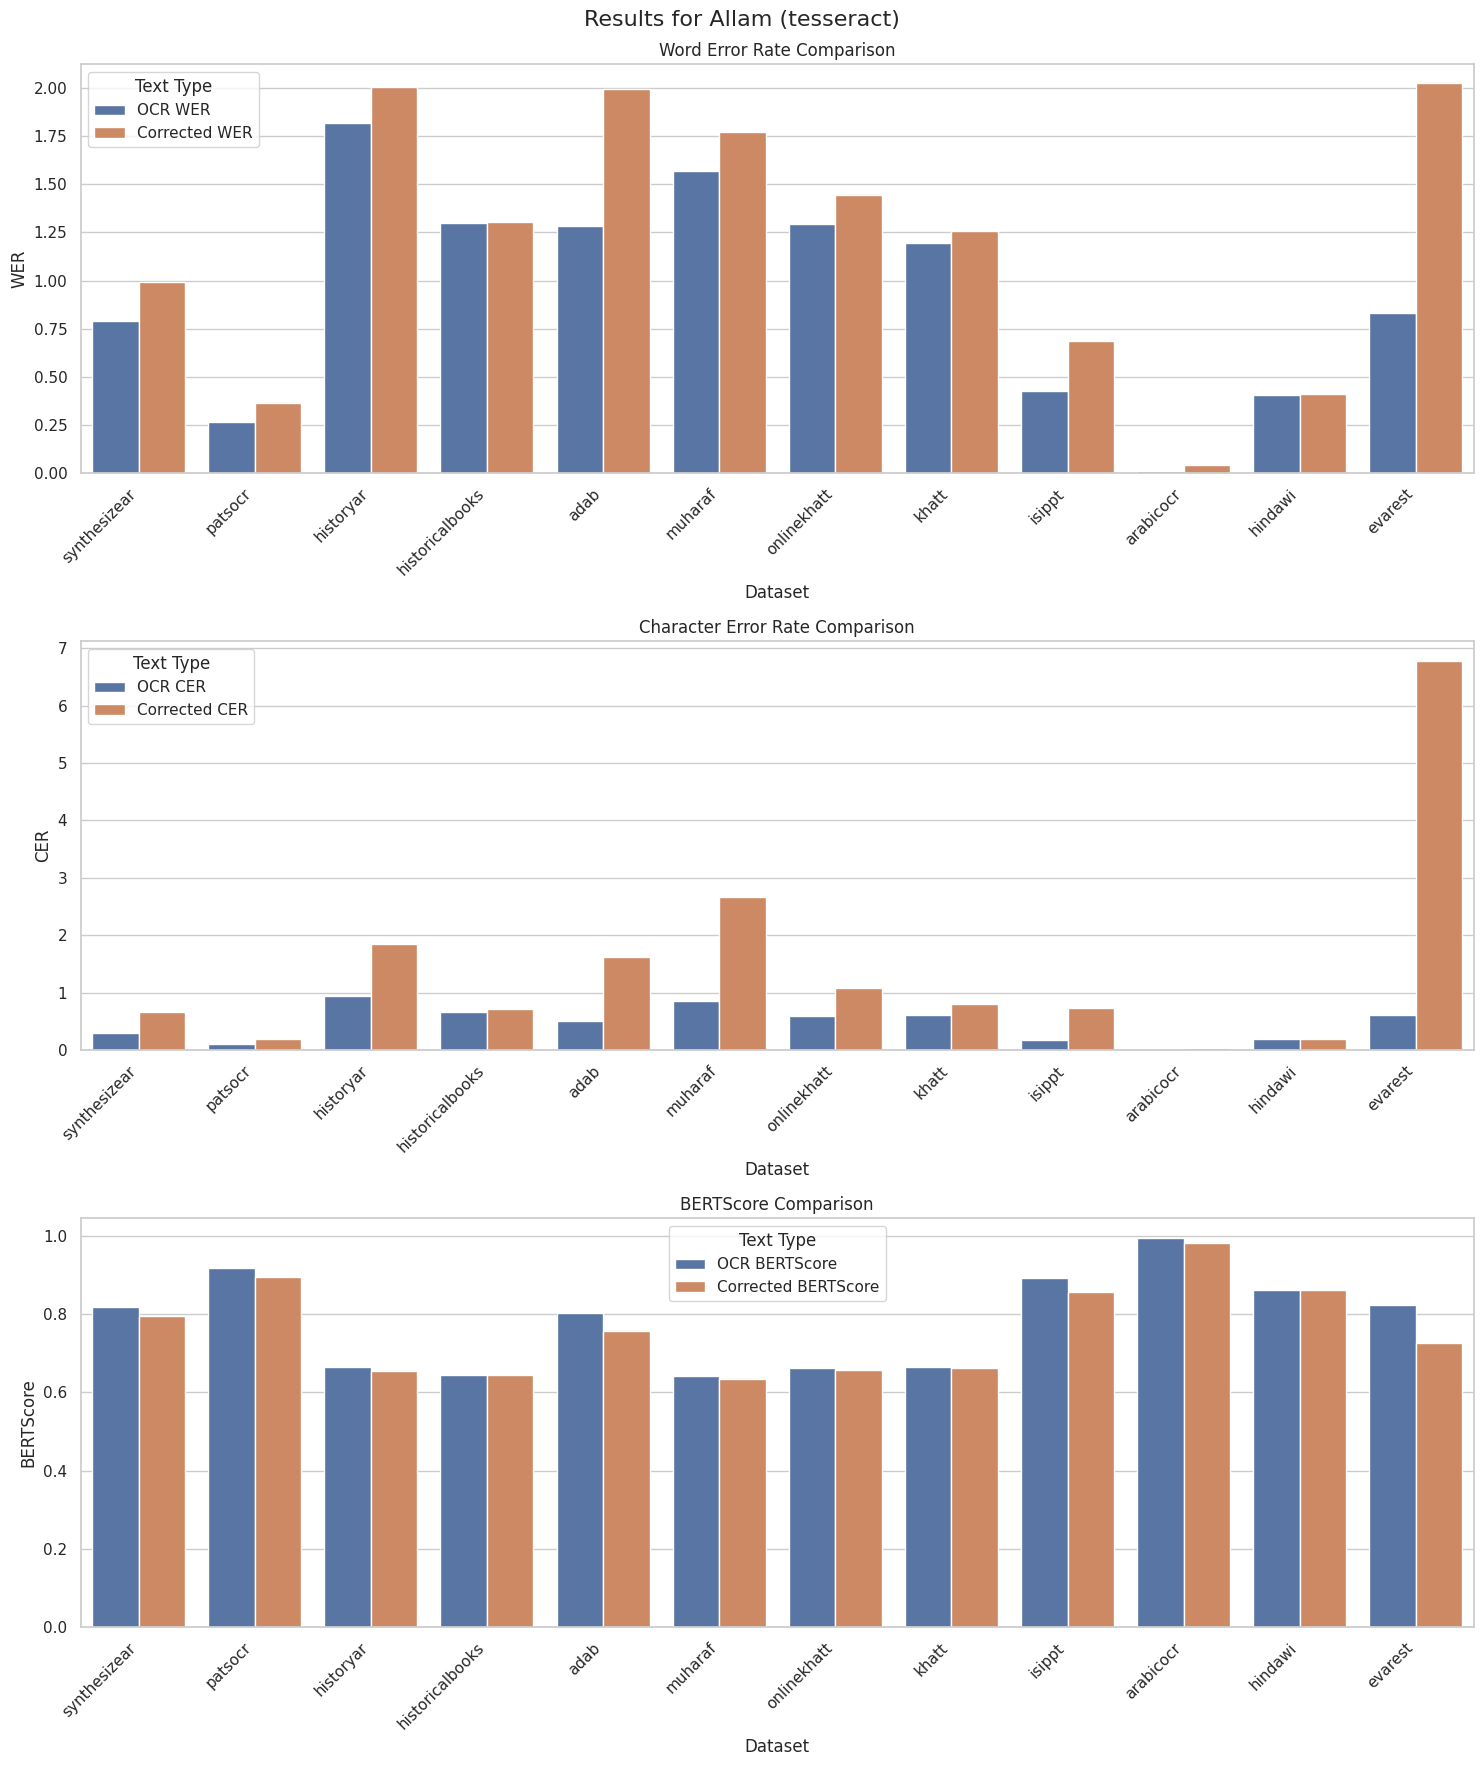

Saved visualization to visualizations_separate/Results_for_GPT_easyocr.png


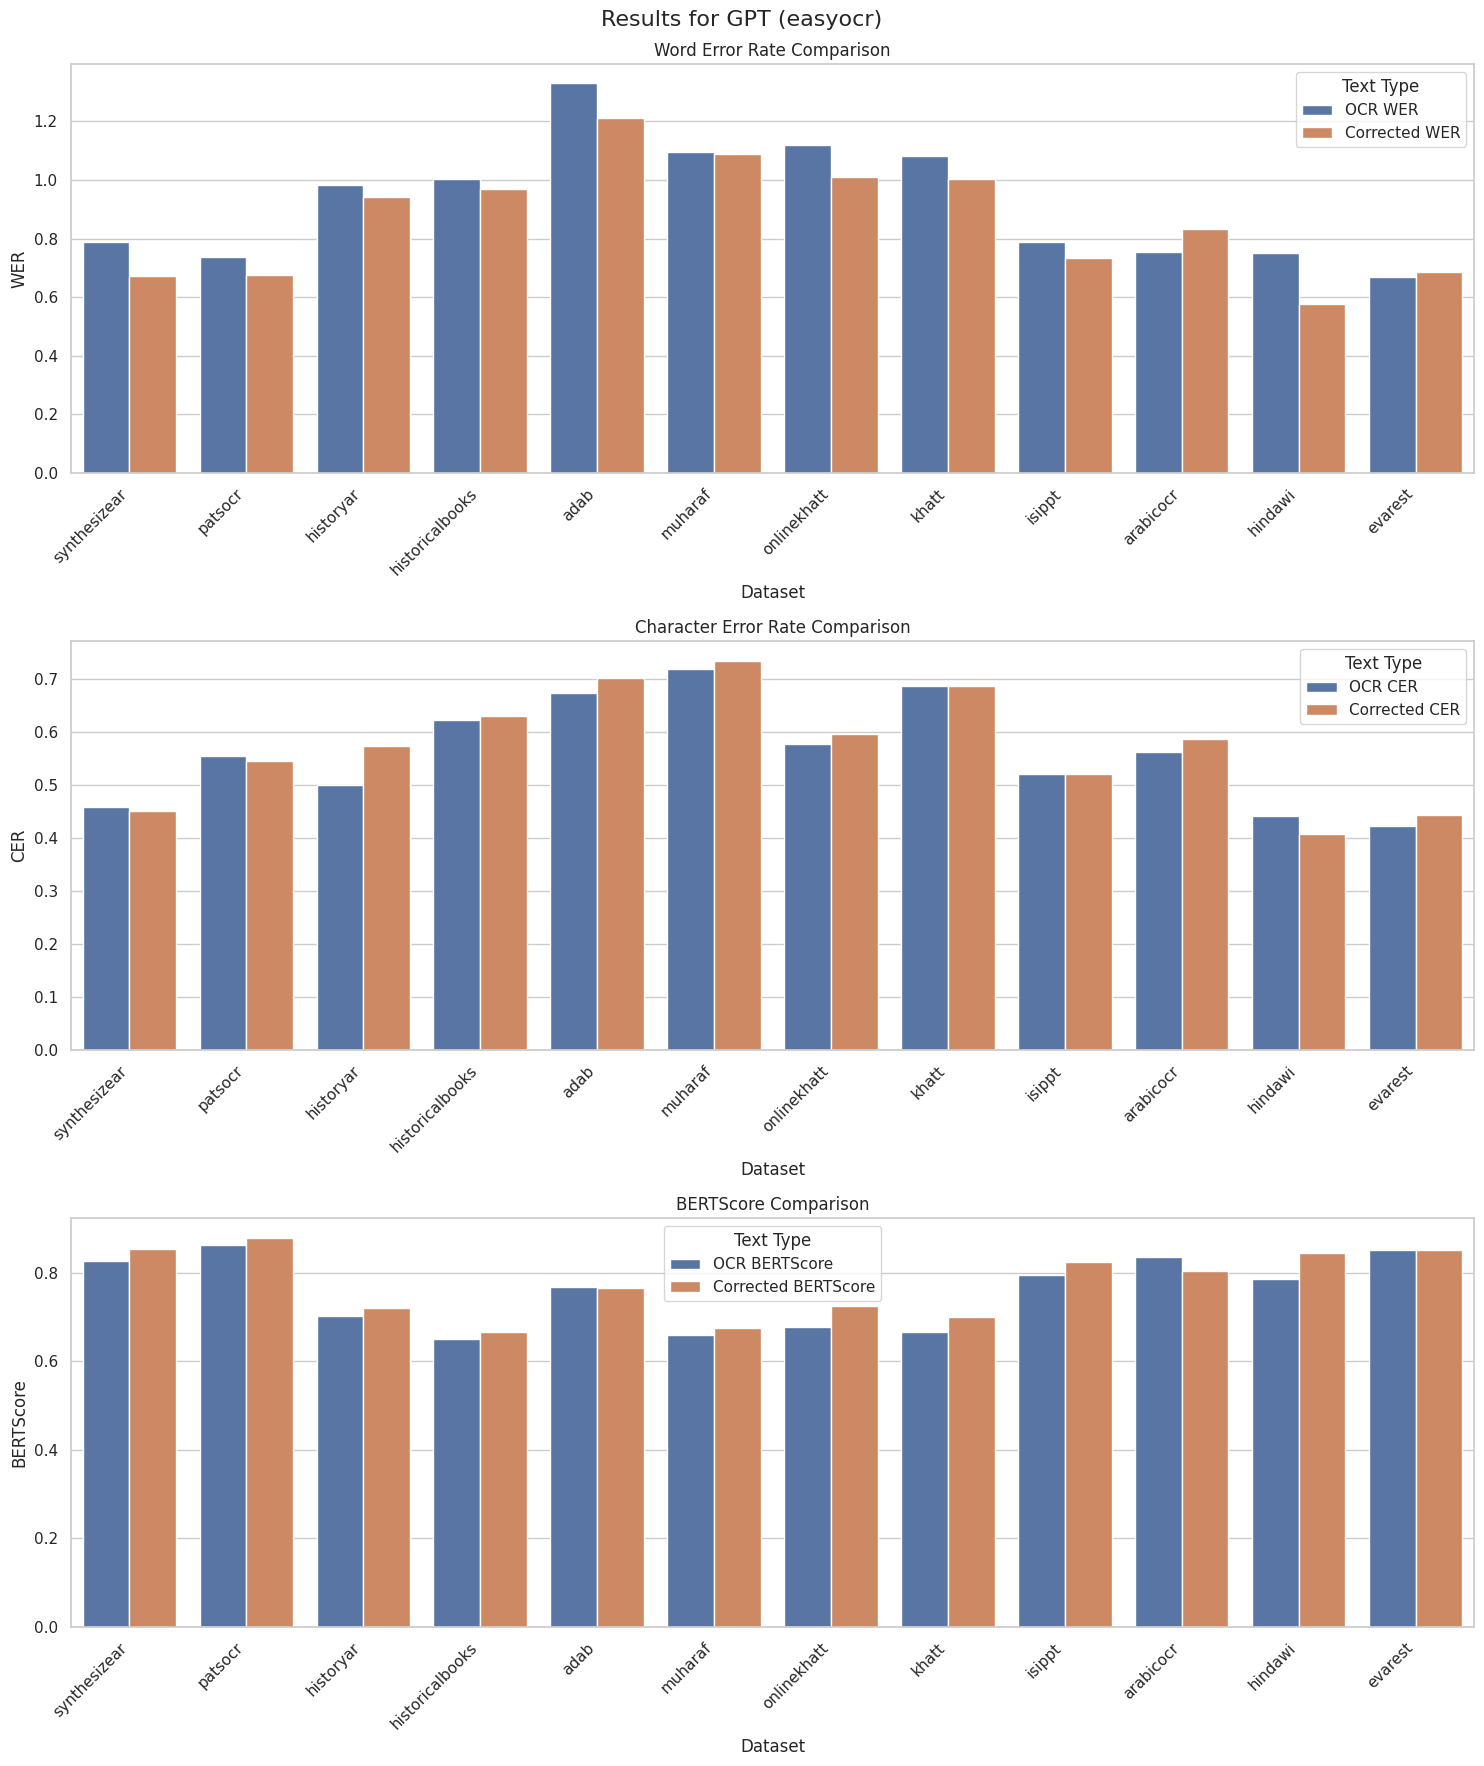

Saved visualization to visualizations_separate/Results_for_Allam_easyocr.png


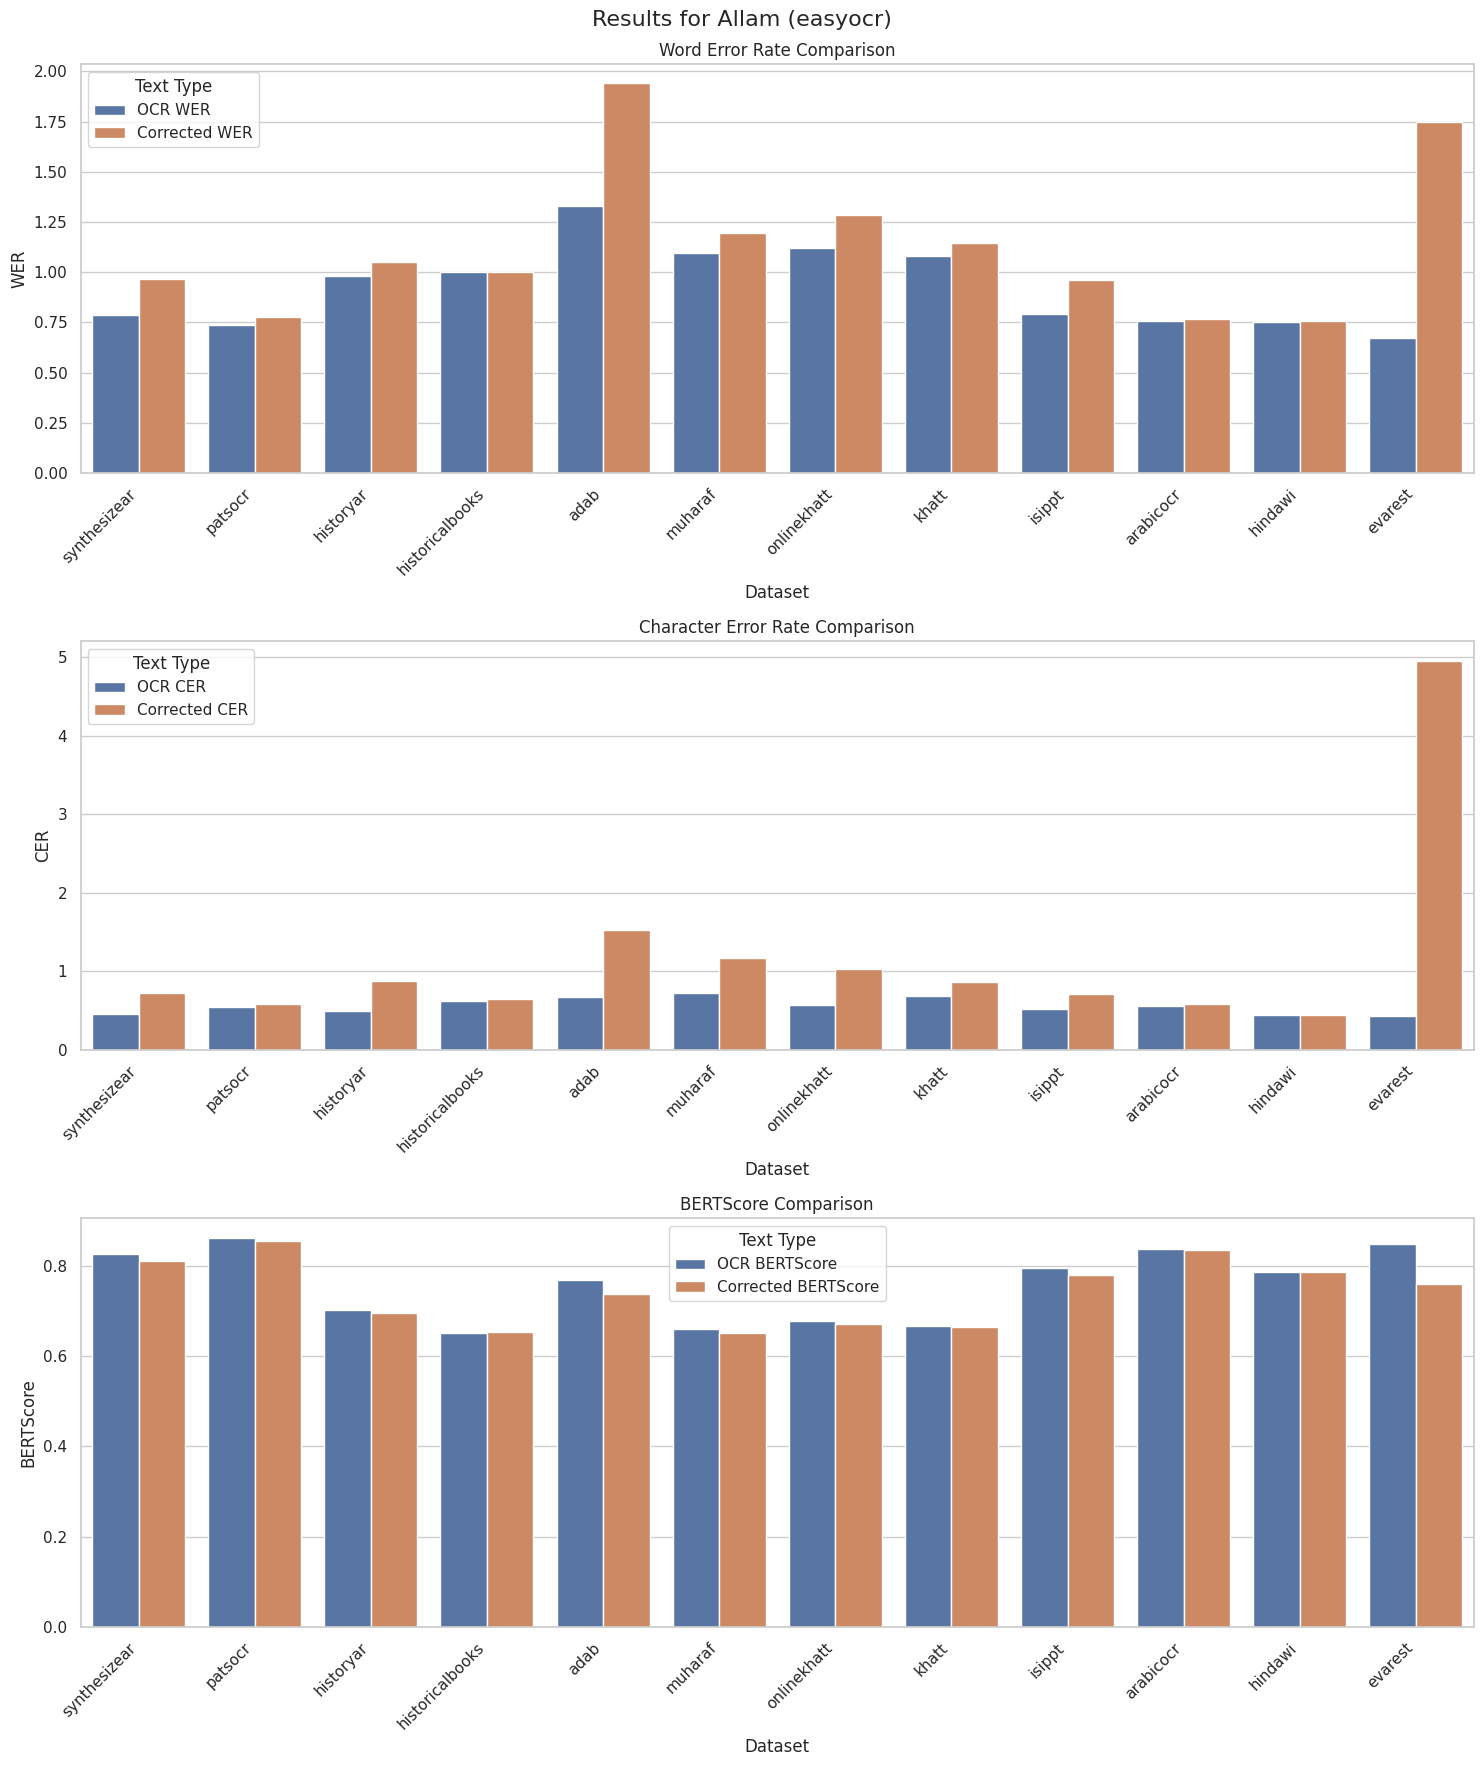

Saved visualization to visualizations_separate/Results_for_GPT_ain.png


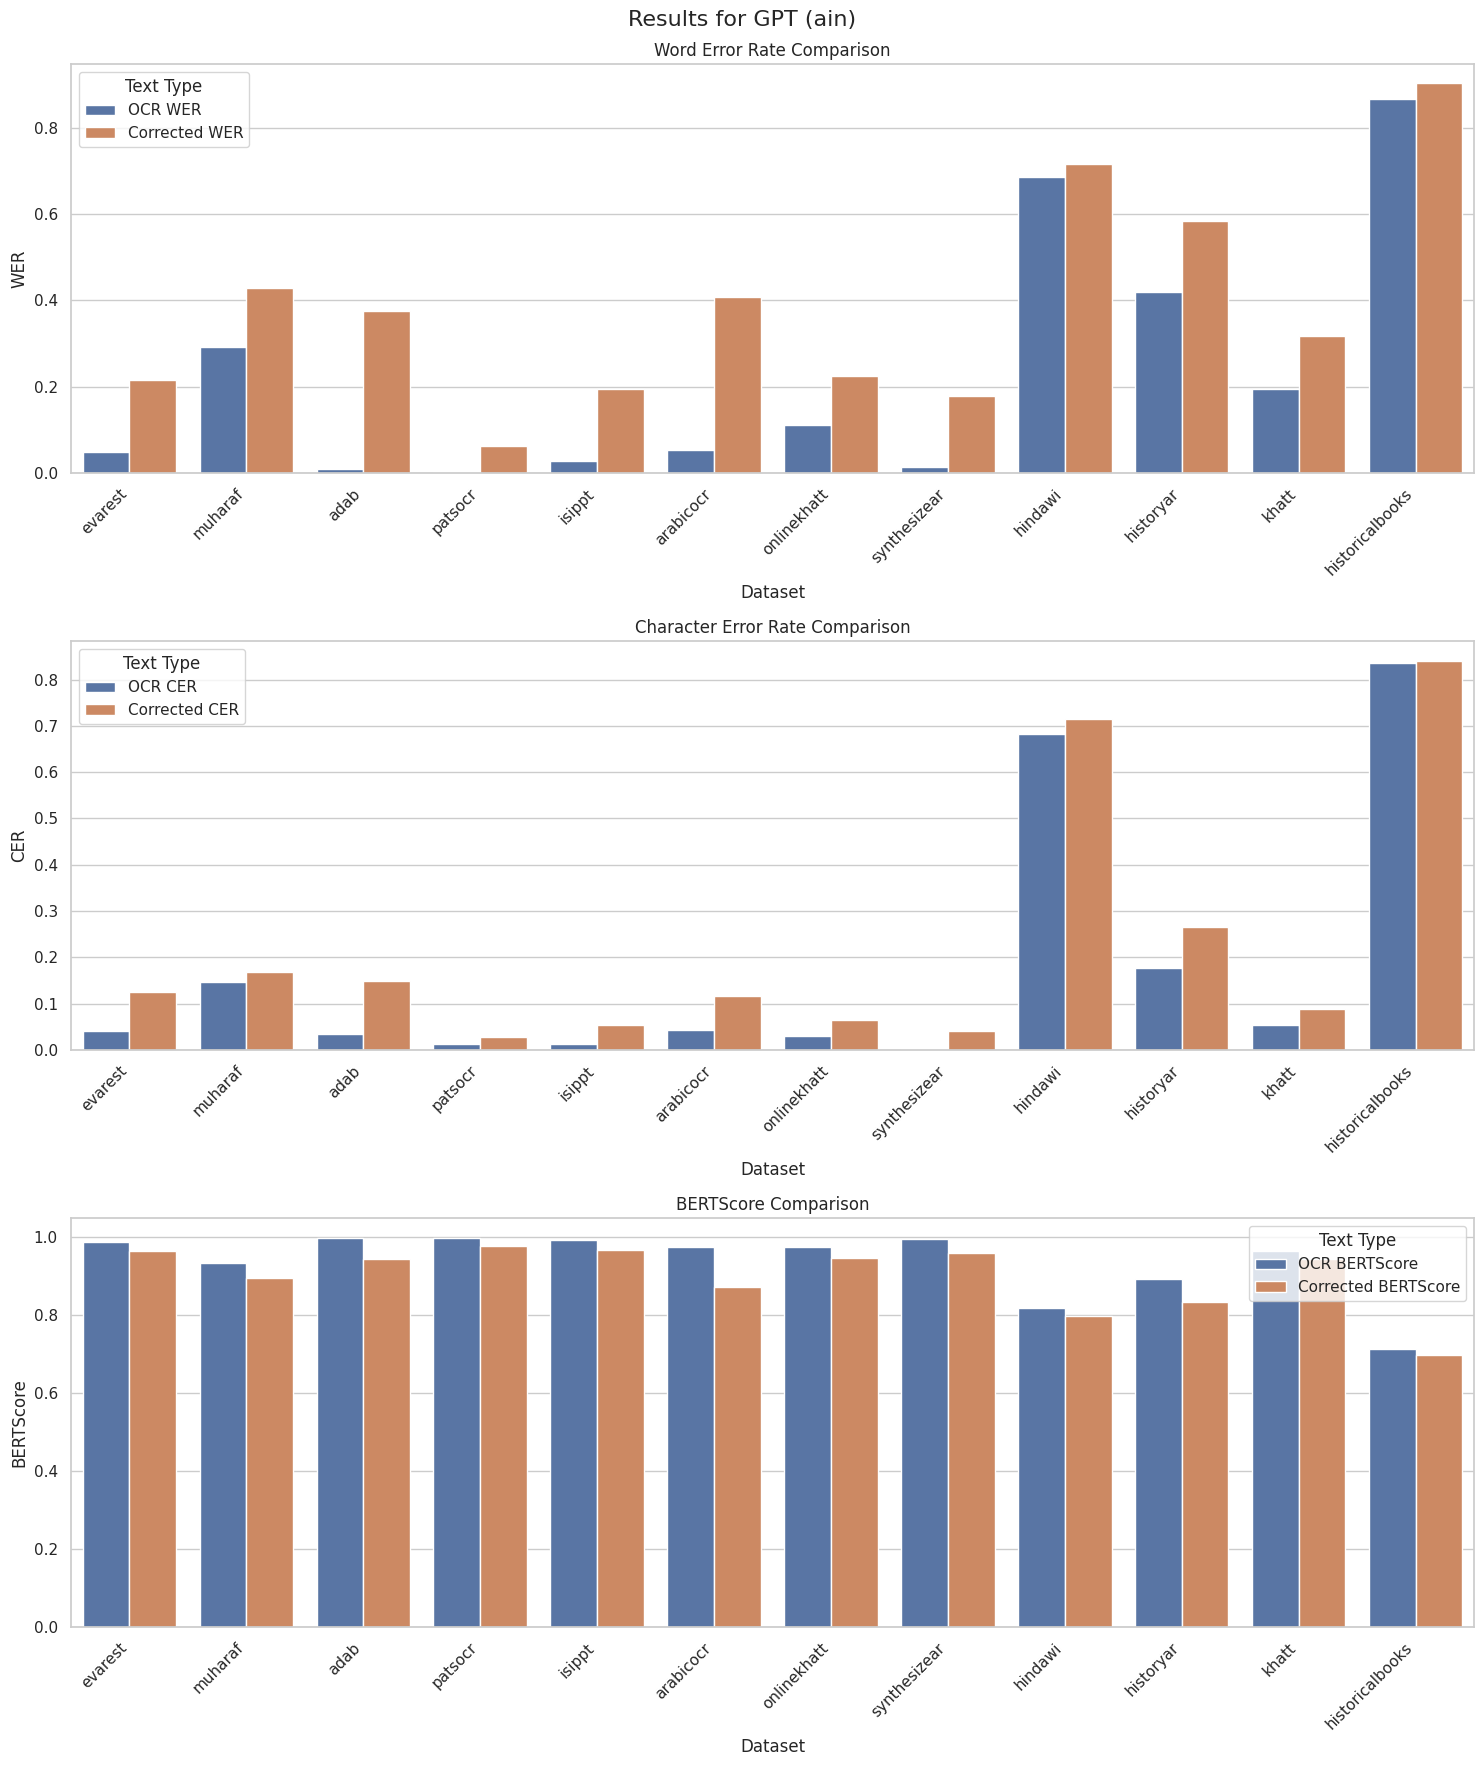

Saved visualization to visualizations_separate/Results_for_Allam_ain.png


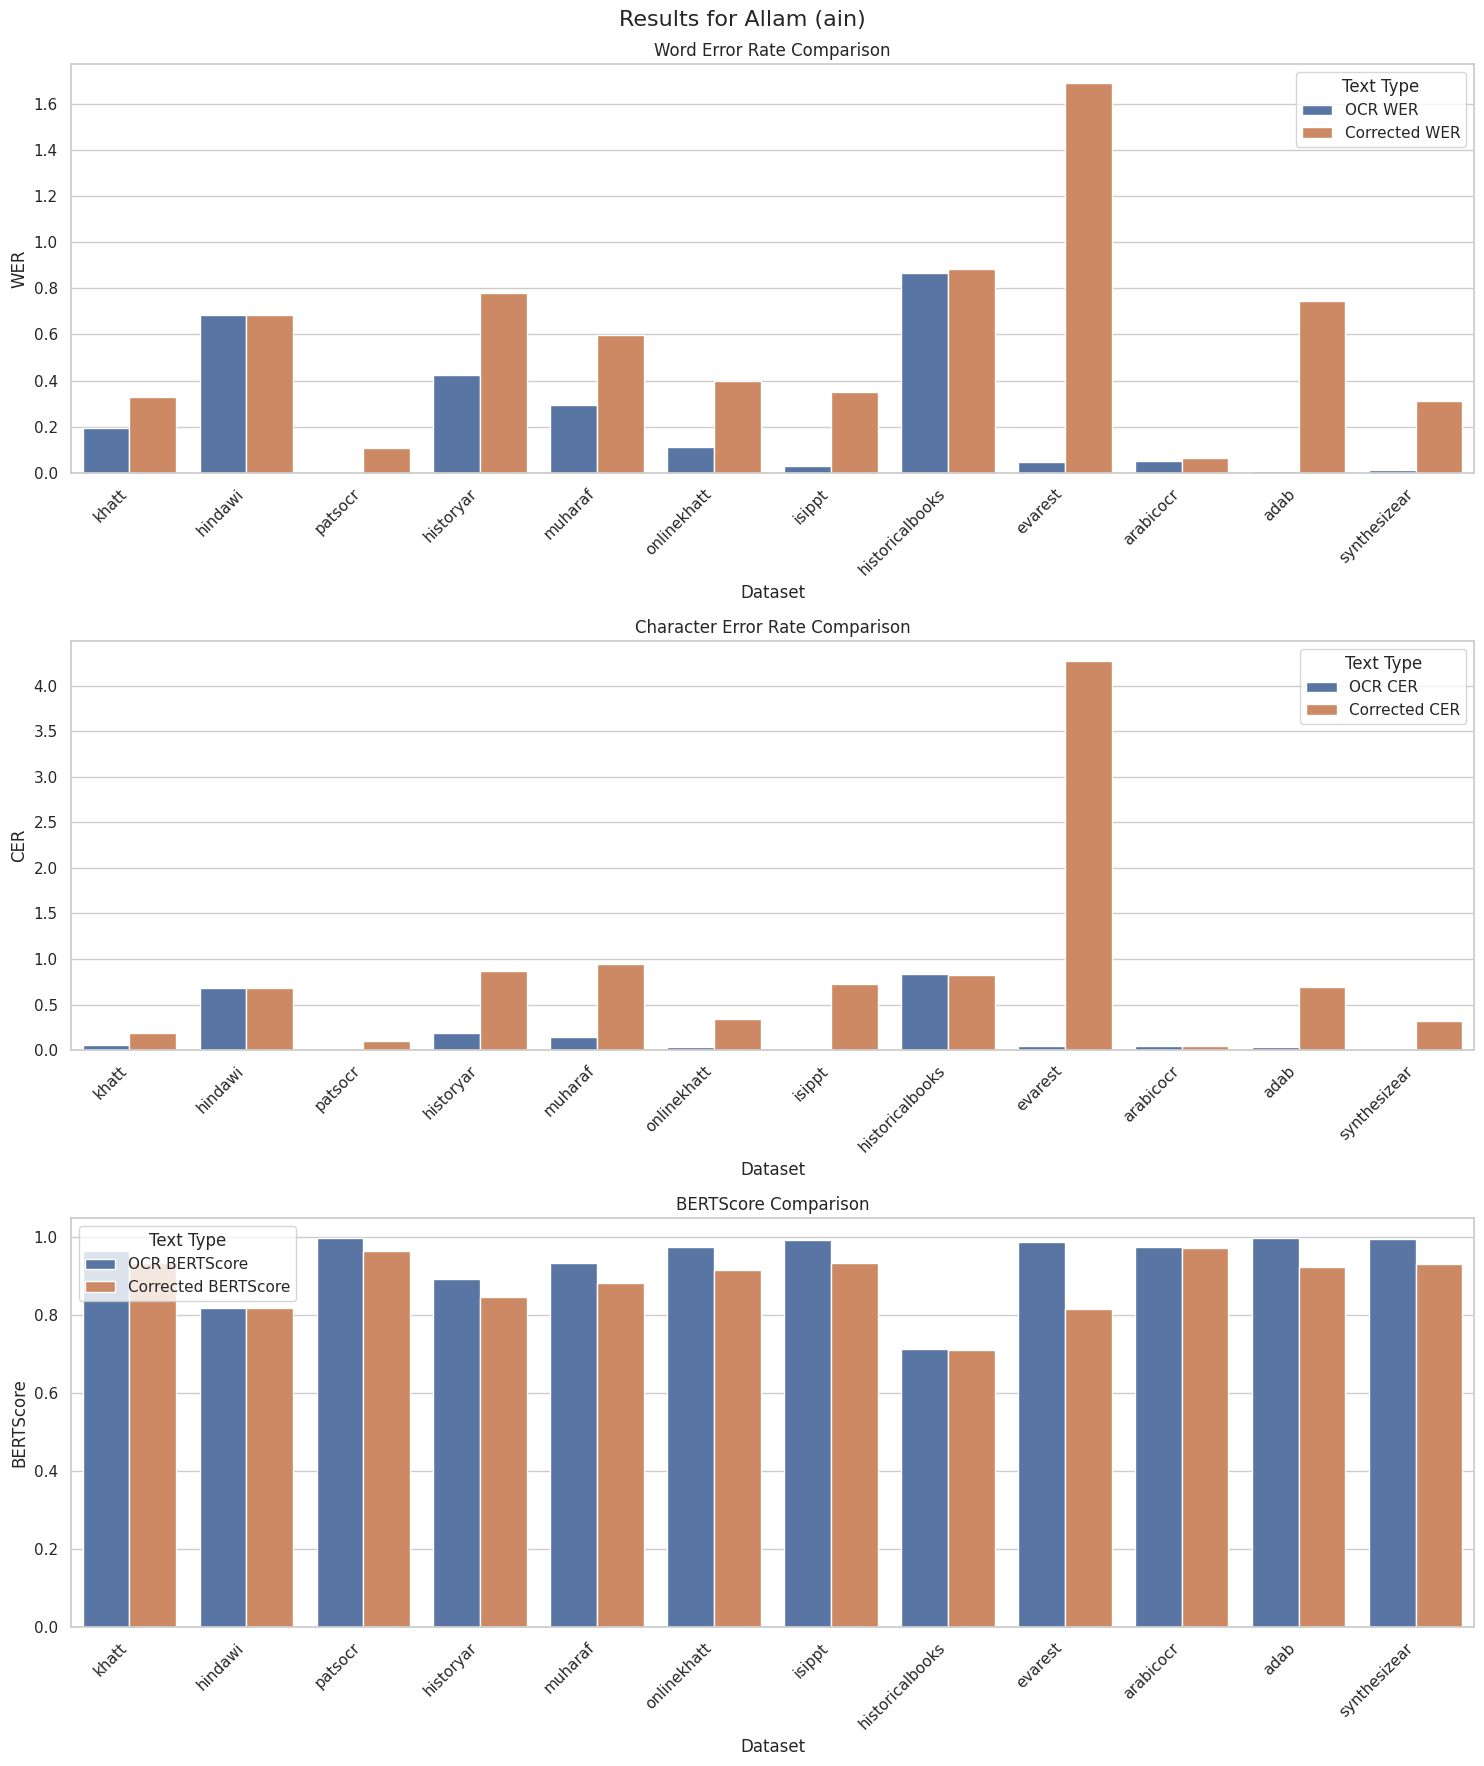

In [ ]:
# Cell 7: Create separate visualizations for each OCR model and LLM type combination
def create_separate_visualizations(df):
    """
    Create separate visualizations for each OCR model and LLM type combination

    Args:
        df: DataFrame containing evaluation results
    """
    # Set style
    sns.set(style="whitegrid")

    # Create output directory for visualizations
    output_dir = "visualizations_separate"
    os.makedirs(output_dir, exist_ok=True)

    # Get unique OCR models
    ocr_models = df['OCR'].unique()

    # For each OCR model, create separate visualizations for GPT and Allam
    for ocr_model in ocr_models:
        # Filter data for this OCR model
        ocr_df = df[df['OCR'] == ocr_model]

        # Create separate visualization for GPT models with this OCR
        gpt_df = ocr_df[ocr_df['LLM'].str.contains('gpt', case=False)]
        if not gpt_df.empty:
            create_visualization(gpt_df, f"GPT ({ocr_model})", output_dir)

        # Create separate visualization for Allam models with this OCR
        allam_df = ocr_df[(ocr_df['LLM'].str.contains('allam', case=False)) |
                           (ocr_df['LLM'].str.contains('ain', case=False))]
        if not allam_df.empty:
            create_visualization(allam_df, f"Allam ({ocr_model})", output_dir)

def create_visualization(df, title, output_dir):
    """
    Create a single visualization for a specific OCR and LLM combination

    Args:
        df: DataFrame filtered for the OCR and LLM combination
        title: Title for the visualization (e.g., "GPT (tesseract)")
        output_dir: Directory to save visualizations
    """
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 18))
    fig.suptitle(f"Results for {title}", fontsize=16)

    # Plot WER comparison
    wer_data = df.melt(
        id_vars=["Dataset", "LLM"],
        value_vars=["OCR WER", "Corrected WER"],
        var_name="Text Type", value_name="WER"
    )
    if wer_data.empty:
        print(f"No WER data for {title}")
        return

    sns.barplot(x="Dataset", y="WER", hue="Text Type", data=wer_data, ax=axes[0], errorbar='ci', capsize=0.1)
    axes[0].set_title("Word Error Rate Comparison")

    # Fix ticklabels warning
    if len(wer_data['Dataset'].unique()) > 0:
        axes[0].set_xticks(range(len(wer_data['Dataset'].unique())))
        axes[0].set_xticklabels(wer_data['Dataset'].unique(), rotation=45, ha="right")

    # Plot CER comparison
    cer_data = df.melt(
        id_vars=["Dataset", "LLM"],
        value_vars=["OCR CER", "Corrected CER"],
        var_name="Text Type", value_name="CER"
    )
    sns.barplot(x="Dataset", y="CER", hue="Text Type", data=cer_data, ax=axes[1], errorbar='ci', capsize=0.1)
    axes[1].set_title("Character Error Rate Comparison")

    # Fix ticklabels warning
    if len(cer_data['Dataset'].unique()) > 0:
        axes[1].set_xticks(range(len(cer_data['Dataset'].unique())))
        axes[1].set_xticklabels(cer_data['Dataset'].unique(), rotation=45, ha="right")

    # Plot BERTScore comparison
    bertscore_data = df.melt(
        id_vars=["Dataset", "LLM"],
        value_vars=["OCR BERTScore", "Corrected BERTScore"],
        var_name="Text Type", value_name="BERTScore"
    )
    sns.barplot(x="Dataset", y="BERTScore", hue="Text Type", data=bertscore_data, ax=axes[2], errorbar='ci', capsize=0.1)
    axes[2].set_title("BERTScore Comparison")

    # Fix ticklabels warning
    if len(bertscore_data['Dataset'].unique()) > 0:
        axes[2].set_xticks(range(len(bertscore_data['Dataset'].unique())))
        axes[2].set_xticklabels(bertscore_data['Dataset'].unique(), rotation=45, ha="right")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for the suptitle

    # Save visualization
    safe_title = title.replace(" ", "_").replace("(", "").replace(")", "")
    filename = f"Results_for_{safe_title}.png"
    file_path = os.path.join(output_dir, filename)
    plt.savefig(file_path, dpi=300)
    print(f"Saved visualization to {file_path}")
    plt.show()

# Execute the separate visualizations
if not df.empty:
    create_separate_visualizations(df)
else:
    print("Cannot create separate visualizations: No data available")